In [1]:
%matplotlib inline

import os
while 'source' not in os.listdir():
    os.chdir('..')
os.chdir('source')

FORCE = False

import gpu

In [2]:
from util import getHashId


props={
    'path'          : 'data',
    'seed'          : 42,
    'split'         : 0.8,
    'test_split'    : 0.5,
    'control'       : True,
    'huntington'    : False,
    'left'          : True,
    'right'         : True,
    'threshold'     : None,
    'binarize'      : False,
    'not_connected' : False,
    'single'        : None,
    'features'      : [],
    'features_vox'  : [],
    'radiomics'     : [
        {'sp':'native','im':'t1','fe':['b25'],'fi':['t1_mask']},
    ],
    'space'         : 'native',
    'radiomics_vox' : [
        {'im':'t1','fe':['k5_b25','k7_b25','k9_b25','k11_b25','k13_b25','k15_b25','k17_b25','k19_b25','k21_b25']},
    ],
    'rad_vox_norm'  : 'norm',
    'inps'          : [],
    'features_clin' : None,
    'outp'          : 'diffusion_md',
    'balance_data'  : False,
    'exclude'       : ['t1t2','normalized'],
    'include_warp'  : True,
    'collapse_max'  : False,
    'collapse_bin'  : False,
}

architecture={
    'activation'    : 'sigmoid',
    'layers'        : [1024,512,256,128],
    'loss'          : 'MSE',
    'learning_rate' : 0.001,
    'batch_size'    : 100,
    'patience'      : 7,
}

HASHID, HASH = getHashId(architecture,props)
print(HASH)

sigmoid_100_1024_512_256_128_0001_MSE_7_0_0_0_0_1_t1t2_normalized_e_n_e_0_1_e_1_0_diffusion_md_data_norm_b25_t1_mask_t1_native_k5_b25_k7_b25_k9_b25_k11_b25_k13_b25_k15_b25_k17_b25_k19_b25_k21_b25_t1_1_42_n_native_08_05_n


In [3]:
from DataGenerator import DataGenerator

gen = DataGenerator(**props)
train, val, test = gen.getData()

print('train')
print(train[0].shape)
print(train[1].shape)
print('validation')
print(val[0].shape)
print(val[1].shape)
print('test')
print(test[0].shape)
print(test[1].shape)

train
(631390, 934)
(631390, 1)
validation
(74368, 934)
(74368, 1)
test
(85358, 934)
(85358, 1)


In [4]:
from Model import *
from tensorflow.keras.optimizers import Adam

path = props['path']+'/models'

stop = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=architecture['patience'],
)
save = tf.keras.callbacks.ModelCheckpoint(
    filepath=path+'/{}.weights.h5'.format(HASHID),
    monitor='val_loss',
    mode='min',
    save_best_only=True,
    save_weights_only=True,
)

model = buildModel(train[0].shape[1], train[1].shape[1], activation=architecture['activation'], layers=architecture['layers'])

model.compile(loss=locals()[architecture['loss']], optimizer=Adam(learning_rate=architecture['learning_rate']), jit_compile=True, metrics=[STD,MAE])

model.summary()

Model: "FFN"


_________________________________________________________________


 Layer (type)                Output Shape              Param #   


 input_1 (InputLayer)        [(None, 934)]             0         


 dense (Dense)               (None, 1024)              957440    


 dense_1 (Dense)             (None, 512)               524800    


 dense_2 (Dense)             (None, 256)               131328    


 dense_3 (Dense)             (None, 128)               32896     


 dense_4 (Dense)             (None, 1)                 129       


Total params: 1646593 (6.28 MB)


Trainable params: 1646593 (6.28 MB)


Non-trainable params: 0 (0.00 Byte)


_________________________________________________________________


In [5]:
import os
from util import pickleSave

if FORCE or not os.path.exists(path+'/{}.pkl'.format(HASHID)):
    history = model.fit(DataWrapper(train,architecture['batch_size']),
        validation_data=DataWrapper(val,architecture['batch_size'],False),
        epochs=10000,
        verbose=1,
        callbacks = [save,stop],
    )
    pickleSave(path+'/{}.pkl'.format(HASHID), history.history)

model.load_weights(path+'/{}.weights.h5'.format(HASHID))

Epoch 1/10000


   1/6314 [..............................] - ETA: 1:50:48 - loss: 0.0393 - STD: 1.1300e-04 - MAE: 0.1926

  25/6314 [..............................] - ETA: 13s - loss: 0.0197 - STD: 6.4609e-04 - MAE: 0.0937    

  50/6314 [..............................] - ETA: 12s - loss: 0.0167 - STD: 0.0018 - MAE: 0.0849    

  76/6314 [..............................] - ETA: 12s - loss: 0.0140 - STD: 0.0106 - MAE: 0.0746

 105/6314 [..............................] - ETA: 12s - loss: 0.0112 - STD: 0.0318 - MAE: 0.0651

 129/6314 [..............................] - ETA: 12s - loss: 0.0097 - STD: 0.0439 - MAE: 0.0596

 151/6314 [..............................] - ETA: 12s - loss: 0.0088 - STD: 0.0516 - MAE: 0.0563

 170/6314 [..............................] - ETA: 12s - loss: 0.0082 - STD: 0.0561 - MAE: 0.0541

 192/6314 [..............................] - ETA: 13s - loss: 0.0076 - STD: 0.0610 - MAE: 0.0520

 217/6314 [>.............................] - ETA: 12s - loss: 0.0070 - STD: 0.0655 - MAE: 0.0503

 239/6314 [>.............................] - ETA: 13s - loss: 0.0067 - STD: 0.0686 - MAE: 0.0489

 266/6314 [>.............................] - ETA: 12s - loss: 0.0062 - STD: 0.0724 - MAE: 0.0473

 292/6314 [>.............................] - ETA: 12s - loss: 0.0059 - STD: 0.0750 - MAE: 0.0460

 318/6314 [>.............................] - ETA: 12s - loss: 0.0056 - STD: 0.0766 - MAE: 0.0448

 342/6314 [>.............................] - ETA: 12s - loss: 0.0054 - STD: 0.0785 - MAE: 0.0440

 360/6314 [>.............................] - ETA: 12s - loss: 0.0052 - STD: 0.0796 - MAE: 0.0434

 381/6314 [>.............................] - ETA: 12s - loss: 0.0050 - STD: 0.0808 - MAE: 0.0428

 405/6314 [>.............................] - ETA: 12s - loss: 0.0049 - STD: 0.0818 - MAE: 0.0420

 435/6314 [=>............................] - ETA: 12s - loss: 0.0047 - STD: 0.0832 - MAE: 0.0412

 464/6314 [=>............................] - ETA: 12s - loss: 0.0045 - STD: 0.0840 - MAE: 0.0407

 486/6314 [=>............................] - ETA: 12s - loss: 0.0044 - STD: 0.0849 - MAE: 0.0403

 511/6314 [=>............................] - ETA: 12s - loss: 0.0043 - STD: 0.0856 - MAE: 0.0398

 537/6314 [=>............................] - ETA: 12s - loss: 0.0042 - STD: 0.0861 - MAE: 0.0393

 564/6314 [=>............................] - ETA: 11s - loss: 0.0041 - STD: 0.0869 - MAE: 0.0389

 587/6314 [=>............................] - ETA: 11s - loss: 0.0040 - STD: 0.0874 - MAE: 0.0386

 607/6314 [=>............................] - ETA: 11s - loss: 0.0039 - STD: 0.0880 - MAE: 0.0383

 628/6314 [=>............................] - ETA: 12s - loss: 0.0038 - STD: 0.0885 - MAE: 0.0380

 649/6314 [==>...........................] - ETA: 12s - loss: 0.0038 - STD: 0.0888 - MAE: 0.0378

 674/6314 [==>...........................] - ETA: 11s - loss: 0.0037 - STD: 0.0893 - MAE: 0.0374

 693/6314 [==>...........................] - ETA: 12s - loss: 0.0037 - STD: 0.0894 - MAE: 0.0372

 718/6314 [==>...........................] - ETA: 11s - loss: 0.0036 - STD: 0.0898 - MAE: 0.0369

 746/6314 [==>...........................] - ETA: 11s - loss: 0.0035 - STD: 0.0903 - MAE: 0.0366

 774/6314 [==>...........................] - ETA: 11s - loss: 0.0035 - STD: 0.0908 - MAE: 0.0364

 794/6314 [==>...........................] - ETA: 11s - loss: 0.0034 - STD: 0.0910 - MAE: 0.0362

 816/6314 [==>...........................] - ETA: 11s - loss: 0.0034 - STD: 0.0914 - MAE: 0.0361

 842/6314 [===>..........................] - ETA: 11s - loss: 0.0033 - STD: 0.0917 - MAE: 0.0358

 872/6314 [===>..........................] - ETA: 11s - loss: 0.0033 - STD: 0.0921 - MAE: 0.0356

 896/6314 [===>..........................] - ETA: 11s - loss: 0.0032 - STD: 0.0924 - MAE: 0.0355

 921/6314 [===>..........................] - ETA: 11s - loss: 0.0032 - STD: 0.0927 - MAE: 0.0353

 949/6314 [===>..........................] - ETA: 11s - loss: 0.0032 - STD: 0.0929 - MAE: 0.0352

 978/6314 [===>..........................] - ETA: 11s - loss: 0.0031 - STD: 0.0933 - MAE: 0.0351

1007/6314 [===>..........................] - ETA: 11s - loss: 0.0031 - STD: 0.0935 - MAE: 0.0350

1035/6314 [===>..........................] - ETA: 10s - loss: 0.0031 - STD: 0.0937 - MAE: 0.0349

1061/6314 [====>.........................] - ETA: 10s - loss: 0.0031 - STD: 0.0937 - MAE: 0.0347

1091/6314 [====>.........................] - ETA: 10s - loss: 0.0030 - STD: 0.0937 - MAE: 0.0346

1121/6314 [====>.........................] - ETA: 10s - loss: 0.0030 - STD: 0.0939 - MAE: 0.0344

1149/6314 [====>.........................] - ETA: 10s - loss: 0.0030 - STD: 0.0940 - MAE: 0.0343

1176/6314 [====>.........................] - ETA: 10s - loss: 0.0029 - STD: 0.0943 - MAE: 0.0341

1200/6314 [====>.........................] - ETA: 10s - loss: 0.0029 - STD: 0.0944 - MAE: 0.0340

1224/6314 [====>.........................] - ETA: 10s - loss: 0.0029 - STD: 0.0946 - MAE: 0.0339

1247/6314 [====>.........................] - ETA: 10s - loss: 0.0028 - STD: 0.0948 - MAE: 0.0337

1267/6314 [=====>........................] - ETA: 10s - loss: 0.0028 - STD: 0.0949 - MAE: 0.0337

1289/6314 [=====>........................] - ETA: 10s - loss: 0.0028 - STD: 0.0952 - MAE: 0.0336

1311/6314 [=====>........................] - ETA: 10s - loss: 0.0028 - STD: 0.0954 - MAE: 0.0335

1334/6314 [=====>........................] - ETA: 10s - loss: 0.0028 - STD: 0.0954 - MAE: 0.0334

1357/6314 [=====>........................] - ETA: 10s - loss: 0.0028 - STD: 0.0955 - MAE: 0.0333

1386/6314 [=====>........................] - ETA: 10s - loss: 0.0027 - STD: 0.0958 - MAE: 0.0332

1406/6314 [=====>........................] - ETA: 10s - loss: 0.0027 - STD: 0.0958 - MAE: 0.0331

1428/6314 [=====>........................] - ETA: 10s - loss: 0.0027 - STD: 0.0959 - MAE: 0.0331

1457/6314 [=====>........................] - ETA: 10s - loss: 0.0027 - STD: 0.0960 - MAE: 0.0330

1486/6314 [======>.......................] - ETA: 9s - loss: 0.0027 - STD: 0.0962 - MAE: 0.0329 

1513/6314 [======>.......................] - ETA: 9s - loss: 0.0026 - STD: 0.0963 - MAE: 0.0328

1542/6314 [======>.......................] - ETA: 9s - loss: 0.0026 - STD: 0.0965 - MAE: 0.0327

1566/6314 [======>.......................] - ETA: 9s - loss: 0.0026 - STD: 0.0964 - MAE: 0.0327

1595/6314 [======>.......................] - ETA: 9s - loss: 0.0026 - STD: 0.0965 - MAE: 0.0325

1626/6314 [======>.......................] - ETA: 9s - loss: 0.0026 - STD: 0.0966 - MAE: 0.0324

1656/6314 [======>.......................] - ETA: 9s - loss: 0.0026 - STD: 0.0967 - MAE: 0.0324

1685/6314 [=======>......................] - ETA: 9s - loss: 0.0025 - STD: 0.0968 - MAE: 0.0323

1713/6314 [=======>......................] - ETA: 9s - loss: 0.0025 - STD: 0.0969 - MAE: 0.0323

1736/6314 [=======>......................] - ETA: 9s - loss: 0.0025 - STD: 0.0969 - MAE: 0.0322

1763/6314 [=======>......................] - ETA: 9s - loss: 0.0025 - STD: 0.0970 - MAE: 0.0322

1789/6314 [=======>......................] - ETA: 9s - loss: 0.0025 - STD: 0.0971 - MAE: 0.0321

1810/6314 [=======>......................] - ETA: 9s - loss: 0.0025 - STD: 0.0971 - MAE: 0.0321

1837/6314 [=======>......................] - ETA: 9s - loss: 0.0025 - STD: 0.0972 - MAE: 0.0320

1867/6314 [=======>......................] - ETA: 8s - loss: 0.0025 - STD: 0.0972 - MAE: 0.0320

1892/6314 [=======>......................] - ETA: 8s - loss: 0.0025 - STD: 0.0973 - MAE: 0.0319

1917/6314 [========>.....................] - ETA: 8s - loss: 0.0024 - STD: 0.0973 - MAE: 0.0319

1946/6314 [========>.....................] - ETA: 8s - loss: 0.0024 - STD: 0.0974 - MAE: 0.0318

1974/6314 [========>.....................] - ETA: 8s - loss: 0.0024 - STD: 0.0976 - MAE: 0.0318

1997/6314 [========>.....................] - ETA: 8s - loss: 0.0024 - STD: 0.0977 - MAE: 0.0317

2028/6314 [========>.....................] - ETA: 8s - loss: 0.0024 - STD: 0.0978 - MAE: 0.0317

2059/6314 [========>.....................] - ETA: 8s - loss: 0.0024 - STD: 0.0978 - MAE: 0.0316

2090/6314 [========>.....................] - ETA: 8s - loss: 0.0024 - STD: 0.0978 - MAE: 0.0316

2121/6314 [=========>....................] - ETA: 8s - loss: 0.0024 - STD: 0.0978 - MAE: 0.0315

2151/6314 [=========>....................] - ETA: 8s - loss: 0.0024 - STD: 0.0978 - MAE: 0.0315

2174/6314 [=========>....................] - ETA: 8s - loss: 0.0024 - STD: 0.0979 - MAE: 0.0314

2196/6314 [=========>....................] - ETA: 8s - loss: 0.0023 - STD: 0.0979 - MAE: 0.0314

2223/6314 [=========>....................] - ETA: 8s - loss: 0.0023 - STD: 0.0979 - MAE: 0.0313

2245/6314 [=========>....................] - ETA: 8s - loss: 0.0023 - STD: 0.0980 - MAE: 0.0313

2272/6314 [=========>....................] - ETA: 8s - loss: 0.0023 - STD: 0.0981 - MAE: 0.0313

2297/6314 [=========>....................] - ETA: 8s - loss: 0.0023 - STD: 0.0981 - MAE: 0.0312

2324/6314 [==========>...................] - ETA: 7s - loss: 0.0023 - STD: 0.0981 - MAE: 0.0312

2346/6314 [==========>...................] - ETA: 7s - loss: 0.0023 - STD: 0.0981 - MAE: 0.0311

2374/6314 [==========>...................] - ETA: 7s - loss: 0.0023 - STD: 0.0982 - MAE: 0.0311

2405/6314 [==========>...................] - ETA: 7s - loss: 0.0023 - STD: 0.0982 - MAE: 0.0311

2434/6314 [==========>...................] - ETA: 7s - loss: 0.0023 - STD: 0.0983 - MAE: 0.0310

2463/6314 [==========>...................] - ETA: 7s - loss: 0.0023 - STD: 0.0983 - MAE: 0.0310

2491/6314 [==========>...................] - ETA: 7s - loss: 0.0023 - STD: 0.0985 - MAE: 0.0309

2514/6314 [==========>...................] - ETA: 7s - loss: 0.0022 - STD: 0.0986 - MAE: 0.0309

2539/6314 [===========>..................] - ETA: 7s - loss: 0.0022 - STD: 0.0986 - MAE: 0.0308

2571/6314 [===========>..................] - ETA: 7s - loss: 0.0022 - STD: 0.0987 - MAE: 0.0308

2601/6314 [===========>..................] - ETA: 7s - loss: 0.0022 - STD: 0.0987 - MAE: 0.0308

2631/6314 [===========>..................] - ETA: 7s - loss: 0.0022 - STD: 0.0987 - MAE: 0.0307

2661/6314 [===========>..................] - ETA: 7s - loss: 0.0022 - STD: 0.0987 - MAE: 0.0307

2686/6314 [===========>..................] - ETA: 7s - loss: 0.0022 - STD: 0.0988 - MAE: 0.0307

2710/6314 [===========>..................] - ETA: 7s - loss: 0.0022 - STD: 0.0988 - MAE: 0.0306

2740/6314 [============>.................] - ETA: 7s - loss: 0.0022 - STD: 0.0988 - MAE: 0.0306

2770/6314 [============>.................] - ETA: 6s - loss: 0.0022 - STD: 0.0989 - MAE: 0.0306

2801/6314 [============>.................] - ETA: 6s - loss: 0.0022 - STD: 0.0989 - MAE: 0.0305

2830/6314 [============>.................] - ETA: 6s - loss: 0.0022 - STD: 0.0989 - MAE: 0.0305

2859/6314 [============>.................] - ETA: 6s - loss: 0.0022 - STD: 0.0990 - MAE: 0.0305

2884/6314 [============>.................] - ETA: 6s - loss: 0.0022 - STD: 0.0990 - MAE: 0.0304

2907/6314 [============>.................] - ETA: 6s - loss: 0.0022 - STD: 0.0991 - MAE: 0.0304

2933/6314 [============>.................] - ETA: 6s - loss: 0.0022 - STD: 0.0991 - MAE: 0.0304

2959/6314 [=============>................] - ETA: 6s - loss: 0.0021 - STD: 0.0992 - MAE: 0.0304

2984/6314 [=============>................] - ETA: 6s - loss: 0.0021 - STD: 0.0992 - MAE: 0.0304

3013/6314 [=============>................] - ETA: 6s - loss: 0.0021 - STD: 0.0994 - MAE: 0.0303

3040/6314 [=============>................] - ETA: 6s - loss: 0.0021 - STD: 0.0994 - MAE: 0.0303

3062/6314 [=============>................] - ETA: 6s - loss: 0.0021 - STD: 0.0994 - MAE: 0.0303

3068/6314 [=============>................] - ETA: 6s - loss: 0.0021 - STD: 0.0994 - MAE: 0.0303

3088/6314 [=============>................] - ETA: 6s - loss: 0.0021 - STD: 0.0995 - MAE: 0.0303

3109/6314 [=============>................] - ETA: 6s - loss: 0.0021 - STD: 0.0995 - MAE: 0.0302

3139/6314 [=============>................] - ETA: 6s - loss: 0.0021 - STD: 0.0995 - MAE: 0.0302

3168/6314 [==============>...............] - ETA: 6s - loss: 0.0021 - STD: 0.0996 - MAE: 0.0302

3199/6314 [==============>...............] - ETA: 6s - loss: 0.0021 - STD: 0.0996 - MAE: 0.0301

3229/6314 [==============>...............] - ETA: 6s - loss: 0.0021 - STD: 0.0996 - MAE: 0.0301

3257/6314 [==============>...............] - ETA: 6s - loss: 0.0021 - STD: 0.0996 - MAE: 0.0301

3286/6314 [==============>...............] - ETA: 6s - loss: 0.0021 - STD: 0.0997 - MAE: 0.0301

3316/6314 [==============>...............] - ETA: 6s - loss: 0.0021 - STD: 0.0997 - MAE: 0.0301

3346/6314 [==============>...............] - ETA: 6s - loss: 0.0021 - STD: 0.0998 - MAE: 0.0300

3375/6314 [===============>..............] - ETA: 6s - loss: 0.0021 - STD: 0.0998 - MAE: 0.0300

3404/6314 [===============>..............] - ETA: 6s - loss: 0.0021 - STD: 0.0998 - MAE: 0.0300

3433/6314 [===============>..............] - ETA: 6s - loss: 0.0021 - STD: 0.0999 - MAE: 0.0300

3460/6314 [===============>..............] - ETA: 5s - loss: 0.0021 - STD: 0.0999 - MAE: 0.0299

3489/6314 [===============>..............] - ETA: 5s - loss: 0.0021 - STD: 0.0999 - MAE: 0.0299

3519/6314 [===============>..............] - ETA: 5s - loss: 0.0021 - STD: 0.0999 - MAE: 0.0299

3548/6314 [===============>..............] - ETA: 5s - loss: 0.0021 - STD: 0.1000 - MAE: 0.0299

3577/6314 [===============>..............] - ETA: 5s - loss: 0.0020 - STD: 0.1000 - MAE: 0.0298

3605/6314 [================>.............] - ETA: 5s - loss: 0.0020 - STD: 0.1000 - MAE: 0.0298

3634/6314 [================>.............] - ETA: 5s - loss: 0.0020 - STD: 0.1001 - MAE: 0.0298

3665/6314 [================>.............] - ETA: 5s - loss: 0.0020 - STD: 0.1001 - MAE: 0.0298

3696/6314 [================>.............] - ETA: 5s - loss: 0.0020 - STD: 0.1001 - MAE: 0.0298

3725/6314 [================>.............] - ETA: 5s - loss: 0.0020 - STD: 0.1002 - MAE: 0.0298

3755/6314 [================>.............] - ETA: 5s - loss: 0.0020 - STD: 0.1002 - MAE: 0.0297

3784/6314 [================>.............] - ETA: 5s - loss: 0.0020 - STD: 0.1003 - MAE: 0.0297

3815/6314 [=================>............] - ETA: 5s - loss: 0.0020 - STD: 0.1003 - MAE: 0.0297

3845/6314 [=================>............] - ETA: 5s - loss: 0.0020 - STD: 0.1004 - MAE: 0.0297

3874/6314 [=================>............] - ETA: 5s - loss: 0.0020 - STD: 0.1004 - MAE: 0.0297

3902/6314 [=================>............] - ETA: 4s - loss: 0.0020 - STD: 0.1004 - MAE: 0.0296

3932/6314 [=================>............] - ETA: 4s - loss: 0.0020 - STD: 0.1004 - MAE: 0.0296

3961/6314 [=================>............] - ETA: 4s - loss: 0.0020 - STD: 0.1004 - MAE: 0.0296

3992/6314 [=================>............] - ETA: 4s - loss: 0.0020 - STD: 0.1005 - MAE: 0.0296

4022/6314 [==================>...........] - ETA: 4s - loss: 0.0020 - STD: 0.1006 - MAE: 0.0296

4051/6314 [==================>...........] - ETA: 4s - loss: 0.0020 - STD: 0.1005 - MAE: 0.0295

4079/6314 [==================>...........] - ETA: 4s - loss: 0.0020 - STD: 0.1006 - MAE: 0.0295

4108/6314 [==================>...........] - ETA: 4s - loss: 0.0020 - STD: 0.1006 - MAE: 0.0295

4137/6314 [==================>...........] - ETA: 4s - loss: 0.0020 - STD: 0.1007 - MAE: 0.0295

4166/6314 [==================>...........] - ETA: 4s - loss: 0.0020 - STD: 0.1007 - MAE: 0.0295

4195/6314 [==================>...........] - ETA: 4s - loss: 0.0020 - STD: 0.1007 - MAE: 0.0294

4222/6314 [===================>..........] - ETA: 4s - loss: 0.0020 - STD: 0.1007 - MAE: 0.0294

4251/6314 [===================>..........] - ETA: 4s - loss: 0.0020 - STD: 0.1007 - MAE: 0.0294

4280/6314 [===================>..........] - ETA: 4s - loss: 0.0020 - STD: 0.1008 - MAE: 0.0294

4309/6314 [===================>..........] - ETA: 4s - loss: 0.0020 - STD: 0.1008 - MAE: 0.0294

4339/6314 [===================>..........] - ETA: 3s - loss: 0.0020 - STD: 0.1008 - MAE: 0.0293

4368/6314 [===================>..........] - ETA: 3s - loss: 0.0020 - STD: 0.1008 - MAE: 0.0293

4397/6314 [===================>..........] - ETA: 3s - loss: 0.0019 - STD: 0.1009 - MAE: 0.0293

4426/6314 [====================>.........] - ETA: 3s - loss: 0.0019 - STD: 0.1009 - MAE: 0.0293

4454/6314 [====================>.........] - ETA: 3s - loss: 0.0019 - STD: 0.1009 - MAE: 0.0293

4482/6314 [====================>.........] - ETA: 3s - loss: 0.0019 - STD: 0.1009 - MAE: 0.0293

4509/6314 [====================>.........] - ETA: 3s - loss: 0.0019 - STD: 0.1009 - MAE: 0.0292

4536/6314 [====================>.........] - ETA: 3s - loss: 0.0019 - STD: 0.1009 - MAE: 0.0292

4565/6314 [====================>.........] - ETA: 3s - loss: 0.0019 - STD: 0.1009 - MAE: 0.0292

4592/6314 [====================>.........] - ETA: 3s - loss: 0.0019 - STD: 0.1009 - MAE: 0.0292

4615/6314 [====================>.........] - ETA: 3s - loss: 0.0019 - STD: 0.1010 - MAE: 0.0292

4640/6314 [=====================>........] - ETA: 3s - loss: 0.0019 - STD: 0.1011 - MAE: 0.0292

4670/6314 [=====================>........] - ETA: 3s - loss: 0.0019 - STD: 0.1011 - MAE: 0.0291

4693/6314 [=====================>........] - ETA: 3s - loss: 0.0019 - STD: 0.1011 - MAE: 0.0291

4718/6314 [=====================>........] - ETA: 3s - loss: 0.0019 - STD: 0.1011 - MAE: 0.0291

4748/6314 [=====================>........] - ETA: 3s - loss: 0.0019 - STD: 0.1011 - MAE: 0.0291

4779/6314 [=====================>........] - ETA: 3s - loss: 0.0019 - STD: 0.1011 - MAE: 0.0291

4808/6314 [=====================>........] - ETA: 3s - loss: 0.0019 - STD: 0.1012 - MAE: 0.0290

4836/6314 [=====================>........] - ETA: 2s - loss: 0.0019 - STD: 0.1011 - MAE: 0.0290

4866/6314 [======================>.......] - ETA: 2s - loss: 0.0019 - STD: 0.1012 - MAE: 0.0290

4895/6314 [======================>.......] - ETA: 2s - loss: 0.0019 - STD: 0.1012 - MAE: 0.0290

4925/6314 [======================>.......] - ETA: 2s - loss: 0.0019 - STD: 0.1012 - MAE: 0.0290

4955/6314 [======================>.......] - ETA: 2s - loss: 0.0019 - STD: 0.1012 - MAE: 0.0290

4978/6314 [======================>.......] - ETA: 2s - loss: 0.0019 - STD: 0.1012 - MAE: 0.0290

5004/6314 [======================>.......] - ETA: 2s - loss: 0.0019 - STD: 0.1013 - MAE: 0.0290

5032/6314 [======================>.......] - ETA: 2s - loss: 0.0019 - STD: 0.1013 - MAE: 0.0289

5061/6314 [=======================>......] - ETA: 2s - loss: 0.0019 - STD: 0.1013 - MAE: 0.0289

5090/6314 [=======================>......] - ETA: 2s - loss: 0.0019 - STD: 0.1013 - MAE: 0.0289

5121/6314 [=======================>......] - ETA: 2s - loss: 0.0019 - STD: 0.1014 - MAE: 0.0289

5149/6314 [=======================>......] - ETA: 2s - loss: 0.0019 - STD: 0.1014 - MAE: 0.0289

5177/6314 [=======================>......] - ETA: 2s - loss: 0.0019 - STD: 0.1014 - MAE: 0.0289

5206/6314 [=======================>......] - ETA: 2s - loss: 0.0019 - STD: 0.1014 - MAE: 0.0289

5236/6314 [=======================>......] - ETA: 2s - loss: 0.0019 - STD: 0.1014 - MAE: 0.0289

5267/6314 [========================>.....] - ETA: 2s - loss: 0.0019 - STD: 0.1014 - MAE: 0.0288

5299/6314 [========================>.....] - ETA: 2s - loss: 0.0019 - STD: 0.1014 - MAE: 0.0288

5330/6314 [========================>.....] - ETA: 1s - loss: 0.0019 - STD: 0.1015 - MAE: 0.0288

5361/6314 [========================>.....] - ETA: 1s - loss: 0.0019 - STD: 0.1015 - MAE: 0.0288

5393/6314 [========================>.....] - ETA: 1s - loss: 0.0019 - STD: 0.1015 - MAE: 0.0288

5419/6314 [========================>.....] - ETA: 1s - loss: 0.0019 - STD: 0.1014 - MAE: 0.0288

5443/6314 [========================>.....] - ETA: 1s - loss: 0.0019 - STD: 0.1014 - MAE: 0.0288

5474/6314 [=========================>....] - ETA: 1s - loss: 0.0019 - STD: 0.1015 - MAE: 0.0288

5504/6314 [=========================>....] - ETA: 1s - loss: 0.0019 - STD: 0.1015 - MAE: 0.0288

5534/6314 [=========================>....] - ETA: 1s - loss: 0.0019 - STD: 0.1015 - MAE: 0.0288

5565/6314 [=========================>....] - ETA: 1s - loss: 0.0018 - STD: 0.1015 - MAE: 0.0287

5589/6314 [=========================>....] - ETA: 1s - loss: 0.0018 - STD: 0.1015 - MAE: 0.0287

5611/6314 [=========================>....] - ETA: 1s - loss: 0.0018 - STD: 0.1015 - MAE: 0.0287

5638/6314 [=========================>....] - ETA: 1s - loss: 0.0018 - STD: 0.1016 - MAE: 0.0287

5660/6314 [=========================>....] - ETA: 1s - loss: 0.0018 - STD: 0.1016 - MAE: 0.0287

5690/6314 [==========================>...] - ETA: 1s - loss: 0.0018 - STD: 0.1016 - MAE: 0.0287

5719/6314 [==========================>...] - ETA: 1s - loss: 0.0018 - STD: 0.1016 - MAE: 0.0287

5748/6314 [==========================>...] - ETA: 1s - loss: 0.0018 - STD: 0.1017 - MAE: 0.0287

5778/6314 [==========================>...] - ETA: 1s - loss: 0.0018 - STD: 0.1017 - MAE: 0.0286

5808/6314 [==========================>...] - ETA: 0s - loss: 0.0018 - STD: 0.1017 - MAE: 0.0286

5837/6314 [==========================>...] - ETA: 0s - loss: 0.0018 - STD: 0.1017 - MAE: 0.0286

5867/6314 [==========================>...] - ETA: 0s - loss: 0.0018 - STD: 0.1017 - MAE: 0.0286

5893/6314 [==========================>...] - ETA: 0s - loss: 0.0018 - STD: 0.1017 - MAE: 0.0286

5922/6314 [===========================>..] - ETA: 0s - loss: 0.0018 - STD: 0.1017 - MAE: 0.0286

5951/6314 [===========================>..] - ETA: 0s - loss: 0.0018 - STD: 0.1017 - MAE: 0.0286

5980/6314 [===========================>..] - ETA: 0s - loss: 0.0018 - STD: 0.1017 - MAE: 0.0286

6009/6314 [===========================>..] - ETA: 0s - loss: 0.0018 - STD: 0.1017 - MAE: 0.0286

6036/6314 [===========================>..] - ETA: 0s - loss: 0.0018 - STD: 0.1017 - MAE: 0.0286

6063/6314 [===========================>..] - ETA: 0s - loss: 0.0018 - STD: 0.1018 - MAE: 0.0285

6093/6314 [===========================>..] - ETA: 0s - loss: 0.0018 - STD: 0.1018 - MAE: 0.0285

6118/6314 [============================>.] - ETA: 0s - loss: 0.0018 - STD: 0.1018 - MAE: 0.0285

6147/6314 [============================>.] - ETA: 0s - loss: 0.0018 - STD: 0.1018 - MAE: 0.0285

6168/6314 [============================>.] - ETA: 0s - loss: 0.0018 - STD: 0.1018 - MAE: 0.0285

6194/6314 [============================>.] - ETA: 0s - loss: 0.0018 - STD: 0.1018 - MAE: 0.0285

6221/6314 [============================>.] - ETA: 0s - loss: 0.0018 - STD: 0.1018 - MAE: 0.0285

6248/6314 [============================>.] - ETA: 0s - loss: 0.0018 - STD: 0.1018 - MAE: 0.0285

6275/6314 [============================>.] - ETA: 0s - loss: 0.0018 - STD: 0.1018 - MAE: 0.0285

6303/6314 [============================>.] - ETA: 0s - loss: 0.0018 - STD: 0.1018 - MAE: 0.0285

6314/6314 [==============================] - 15s 2ms/step - loss: 0.0018 - STD: 0.1018 - MAE: 0.0285 - val_loss: 0.0017 - val_STD: 0.0715 - val_MAE: 0.0283


Epoch 2/10000


   1/6314 [..............................] - ETA: 1:52 - loss: 8.7174e-04 - STD: 0.1173 - MAE: 0.0206

  26/6314 [..............................] - ETA: 12s - loss: 0.0014 - STD: 0.1022 - MAE: 0.0255     

  55/6314 [..............................] - ETA: 11s - loss: 0.0014 - STD: 0.1029 - MAE: 0.0258

  83/6314 [..............................] - ETA: 11s - loss: 0.0014 - STD: 0.1020 - MAE: 0.0259

 111/6314 [..............................] - ETA: 11s - loss: 0.0014 - STD: 0.1025 - MAE: 0.0259

 138/6314 [..............................] - ETA: 11s - loss: 0.0014 - STD: 0.1031 - MAE: 0.0259

 165/6314 [..............................] - ETA: 11s - loss: 0.0014 - STD: 0.1029 - MAE: 0.0258

 193/6314 [..............................] - ETA: 11s - loss: 0.0014 - STD: 0.1037 - MAE: 0.0259

 221/6314 [>.............................] - ETA: 11s - loss: 0.0014 - STD: 0.1033 - MAE: 0.0260

 249/6314 [>.............................] - ETA: 11s - loss: 0.0014 - STD: 0.1034 - MAE: 0.0260

 278/6314 [>.............................] - ETA: 11s - loss: 0.0014 - STD: 0.1037 - MAE: 0.0259

 300/6314 [>.............................] - ETA: 11s - loss: 0.0014 - STD: 0.1037 - MAE: 0.0259

 323/6314 [>.............................] - ETA: 11s - loss: 0.0014 - STD: 0.1039 - MAE: 0.0259

 352/6314 [>.............................] - ETA: 11s - loss: 0.0014 - STD: 0.1037 - MAE: 0.0258

 381/6314 [>.............................] - ETA: 11s - loss: 0.0014 - STD: 0.1036 - MAE: 0.0258

 411/6314 [>.............................] - ETA: 10s - loss: 0.0014 - STD: 0.1038 - MAE: 0.0259

 441/6314 [=>............................] - ETA: 10s - loss: 0.0014 - STD: 0.1037 - MAE: 0.0258

 471/6314 [=>............................] - ETA: 10s - loss: 0.0014 - STD: 0.1038 - MAE: 0.0259

 499/6314 [=>............................] - ETA: 10s - loss: 0.0014 - STD: 0.1041 - MAE: 0.0258

 529/6314 [=>............................] - ETA: 10s - loss: 0.0014 - STD: 0.1043 - MAE: 0.0258

 560/6314 [=>............................] - ETA: 10s - loss: 0.0014 - STD: 0.1045 - MAE: 0.0258

 587/6314 [=>............................] - ETA: 10s - loss: 0.0014 - STD: 0.1044 - MAE: 0.0258

 615/6314 [=>............................] - ETA: 10s - loss: 0.0014 - STD: 0.1045 - MAE: 0.0258

 640/6314 [==>...........................] - ETA: 10s - loss: 0.0014 - STD: 0.1048 - MAE: 0.0258

 670/6314 [==>...........................] - ETA: 10s - loss: 0.0014 - STD: 0.1049 - MAE: 0.0259

 700/6314 [==>...........................] - ETA: 10s - loss: 0.0014 - STD: 0.1050 - MAE: 0.0259

 728/6314 [==>...........................] - ETA: 10s - loss: 0.0014 - STD: 0.1050 - MAE: 0.0259

 757/6314 [==>...........................] - ETA: 10s - loss: 0.0014 - STD: 0.1049 - MAE: 0.0259

 780/6314 [==>...........................] - ETA: 10s - loss: 0.0014 - STD: 0.1047 - MAE: 0.0259

 808/6314 [==>...........................] - ETA: 10s - loss: 0.0014 - STD: 0.1049 - MAE: 0.0259

 836/6314 [==>...........................] - ETA: 10s - loss: 0.0014 - STD: 0.1050 - MAE: 0.0258

 859/6314 [===>..........................] - ETA: 10s - loss: 0.0014 - STD: 0.1048 - MAE: 0.0259

 879/6314 [===>..........................] - ETA: 10s - loss: 0.0014 - STD: 0.1048 - MAE: 0.0259

 906/6314 [===>..........................] - ETA: 10s - loss: 0.0014 - STD: 0.1047 - MAE: 0.0259

 936/6314 [===>..........................] - ETA: 9s - loss: 0.0014 - STD: 0.1047 - MAE: 0.0258 

 966/6314 [===>..........................] - ETA: 9s - loss: 0.0014 - STD: 0.1047 - MAE: 0.0258

 997/6314 [===>..........................] - ETA: 9s - loss: 0.0014 - STD: 0.1048 - MAE: 0.0258

1028/6314 [===>..........................] - ETA: 9s - loss: 0.0014 - STD: 0.1048 - MAE: 0.0258

1059/6314 [====>.........................] - ETA: 9s - loss: 0.0014 - STD: 0.1048 - MAE: 0.0258

1088/6314 [====>.........................] - ETA: 9s - loss: 0.0014 - STD: 0.1050 - MAE: 0.0258

1114/6314 [====>.........................] - ETA: 9s - loss: 0.0014 - STD: 0.1050 - MAE: 0.0258

1143/6314 [====>.........................] - ETA: 9s - loss: 0.0014 - STD: 0.1050 - MAE: 0.0258

1168/6314 [====>.........................] - ETA: 9s - loss: 0.0014 - STD: 0.1050 - MAE: 0.0258

1195/6314 [====>.........................] - ETA: 9s - loss: 0.0014 - STD: 0.1050 - MAE: 0.0257

1223/6314 [====>.........................] - ETA: 9s - loss: 0.0014 - STD: 0.1049 - MAE: 0.0257

1252/6314 [====>.........................] - ETA: 9s - loss: 0.0014 - STD: 0.1048 - MAE: 0.0257

1276/6314 [=====>........................] - ETA: 9s - loss: 0.0014 - STD: 0.1048 - MAE: 0.0257

1302/6314 [=====>........................] - ETA: 9s - loss: 0.0014 - STD: 0.1049 - MAE: 0.0257

1330/6314 [=====>........................] - ETA: 9s - loss: 0.0014 - STD: 0.1049 - MAE: 0.0256

1355/6314 [=====>........................] - ETA: 9s - loss: 0.0014 - STD: 0.1048 - MAE: 0.0256

1378/6314 [=====>........................] - ETA: 9s - loss: 0.0014 - STD: 0.1049 - MAE: 0.0257

1403/6314 [=====>........................] - ETA: 9s - loss: 0.0014 - STD: 0.1049 - MAE: 0.0257

1426/6314 [=====>........................] - ETA: 9s - loss: 0.0014 - STD: 0.1048 - MAE: 0.0257

1447/6314 [=====>........................] - ETA: 9s - loss: 0.0014 - STD: 0.1048 - MAE: 0.0257

1468/6314 [=====>........................] - ETA: 9s - loss: 0.0014 - STD: 0.1048 - MAE: 0.0257

1496/6314 [======>.......................] - ETA: 9s - loss: 0.0014 - STD: 0.1048 - MAE: 0.0257

1520/6314 [======>.......................] - ETA: 8s - loss: 0.0014 - STD: 0.1047 - MAE: 0.0257

1544/6314 [======>.......................] - ETA: 8s - loss: 0.0014 - STD: 0.1046 - MAE: 0.0257

1567/6314 [======>.......................] - ETA: 8s - loss: 0.0014 - STD: 0.1046 - MAE: 0.0257

1589/6314 [======>.......................] - ETA: 8s - loss: 0.0014 - STD: 0.1046 - MAE: 0.0257

1619/6314 [======>.......................] - ETA: 8s - loss: 0.0014 - STD: 0.1046 - MAE: 0.0257

1641/6314 [======>.......................] - ETA: 8s - loss: 0.0014 - STD: 0.1047 - MAE: 0.0257

1666/6314 [======>.......................] - ETA: 8s - loss: 0.0014 - STD: 0.1048 - MAE: 0.0257

1698/6314 [=======>......................] - ETA: 8s - loss: 0.0014 - STD: 0.1047 - MAE: 0.0257

1729/6314 [=======>......................] - ETA: 8s - loss: 0.0014 - STD: 0.1047 - MAE: 0.0256

1758/6314 [=======>......................] - ETA: 8s - loss: 0.0014 - STD: 0.1048 - MAE: 0.0256

1789/6314 [=======>......................] - ETA: 8s - loss: 0.0014 - STD: 0.1048 - MAE: 0.0256

1819/6314 [=======>......................] - ETA: 8s - loss: 0.0014 - STD: 0.1047 - MAE: 0.0256

1850/6314 [=======>......................] - ETA: 8s - loss: 0.0014 - STD: 0.1047 - MAE: 0.0256

1881/6314 [=======>......................] - ETA: 8s - loss: 0.0014 - STD: 0.1046 - MAE: 0.0256

1911/6314 [========>.....................] - ETA: 8s - loss: 0.0014 - STD: 0.1047 - MAE: 0.0256

1936/6314 [========>.....................] - ETA: 8s - loss: 0.0014 - STD: 0.1046 - MAE: 0.0256

1957/6314 [========>.....................] - ETA: 8s - loss: 0.0014 - STD: 0.1046 - MAE: 0.0256

1982/6314 [========>.....................] - ETA: 8s - loss: 0.0014 - STD: 0.1047 - MAE: 0.0256

2010/6314 [========>.....................] - ETA: 8s - loss: 0.0014 - STD: 0.1047 - MAE: 0.0255

2035/6314 [========>.....................] - ETA: 8s - loss: 0.0014 - STD: 0.1047 - MAE: 0.0255

2063/6314 [========>.....................] - ETA: 7s - loss: 0.0013 - STD: 0.1046 - MAE: 0.0255

2092/6314 [========>.....................] - ETA: 7s - loss: 0.0013 - STD: 0.1046 - MAE: 0.0255

2119/6314 [=========>....................] - ETA: 7s - loss: 0.0013 - STD: 0.1046 - MAE: 0.0255

2148/6314 [=========>....................] - ETA: 7s - loss: 0.0013 - STD: 0.1046 - MAE: 0.0255

2177/6314 [=========>....................] - ETA: 7s - loss: 0.0013 - STD: 0.1045 - MAE: 0.0255

2197/6314 [=========>....................] - ETA: 7s - loss: 0.0013 - STD: 0.1045 - MAE: 0.0255

2227/6314 [=========>....................] - ETA: 7s - loss: 0.0013 - STD: 0.1046 - MAE: 0.0255

2257/6314 [=========>....................] - ETA: 7s - loss: 0.0013 - STD: 0.1046 - MAE: 0.0254

2284/6314 [=========>....................] - ETA: 7s - loss: 0.0013 - STD: 0.1045 - MAE: 0.0254

2313/6314 [=========>....................] - ETA: 7s - loss: 0.0013 - STD: 0.1046 - MAE: 0.0254

2344/6314 [==========>...................] - ETA: 7s - loss: 0.0013 - STD: 0.1046 - MAE: 0.0254

2374/6314 [==========>...................] - ETA: 7s - loss: 0.0013 - STD: 0.1045 - MAE: 0.0254

2403/6314 [==========>...................] - ETA: 7s - loss: 0.0013 - STD: 0.1045 - MAE: 0.0254

2428/6314 [==========>...................] - ETA: 7s - loss: 0.0013 - STD: 0.1045 - MAE: 0.0254

2455/6314 [==========>...................] - ETA: 7s - loss: 0.0013 - STD: 0.1045 - MAE: 0.0254

2484/6314 [==========>...................] - ETA: 7s - loss: 0.0013 - STD: 0.1045 - MAE: 0.0254

2513/6314 [==========>...................] - ETA: 7s - loss: 0.0013 - STD: 0.1046 - MAE: 0.0254

2542/6314 [===========>..................] - ETA: 7s - loss: 0.0013 - STD: 0.1045 - MAE: 0.0254

2570/6314 [===========>..................] - ETA: 6s - loss: 0.0013 - STD: 0.1045 - MAE: 0.0254

2598/6314 [===========>..................] - ETA: 6s - loss: 0.0013 - STD: 0.1045 - MAE: 0.0254

2626/6314 [===========>..................] - ETA: 6s - loss: 0.0013 - STD: 0.1046 - MAE: 0.0254

2656/6314 [===========>..................] - ETA: 6s - loss: 0.0013 - STD: 0.1046 - MAE: 0.0254

2686/6314 [===========>..................] - ETA: 6s - loss: 0.0013 - STD: 0.1045 - MAE: 0.0254

2715/6314 [===========>..................] - ETA: 6s - loss: 0.0013 - STD: 0.1046 - MAE: 0.0254

2744/6314 [============>.................] - ETA: 6s - loss: 0.0013 - STD: 0.1046 - MAE: 0.0254

2768/6314 [============>.................] - ETA: 6s - loss: 0.0013 - STD: 0.1045 - MAE: 0.0254

2790/6314 [============>.................] - ETA: 6s - loss: 0.0013 - STD: 0.1045 - MAE: 0.0254

2815/6314 [============>.................] - ETA: 6s - loss: 0.0013 - STD: 0.1046 - MAE: 0.0254

2836/6314 [============>.................] - ETA: 6s - loss: 0.0013 - STD: 0.1045 - MAE: 0.0254

2856/6314 [============>.................] - ETA: 6s - loss: 0.0013 - STD: 0.1045 - MAE: 0.0254

2878/6314 [============>.................] - ETA: 6s - loss: 0.0013 - STD: 0.1045 - MAE: 0.0254

2907/6314 [============>.................] - ETA: 6s - loss: 0.0013 - STD: 0.1044 - MAE: 0.0254

2930/6314 [============>.................] - ETA: 6s - loss: 0.0013 - STD: 0.1045 - MAE: 0.0254

2950/6314 [=============>................] - ETA: 6s - loss: 0.0013 - STD: 0.1045 - MAE: 0.0254

2975/6314 [=============>................] - ETA: 6s - loss: 0.0013 - STD: 0.1045 - MAE: 0.0253

3003/6314 [=============>................] - ETA: 6s - loss: 0.0013 - STD: 0.1045 - MAE: 0.0253

3028/6314 [=============>................] - ETA: 6s - loss: 0.0013 - STD: 0.1045 - MAE: 0.0253

3057/6314 [=============>................] - ETA: 6s - loss: 0.0013 - STD: 0.1045 - MAE: 0.0253

3085/6314 [=============>................] - ETA: 6s - loss: 0.0013 - STD: 0.1046 - MAE: 0.0253

3116/6314 [=============>................] - ETA: 6s - loss: 0.0013 - STD: 0.1045 - MAE: 0.0253

3148/6314 [=============>................] - ETA: 5s - loss: 0.0013 - STD: 0.1045 - MAE: 0.0253

3178/6314 [==============>...............] - ETA: 5s - loss: 0.0013 - STD: 0.1045 - MAE: 0.0253

3206/6314 [==============>...............] - ETA: 5s - loss: 0.0013 - STD: 0.1046 - MAE: 0.0253

3235/6314 [==============>...............] - ETA: 5s - loss: 0.0013 - STD: 0.1046 - MAE: 0.0253

3260/6314 [==============>...............] - ETA: 5s - loss: 0.0013 - STD: 0.1046 - MAE: 0.0253

3284/6314 [==============>...............] - ETA: 5s - loss: 0.0013 - STD: 0.1046 - MAE: 0.0253

3309/6314 [==============>...............] - ETA: 5s - loss: 0.0013 - STD: 0.1046 - MAE: 0.0253

3338/6314 [==============>...............] - ETA: 5s - loss: 0.0013 - STD: 0.1046 - MAE: 0.0253

3366/6314 [==============>...............] - ETA: 5s - loss: 0.0013 - STD: 0.1046 - MAE: 0.0253

3395/6314 [===============>..............] - ETA: 5s - loss: 0.0013 - STD: 0.1046 - MAE: 0.0253

3424/6314 [===============>..............] - ETA: 5s - loss: 0.0013 - STD: 0.1046 - MAE: 0.0253

3454/6314 [===============>..............] - ETA: 5s - loss: 0.0013 - STD: 0.1046 - MAE: 0.0253

3482/6314 [===============>..............] - ETA: 5s - loss: 0.0013 - STD: 0.1046 - MAE: 0.0253

3505/6314 [===============>..............] - ETA: 5s - loss: 0.0013 - STD: 0.1046 - MAE: 0.0253

3529/6314 [===============>..............] - ETA: 5s - loss: 0.0013 - STD: 0.1046 - MAE: 0.0252

3559/6314 [===============>..............] - ETA: 5s - loss: 0.0013 - STD: 0.1046 - MAE: 0.0252

3583/6314 [================>.............] - ETA: 5s - loss: 0.0013 - STD: 0.1046 - MAE: 0.0252

3605/6314 [================>.............] - ETA: 5s - loss: 0.0013 - STD: 0.1046 - MAE: 0.0252

3631/6314 [================>.............] - ETA: 5s - loss: 0.0013 - STD: 0.1045 - MAE: 0.0252

3659/6314 [================>.............] - ETA: 4s - loss: 0.0013 - STD: 0.1046 - MAE: 0.0252

3688/6314 [================>.............] - ETA: 4s - loss: 0.0013 - STD: 0.1045 - MAE: 0.0252

3717/6314 [================>.............] - ETA: 4s - loss: 0.0013 - STD: 0.1045 - MAE: 0.0252

3747/6314 [================>.............] - ETA: 4s - loss: 0.0013 - STD: 0.1045 - MAE: 0.0252

3777/6314 [================>.............] - ETA: 4s - loss: 0.0013 - STD: 0.1046 - MAE: 0.0252

3806/6314 [=================>............] - ETA: 4s - loss: 0.0013 - STD: 0.1045 - MAE: 0.0252

3836/6314 [=================>............] - ETA: 4s - loss: 0.0013 - STD: 0.1046 - MAE: 0.0252

3865/6314 [=================>............] - ETA: 4s - loss: 0.0013 - STD: 0.1046 - MAE: 0.0252

3893/6314 [=================>............] - ETA: 4s - loss: 0.0013 - STD: 0.1046 - MAE: 0.0252

3920/6314 [=================>............] - ETA: 4s - loss: 0.0013 - STD: 0.1046 - MAE: 0.0252

3948/6314 [=================>............] - ETA: 4s - loss: 0.0013 - STD: 0.1045 - MAE: 0.0252

3978/6314 [=================>............] - ETA: 4s - loss: 0.0013 - STD: 0.1045 - MAE: 0.0252

4007/6314 [==================>...........] - ETA: 4s - loss: 0.0013 - STD: 0.1045 - MAE: 0.0252

4035/6314 [==================>...........] - ETA: 4s - loss: 0.0013 - STD: 0.1045 - MAE: 0.0252

4063/6314 [==================>...........] - ETA: 4s - loss: 0.0013 - STD: 0.1045 - MAE: 0.0252

4092/6314 [==================>...........] - ETA: 4s - loss: 0.0013 - STD: 0.1045 - MAE: 0.0252

4120/6314 [==================>...........] - ETA: 4s - loss: 0.0013 - STD: 0.1045 - MAE: 0.0251

4149/6314 [==================>...........] - ETA: 4s - loss: 0.0013 - STD: 0.1046 - MAE: 0.0251

4178/6314 [==================>...........] - ETA: 3s - loss: 0.0013 - STD: 0.1046 - MAE: 0.0251

4205/6314 [==================>...........] - ETA: 3s - loss: 0.0013 - STD: 0.1046 - MAE: 0.0251

4234/6314 [===================>..........] - ETA: 3s - loss: 0.0013 - STD: 0.1046 - MAE: 0.0251

4262/6314 [===================>..........] - ETA: 3s - loss: 0.0013 - STD: 0.1046 - MAE: 0.0251

4291/6314 [===================>..........] - ETA: 3s - loss: 0.0013 - STD: 0.1046 - MAE: 0.0251

4321/6314 [===================>..........] - ETA: 3s - loss: 0.0013 - STD: 0.1046 - MAE: 0.0251

4351/6314 [===================>..........] - ETA: 3s - loss: 0.0013 - STD: 0.1046 - MAE: 0.0251

4381/6314 [===================>..........] - ETA: 3s - loss: 0.0013 - STD: 0.1046 - MAE: 0.0251

4411/6314 [===================>..........] - ETA: 3s - loss: 0.0013 - STD: 0.1047 - MAE: 0.0251

4441/6314 [====================>.........] - ETA: 3s - loss: 0.0013 - STD: 0.1047 - MAE: 0.0251

4472/6314 [====================>.........] - ETA: 3s - loss: 0.0013 - STD: 0.1047 - MAE: 0.0251

4502/6314 [====================>.........] - ETA: 3s - loss: 0.0013 - STD: 0.1047 - MAE: 0.0251

4533/6314 [====================>.........] - ETA: 3s - loss: 0.0013 - STD: 0.1047 - MAE: 0.0251

4564/6314 [====================>.........] - ETA: 3s - loss: 0.0013 - STD: 0.1048 - MAE: 0.0251

4595/6314 [====================>.........] - ETA: 3s - loss: 0.0013 - STD: 0.1047 - MAE: 0.0251

4626/6314 [====================>.........] - ETA: 3s - loss: 0.0013 - STD: 0.1048 - MAE: 0.0251

4657/6314 [=====================>........] - ETA: 3s - loss: 0.0013 - STD: 0.1048 - MAE: 0.0250

4687/6314 [=====================>........] - ETA: 3s - loss: 0.0013 - STD: 0.1048 - MAE: 0.0250

4717/6314 [=====================>........] - ETA: 2s - loss: 0.0013 - STD: 0.1048 - MAE: 0.0250

4747/6314 [=====================>........] - ETA: 2s - loss: 0.0013 - STD: 0.1049 - MAE: 0.0250

4778/6314 [=====================>........] - ETA: 2s - loss: 0.0013 - STD: 0.1049 - MAE: 0.0250

4809/6314 [=====================>........] - ETA: 2s - loss: 0.0013 - STD: 0.1049 - MAE: 0.0250

4840/6314 [=====================>........] - ETA: 2s - loss: 0.0013 - STD: 0.1049 - MAE: 0.0250

4871/6314 [======================>.......] - ETA: 2s - loss: 0.0013 - STD: 0.1049 - MAE: 0.0250

4902/6314 [======================>.......] - ETA: 2s - loss: 0.0013 - STD: 0.1049 - MAE: 0.0250

4932/6314 [======================>.......] - ETA: 2s - loss: 0.0013 - STD: 0.1049 - MAE: 0.0250

4962/6314 [======================>.......] - ETA: 2s - loss: 0.0013 - STD: 0.1049 - MAE: 0.0250

4992/6314 [======================>.......] - ETA: 2s - loss: 0.0013 - STD: 0.1049 - MAE: 0.0250

5021/6314 [======================>.......] - ETA: 2s - loss: 0.0013 - STD: 0.1049 - MAE: 0.0250

5051/6314 [======================>.......] - ETA: 2s - loss: 0.0013 - STD: 0.1049 - MAE: 0.0250

5080/6314 [=======================>......] - ETA: 2s - loss: 0.0013 - STD: 0.1049 - MAE: 0.0250

5110/6314 [=======================>......] - ETA: 2s - loss: 0.0013 - STD: 0.1049 - MAE: 0.0250

5140/6314 [=======================>......] - ETA: 2s - loss: 0.0013 - STD: 0.1049 - MAE: 0.0250

5169/6314 [=======================>......] - ETA: 2s - loss: 0.0013 - STD: 0.1049 - MAE: 0.0250

5199/6314 [=======================>......] - ETA: 2s - loss: 0.0013 - STD: 0.1049 - MAE: 0.0250

5228/6314 [=======================>......] - ETA: 1s - loss: 0.0013 - STD: 0.1049 - MAE: 0.0250

5257/6314 [=======================>......] - ETA: 1s - loss: 0.0013 - STD: 0.1049 - MAE: 0.0250

5285/6314 [========================>.....] - ETA: 1s - loss: 0.0013 - STD: 0.1049 - MAE: 0.0250

5313/6314 [========================>.....] - ETA: 1s - loss: 0.0013 - STD: 0.1049 - MAE: 0.0250

5342/6314 [========================>.....] - ETA: 1s - loss: 0.0013 - STD: 0.1049 - MAE: 0.0250

5373/6314 [========================>.....] - ETA: 1s - loss: 0.0013 - STD: 0.1049 - MAE: 0.0250

5404/6314 [========================>.....] - ETA: 1s - loss: 0.0013 - STD: 0.1049 - MAE: 0.0250

5434/6314 [========================>.....] - ETA: 1s - loss: 0.0013 - STD: 0.1049 - MAE: 0.0249

5465/6314 [========================>.....] - ETA: 1s - loss: 0.0013 - STD: 0.1049 - MAE: 0.0249

5493/6314 [=========================>....] - ETA: 1s - loss: 0.0013 - STD: 0.1049 - MAE: 0.0249

5521/6314 [=========================>....] - ETA: 1s - loss: 0.0013 - STD: 0.1049 - MAE: 0.0249

5548/6314 [=========================>....] - ETA: 1s - loss: 0.0013 - STD: 0.1049 - MAE: 0.0249

5578/6314 [=========================>....] - ETA: 1s - loss: 0.0013 - STD: 0.1049 - MAE: 0.0249

5609/6314 [=========================>....] - ETA: 1s - loss: 0.0013 - STD: 0.1049 - MAE: 0.0249

5640/6314 [=========================>....] - ETA: 1s - loss: 0.0013 - STD: 0.1050 - MAE: 0.0249

5666/6314 [=========================>....] - ETA: 1s - loss: 0.0013 - STD: 0.1049 - MAE: 0.0249

5697/6314 [==========================>...] - ETA: 1s - loss: 0.0013 - STD: 0.1050 - MAE: 0.0249

5727/6314 [==========================>...] - ETA: 1s - loss: 0.0013 - STD: 0.1049 - MAE: 0.0249

5755/6314 [==========================>...] - ETA: 1s - loss: 0.0013 - STD: 0.1049 - MAE: 0.0249

5784/6314 [==========================>...] - ETA: 0s - loss: 0.0013 - STD: 0.1049 - MAE: 0.0249

5811/6314 [==========================>...] - ETA: 0s - loss: 0.0013 - STD: 0.1049 - MAE: 0.0249

5839/6314 [==========================>...] - ETA: 0s - loss: 0.0013 - STD: 0.1049 - MAE: 0.0249

5860/6314 [==========================>...] - ETA: 0s - loss: 0.0013 - STD: 0.1049 - MAE: 0.0249

5884/6314 [==========================>...] - ETA: 0s - loss: 0.0013 - STD: 0.1049 - MAE: 0.0249

5908/6314 [===========================>..] - ETA: 0s - loss: 0.0013 - STD: 0.1049 - MAE: 0.0249

5938/6314 [===========================>..] - ETA: 0s - loss: 0.0013 - STD: 0.1049 - MAE: 0.0249

5968/6314 [===========================>..] - ETA: 0s - loss: 0.0013 - STD: 0.1049 - MAE: 0.0249

5998/6314 [===========================>..] - ETA: 0s - loss: 0.0013 - STD: 0.1049 - MAE: 0.0249

6026/6314 [===========================>..] - ETA: 0s - loss: 0.0013 - STD: 0.1049 - MAE: 0.0249

6050/6314 [===========================>..] - ETA: 0s - loss: 0.0013 - STD: 0.1049 - MAE: 0.0249

6079/6314 [===========================>..] - ETA: 0s - loss: 0.0013 - STD: 0.1049 - MAE: 0.0249

6104/6314 [============================>.] - ETA: 0s - loss: 0.0013 - STD: 0.1050 - MAE: 0.0249

6126/6314 [============================>.] - ETA: 0s - loss: 0.0013 - STD: 0.1050 - MAE: 0.0249

6156/6314 [============================>.] - ETA: 0s - loss: 0.0013 - STD: 0.1049 - MAE: 0.0249

6185/6314 [============================>.] - ETA: 0s - loss: 0.0013 - STD: 0.1050 - MAE: 0.0249

6213/6314 [============================>.] - ETA: 0s - loss: 0.0013 - STD: 0.1050 - MAE: 0.0249

6241/6314 [============================>.] - ETA: 0s - loss: 0.0013 - STD: 0.1050 - MAE: 0.0248

6271/6314 [============================>.] - ETA: 0s - loss: 0.0013 - STD: 0.1050 - MAE: 0.0248

6302/6314 [============================>.] - ETA: 0s - loss: 0.0013 - STD: 0.1050 - MAE: 0.0248

6314/6314 [==============================] - 12s 2ms/step - loss: 0.0013 - STD: 0.1050 - MAE: 0.0248 - val_loss: 0.0014 - val_STD: 0.0710 - val_MAE: 0.0260


Epoch 3/10000


   1/6314 [..............................] - ETA: 1:59 - loss: 0.0012 - STD: 0.0873 - MAE: 0.0228

  31/6314 [..............................] - ETA: 10s - loss: 0.0012 - STD: 0.1100 - MAE: 0.0240 

  56/6314 [..............................] - ETA: 11s - loss: 0.0011 - STD: 0.1079 - MAE: 0.0234

  81/6314 [..............................] - ETA: 11s - loss: 0.0011 - STD: 0.1064 - MAE: 0.0235

 102/6314 [..............................] - ETA: 12s - loss: 0.0012 - STD: 0.1061 - MAE: 0.0238

 127/6314 [..............................] - ETA: 12s - loss: 0.0012 - STD: 0.1049 - MAE: 0.0238

 154/6314 [..............................] - ETA: 12s - loss: 0.0012 - STD: 0.1049 - MAE: 0.0241

 182/6314 [..............................] - ETA: 12s - loss: 0.0012 - STD: 0.1046 - MAE: 0.0241

 205/6314 [..............................] - ETA: 12s - loss: 0.0012 - STD: 0.1045 - MAE: 0.0240

 228/6314 [>.............................] - ETA: 12s - loss: 0.0012 - STD: 0.1043 - MAE: 0.0238

 256/6314 [>.............................] - ETA: 12s - loss: 0.0012 - STD: 0.1046 - MAE: 0.0239

 284/6314 [>.............................] - ETA: 11s - loss: 0.0012 - STD: 0.1047 - MAE: 0.0238

 312/6314 [>.............................] - ETA: 11s - loss: 0.0012 - STD: 0.1047 - MAE: 0.0241

 340/6314 [>.............................] - ETA: 11s - loss: 0.0012 - STD: 0.1046 - MAE: 0.0241

 369/6314 [>.............................] - ETA: 11s - loss: 0.0012 - STD: 0.1046 - MAE: 0.0242

 397/6314 [>.............................] - ETA: 11s - loss: 0.0012 - STD: 0.1045 - MAE: 0.0241

 425/6314 [=>............................] - ETA: 11s - loss: 0.0012 - STD: 0.1047 - MAE: 0.0241

 453/6314 [=>............................] - ETA: 11s - loss: 0.0012 - STD: 0.1049 - MAE: 0.0241

 481/6314 [=>............................] - ETA: 11s - loss: 0.0012 - STD: 0.1048 - MAE: 0.0241

 510/6314 [=>............................] - ETA: 10s - loss: 0.0012 - STD: 0.1048 - MAE: 0.0241

 540/6314 [=>............................] - ETA: 10s - loss: 0.0012 - STD: 0.1046 - MAE: 0.0241

 569/6314 [=>............................] - ETA: 10s - loss: 0.0012 - STD: 0.1048 - MAE: 0.0241

 598/6314 [=>............................] - ETA: 10s - loss: 0.0012 - STD: 0.1049 - MAE: 0.0240

 627/6314 [=>............................] - ETA: 10s - loss: 0.0012 - STD: 0.1050 - MAE: 0.0241

 655/6314 [==>...........................] - ETA: 10s - loss: 0.0012 - STD: 0.1052 - MAE: 0.0240

 683/6314 [==>...........................] - ETA: 10s - loss: 0.0012 - STD: 0.1051 - MAE: 0.0240

 710/6314 [==>...........................] - ETA: 10s - loss: 0.0012 - STD: 0.1052 - MAE: 0.0240

 739/6314 [==>...........................] - ETA: 10s - loss: 0.0012 - STD: 0.1053 - MAE: 0.0240

 766/6314 [==>...........................] - ETA: 10s - loss: 0.0012 - STD: 0.1053 - MAE: 0.0240

 794/6314 [==>...........................] - ETA: 10s - loss: 0.0012 - STD: 0.1053 - MAE: 0.0240

 823/6314 [==>...........................] - ETA: 10s - loss: 0.0012 - STD: 0.1054 - MAE: 0.0240

 851/6314 [===>..........................] - ETA: 10s - loss: 0.0012 - STD: 0.1053 - MAE: 0.0240

 879/6314 [===>..........................] - ETA: 10s - loss: 0.0012 - STD: 0.1054 - MAE: 0.0240

 908/6314 [===>..........................] - ETA: 9s - loss: 0.0012 - STD: 0.1055 - MAE: 0.0241 

 935/6314 [===>..........................] - ETA: 9s - loss: 0.0012 - STD: 0.1054 - MAE: 0.0240

 961/6314 [===>..........................] - ETA: 9s - loss: 0.0012 - STD: 0.1054 - MAE: 0.0240

 991/6314 [===>..........................] - ETA: 9s - loss: 0.0012 - STD: 0.1052 - MAE: 0.0240

1020/6314 [===>..........................] - ETA: 9s - loss: 0.0012 - STD: 0.1052 - MAE: 0.0240

1051/6314 [===>..........................] - ETA: 9s - loss: 0.0012 - STD: 0.1052 - MAE: 0.0240

1082/6314 [====>.........................] - ETA: 9s - loss: 0.0012 - STD: 0.1052 - MAE: 0.0240

1113/6314 [====>.........................] - ETA: 9s - loss: 0.0012 - STD: 0.1051 - MAE: 0.0240

1143/6314 [====>.........................] - ETA: 9s - loss: 0.0012 - STD: 0.1051 - MAE: 0.0240

1173/6314 [====>.........................] - ETA: 9s - loss: 0.0012 - STD: 0.1050 - MAE: 0.0240

1203/6314 [====>.........................] - ETA: 9s - loss: 0.0012 - STD: 0.1050 - MAE: 0.0240

1234/6314 [====>.........................] - ETA: 9s - loss: 0.0012 - STD: 0.1051 - MAE: 0.0240

1264/6314 [=====>........................] - ETA: 9s - loss: 0.0012 - STD: 0.1051 - MAE: 0.0240

1293/6314 [=====>........................] - ETA: 9s - loss: 0.0012 - STD: 0.1052 - MAE: 0.0240

1322/6314 [=====>........................] - ETA: 9s - loss: 0.0012 - STD: 0.1053 - MAE: 0.0240

1352/6314 [=====>........................] - ETA: 8s - loss: 0.0012 - STD: 0.1053 - MAE: 0.0240

1382/6314 [=====>........................] - ETA: 8s - loss: 0.0012 - STD: 0.1054 - MAE: 0.0241

1411/6314 [=====>........................] - ETA: 8s - loss: 0.0012 - STD: 0.1054 - MAE: 0.0241

1440/6314 [=====>........................] - ETA: 8s - loss: 0.0012 - STD: 0.1056 - MAE: 0.0241

1469/6314 [=====>........................] - ETA: 8s - loss: 0.0012 - STD: 0.1055 - MAE: 0.0241

1497/6314 [======>.......................] - ETA: 8s - loss: 0.0012 - STD: 0.1055 - MAE: 0.0241

1526/6314 [======>.......................] - ETA: 8s - loss: 0.0012 - STD: 0.1054 - MAE: 0.0240

1556/6314 [======>.......................] - ETA: 8s - loss: 0.0012 - STD: 0.1055 - MAE: 0.0240

1586/6314 [======>.......................] - ETA: 8s - loss: 0.0012 - STD: 0.1055 - MAE: 0.0240

1616/6314 [======>.......................] - ETA: 8s - loss: 0.0012 - STD: 0.1056 - MAE: 0.0240

1644/6314 [======>.......................] - ETA: 8s - loss: 0.0012 - STD: 0.1057 - MAE: 0.0240

1672/6314 [======>.......................] - ETA: 8s - loss: 0.0012 - STD: 0.1057 - MAE: 0.0240

1699/6314 [=======>......................] - ETA: 8s - loss: 0.0012 - STD: 0.1057 - MAE: 0.0239

1727/6314 [=======>......................] - ETA: 8s - loss: 0.0012 - STD: 0.1057 - MAE: 0.0239

1756/6314 [=======>......................] - ETA: 8s - loss: 0.0012 - STD: 0.1057 - MAE: 0.0240

1784/6314 [=======>......................] - ETA: 8s - loss: 0.0012 - STD: 0.1056 - MAE: 0.0240

1812/6314 [=======>......................] - ETA: 8s - loss: 0.0012 - STD: 0.1056 - MAE: 0.0240

1840/6314 [=======>......................] - ETA: 8s - loss: 0.0012 - STD: 0.1056 - MAE: 0.0240

1867/6314 [=======>......................] - ETA: 7s - loss: 0.0012 - STD: 0.1055 - MAE: 0.0240

1894/6314 [=======>......................] - ETA: 7s - loss: 0.0012 - STD: 0.1056 - MAE: 0.0239

1922/6314 [========>.....................] - ETA: 7s - loss: 0.0012 - STD: 0.1056 - MAE: 0.0240

1950/6314 [========>.....................] - ETA: 7s - loss: 0.0012 - STD: 0.1056 - MAE: 0.0240

1977/6314 [========>.....................] - ETA: 7s - loss: 0.0012 - STD: 0.1056 - MAE: 0.0239

1998/6314 [========>.....................] - ETA: 7s - loss: 0.0012 - STD: 0.1056 - MAE: 0.0240

2023/6314 [========>.....................] - ETA: 7s - loss: 0.0012 - STD: 0.1057 - MAE: 0.0239

2046/6314 [========>.....................] - ETA: 7s - loss: 0.0012 - STD: 0.1057 - MAE: 0.0239

2067/6314 [========>.....................] - ETA: 7s - loss: 0.0012 - STD: 0.1058 - MAE: 0.0239

2089/6314 [========>.....................] - ETA: 7s - loss: 0.0012 - STD: 0.1057 - MAE: 0.0239

2113/6314 [=========>....................] - ETA: 7s - loss: 0.0012 - STD: 0.1058 - MAE: 0.0239

2134/6314 [=========>....................] - ETA: 7s - loss: 0.0012 - STD: 0.1057 - MAE: 0.0239

2154/6314 [=========>....................] - ETA: 7s - loss: 0.0012 - STD: 0.1057 - MAE: 0.0239

2175/6314 [=========>....................] - ETA: 7s - loss: 0.0012 - STD: 0.1057 - MAE: 0.0239

2195/6314 [=========>....................] - ETA: 7s - loss: 0.0012 - STD: 0.1057 - MAE: 0.0239

2218/6314 [=========>....................] - ETA: 7s - loss: 0.0012 - STD: 0.1057 - MAE: 0.0239

2238/6314 [=========>....................] - ETA: 7s - loss: 0.0012 - STD: 0.1057 - MAE: 0.0239

2260/6314 [=========>....................] - ETA: 7s - loss: 0.0012 - STD: 0.1057 - MAE: 0.0239

2281/6314 [=========>....................] - ETA: 7s - loss: 0.0012 - STD: 0.1057 - MAE: 0.0239

2303/6314 [=========>....................] - ETA: 7s - loss: 0.0012 - STD: 0.1057 - MAE: 0.0239

2327/6314 [==========>...................] - ETA: 7s - loss: 0.0012 - STD: 0.1056 - MAE: 0.0239

2347/6314 [==========>...................] - ETA: 7s - loss: 0.0012 - STD: 0.1056 - MAE: 0.0239

2372/6314 [==========>...................] - ETA: 7s - loss: 0.0012 - STD: 0.1057 - MAE: 0.0238

2396/6314 [==========>...................] - ETA: 7s - loss: 0.0012 - STD: 0.1056 - MAE: 0.0238

2417/6314 [==========>...................] - ETA: 7s - loss: 0.0012 - STD: 0.1057 - MAE: 0.0238

2444/6314 [==========>...................] - ETA: 7s - loss: 0.0012 - STD: 0.1056 - MAE: 0.0238

2471/6314 [==========>...................] - ETA: 7s - loss: 0.0012 - STD: 0.1057 - MAE: 0.0238

2501/6314 [==========>...................] - ETA: 7s - loss: 0.0012 - STD: 0.1057 - MAE: 0.0238

2530/6314 [===========>..................] - ETA: 7s - loss: 0.0012 - STD: 0.1057 - MAE: 0.0238

2558/6314 [===========>..................] - ETA: 7s - loss: 0.0012 - STD: 0.1057 - MAE: 0.0238

2581/6314 [===========>..................] - ETA: 7s - loss: 0.0012 - STD: 0.1057 - MAE: 0.0238

2610/6314 [===========>..................] - ETA: 7s - loss: 0.0012 - STD: 0.1058 - MAE: 0.0238

2640/6314 [===========>..................] - ETA: 6s - loss: 0.0012 - STD: 0.1058 - MAE: 0.0238

2663/6314 [===========>..................] - ETA: 6s - loss: 0.0012 - STD: 0.1058 - MAE: 0.0238

2685/6314 [===========>..................] - ETA: 6s - loss: 0.0012 - STD: 0.1058 - MAE: 0.0238

2711/6314 [===========>..................] - ETA: 6s - loss: 0.0012 - STD: 0.1057 - MAE: 0.0238

2735/6314 [===========>..................] - ETA: 6s - loss: 0.0012 - STD: 0.1058 - MAE: 0.0238

2760/6314 [============>.................] - ETA: 6s - loss: 0.0012 - STD: 0.1058 - MAE: 0.0238

2780/6314 [============>.................] - ETA: 6s - loss: 0.0012 - STD: 0.1058 - MAE: 0.0237

2801/6314 [============>.................] - ETA: 6s - loss: 0.0012 - STD: 0.1057 - MAE: 0.0237

2829/6314 [============>.................] - ETA: 6s - loss: 0.0012 - STD: 0.1058 - MAE: 0.0237

2854/6314 [============>.................] - ETA: 6s - loss: 0.0012 - STD: 0.1058 - MAE: 0.0237

2875/6314 [============>.................] - ETA: 6s - loss: 0.0012 - STD: 0.1058 - MAE: 0.0237

2895/6314 [============>.................] - ETA: 6s - loss: 0.0012 - STD: 0.1058 - MAE: 0.0237

2917/6314 [============>.................] - ETA: 6s - loss: 0.0012 - STD: 0.1058 - MAE: 0.0237

2939/6314 [============>.................] - ETA: 6s - loss: 0.0012 - STD: 0.1058 - MAE: 0.0237

2963/6314 [=============>................] - ETA: 6s - loss: 0.0012 - STD: 0.1058 - MAE: 0.0237

2985/6314 [=============>................] - ETA: 6s - loss: 0.0012 - STD: 0.1058 - MAE: 0.0237

3007/6314 [=============>................] - ETA: 6s - loss: 0.0012 - STD: 0.1058 - MAE: 0.0237

3029/6314 [=============>................] - ETA: 6s - loss: 0.0012 - STD: 0.1059 - MAE: 0.0237

3052/6314 [=============>................] - ETA: 6s - loss: 0.0012 - STD: 0.1059 - MAE: 0.0237

3074/6314 [=============>................] - ETA: 6s - loss: 0.0012 - STD: 0.1058 - MAE: 0.0237

3094/6314 [=============>................] - ETA: 6s - loss: 0.0012 - STD: 0.1059 - MAE: 0.0237

3122/6314 [=============>................] - ETA: 6s - loss: 0.0012 - STD: 0.1059 - MAE: 0.0237

3150/6314 [=============>................] - ETA: 6s - loss: 0.0012 - STD: 0.1058 - MAE: 0.0237

3177/6314 [==============>...............] - ETA: 6s - loss: 0.0012 - STD: 0.1058 - MAE: 0.0237

3204/6314 [==============>...............] - ETA: 6s - loss: 0.0012 - STD: 0.1058 - MAE: 0.0237

3231/6314 [==============>...............] - ETA: 5s - loss: 0.0012 - STD: 0.1058 - MAE: 0.0237

3259/6314 [==============>...............] - ETA: 5s - loss: 0.0012 - STD: 0.1058 - MAE: 0.0237

3288/6314 [==============>...............] - ETA: 5s - loss: 0.0012 - STD: 0.1058 - MAE: 0.0237

3317/6314 [==============>...............] - ETA: 5s - loss: 0.0012 - STD: 0.1058 - MAE: 0.0237

3344/6314 [==============>...............] - ETA: 5s - loss: 0.0012 - STD: 0.1058 - MAE: 0.0237

3372/6314 [===============>..............] - ETA: 5s - loss: 0.0011 - STD: 0.1058 - MAE: 0.0236

3400/6314 [===============>..............] - ETA: 5s - loss: 0.0011 - STD: 0.1058 - MAE: 0.0237

3428/6314 [===============>..............] - ETA: 5s - loss: 0.0011 - STD: 0.1058 - MAE: 0.0236

3456/6314 [===============>..............] - ETA: 5s - loss: 0.0011 - STD: 0.1058 - MAE: 0.0236

3484/6314 [===============>..............] - ETA: 5s - loss: 0.0011 - STD: 0.1058 - MAE: 0.0236

3513/6314 [===============>..............] - ETA: 5s - loss: 0.0011 - STD: 0.1058 - MAE: 0.0236

3541/6314 [===============>..............] - ETA: 5s - loss: 0.0011 - STD: 0.1059 - MAE: 0.0236

3569/6314 [===============>..............] - ETA: 5s - loss: 0.0011 - STD: 0.1058 - MAE: 0.0236

3599/6314 [================>.............] - ETA: 5s - loss: 0.0011 - STD: 0.1057 - MAE: 0.0236

3629/6314 [================>.............] - ETA: 5s - loss: 0.0011 - STD: 0.1058 - MAE: 0.0236

3659/6314 [================>.............] - ETA: 5s - loss: 0.0011 - STD: 0.1058 - MAE: 0.0236

3687/6314 [================>.............] - ETA: 5s - loss: 0.0011 - STD: 0.1058 - MAE: 0.0236

3716/6314 [================>.............] - ETA: 4s - loss: 0.0011 - STD: 0.1058 - MAE: 0.0236

3744/6314 [================>.............] - ETA: 4s - loss: 0.0011 - STD: 0.1057 - MAE: 0.0236

3772/6314 [================>.............] - ETA: 4s - loss: 0.0011 - STD: 0.1057 - MAE: 0.0236

3802/6314 [=================>............] - ETA: 4s - loss: 0.0011 - STD: 0.1057 - MAE: 0.0236

3829/6314 [=================>............] - ETA: 4s - loss: 0.0011 - STD: 0.1056 - MAE: 0.0236

3856/6314 [=================>............] - ETA: 4s - loss: 0.0011 - STD: 0.1056 - MAE: 0.0236

3884/6314 [=================>............] - ETA: 4s - loss: 0.0011 - STD: 0.1056 - MAE: 0.0236

3912/6314 [=================>............] - ETA: 4s - loss: 0.0011 - STD: 0.1056 - MAE: 0.0236

3941/6314 [=================>............] - ETA: 4s - loss: 0.0011 - STD: 0.1056 - MAE: 0.0236

3967/6314 [=================>............] - ETA: 4s - loss: 0.0011 - STD: 0.1056 - MAE: 0.0236

3996/6314 [=================>............] - ETA: 4s - loss: 0.0011 - STD: 0.1056 - MAE: 0.0236

4024/6314 [==================>...........] - ETA: 4s - loss: 0.0011 - STD: 0.1056 - MAE: 0.0236

4052/6314 [==================>...........] - ETA: 4s - loss: 0.0011 - STD: 0.1056 - MAE: 0.0236

4078/6314 [==================>...........] - ETA: 4s - loss: 0.0011 - STD: 0.1056 - MAE: 0.0236

4107/6314 [==================>...........] - ETA: 4s - loss: 0.0011 - STD: 0.1057 - MAE: 0.0236

4136/6314 [==================>...........] - ETA: 4s - loss: 0.0011 - STD: 0.1057 - MAE: 0.0236

4165/6314 [==================>...........] - ETA: 4s - loss: 0.0011 - STD: 0.1057 - MAE: 0.0236

4192/6314 [==================>...........] - ETA: 4s - loss: 0.0011 - STD: 0.1057 - MAE: 0.0236

4211/6314 [===================>..........] - ETA: 4s - loss: 0.0011 - STD: 0.1057 - MAE: 0.0236

4237/6314 [===================>..........] - ETA: 3s - loss: 0.0011 - STD: 0.1057 - MAE: 0.0236

4267/6314 [===================>..........] - ETA: 3s - loss: 0.0011 - STD: 0.1057 - MAE: 0.0236

4291/6314 [===================>..........] - ETA: 3s - loss: 0.0011 - STD: 0.1056 - MAE: 0.0236

4311/6314 [===================>..........] - ETA: 3s - loss: 0.0011 - STD: 0.1057 - MAE: 0.0236

4333/6314 [===================>..........] - ETA: 3s - loss: 0.0011 - STD: 0.1057 - MAE: 0.0236

4362/6314 [===================>..........] - ETA: 3s - loss: 0.0011 - STD: 0.1057 - MAE: 0.0236

4384/6314 [===================>..........] - ETA: 3s - loss: 0.0011 - STD: 0.1057 - MAE: 0.0236

4405/6314 [===================>..........] - ETA: 3s - loss: 0.0011 - STD: 0.1057 - MAE: 0.0236

4430/6314 [====================>.........] - ETA: 3s - loss: 0.0011 - STD: 0.1057 - MAE: 0.0236

4462/6314 [====================>.........] - ETA: 3s - loss: 0.0011 - STD: 0.1056 - MAE: 0.0236

4489/6314 [====================>.........] - ETA: 3s - loss: 0.0011 - STD: 0.1056 - MAE: 0.0236

4512/6314 [====================>.........] - ETA: 3s - loss: 0.0011 - STD: 0.1056 - MAE: 0.0236

4535/6314 [====================>.........] - ETA: 3s - loss: 0.0011 - STD: 0.1056 - MAE: 0.0236

4562/6314 [====================>.........] - ETA: 3s - loss: 0.0011 - STD: 0.1056 - MAE: 0.0236

4593/6314 [====================>.........] - ETA: 3s - loss: 0.0011 - STD: 0.1056 - MAE: 0.0236

4625/6314 [====================>.........] - ETA: 3s - loss: 0.0011 - STD: 0.1056 - MAE: 0.0236

4656/6314 [=====================>........] - ETA: 3s - loss: 0.0011 - STD: 0.1056 - MAE: 0.0236

4684/6314 [=====================>........] - ETA: 3s - loss: 0.0011 - STD: 0.1056 - MAE: 0.0236

4710/6314 [=====================>........] - ETA: 3s - loss: 0.0011 - STD: 0.1057 - MAE: 0.0236

4733/6314 [=====================>........] - ETA: 3s - loss: 0.0011 - STD: 0.1057 - MAE: 0.0236

4761/6314 [=====================>........] - ETA: 2s - loss: 0.0011 - STD: 0.1057 - MAE: 0.0236

4786/6314 [=====================>........] - ETA: 2s - loss: 0.0011 - STD: 0.1057 - MAE: 0.0236

4815/6314 [=====================>........] - ETA: 2s - loss: 0.0011 - STD: 0.1057 - MAE: 0.0236

4844/6314 [======================>.......] - ETA: 2s - loss: 0.0011 - STD: 0.1057 - MAE: 0.0236

4874/6314 [======================>.......] - ETA: 2s - loss: 0.0011 - STD: 0.1056 - MAE: 0.0236

4902/6314 [======================>.......] - ETA: 2s - loss: 0.0011 - STD: 0.1057 - MAE: 0.0236

4926/6314 [======================>.......] - ETA: 2s - loss: 0.0011 - STD: 0.1056 - MAE: 0.0236

4951/6314 [======================>.......] - ETA: 2s - loss: 0.0011 - STD: 0.1056 - MAE: 0.0236

4975/6314 [======================>.......] - ETA: 2s - loss: 0.0011 - STD: 0.1057 - MAE: 0.0236

5000/6314 [======================>.......] - ETA: 2s - loss: 0.0011 - STD: 0.1057 - MAE: 0.0236

5025/6314 [======================>.......] - ETA: 2s - loss: 0.0011 - STD: 0.1057 - MAE: 0.0236

5045/6314 [======================>.......] - ETA: 2s - loss: 0.0011 - STD: 0.1057 - MAE: 0.0236

5073/6314 [=======================>......] - ETA: 2s - loss: 0.0011 - STD: 0.1057 - MAE: 0.0236

5105/6314 [=======================>......] - ETA: 2s - loss: 0.0011 - STD: 0.1057 - MAE: 0.0236

5135/6314 [=======================>......] - ETA: 2s - loss: 0.0011 - STD: 0.1057 - MAE: 0.0236

5160/6314 [=======================>......] - ETA: 2s - loss: 0.0011 - STD: 0.1057 - MAE: 0.0236

5183/6314 [=======================>......] - ETA: 2s - loss: 0.0011 - STD: 0.1057 - MAE: 0.0236

5203/6314 [=======================>......] - ETA: 2s - loss: 0.0011 - STD: 0.1057 - MAE: 0.0235

5226/6314 [=======================>......] - ETA: 2s - loss: 0.0011 - STD: 0.1057 - MAE: 0.0235

5256/6314 [=======================>......] - ETA: 2s - loss: 0.0011 - STD: 0.1057 - MAE: 0.0235

5285/6314 [========================>.....] - ETA: 1s - loss: 0.0011 - STD: 0.1057 - MAE: 0.0235

5307/6314 [========================>.....] - ETA: 1s - loss: 0.0011 - STD: 0.1057 - MAE: 0.0235

5328/6314 [========================>.....] - ETA: 1s - loss: 0.0011 - STD: 0.1058 - MAE: 0.0235

5349/6314 [========================>.....] - ETA: 1s - loss: 0.0011 - STD: 0.1058 - MAE: 0.0235

5372/6314 [========================>.....] - ETA: 1s - loss: 0.0011 - STD: 0.1057 - MAE: 0.0235

5400/6314 [========================>.....] - ETA: 1s - loss: 0.0011 - STD: 0.1057 - MAE: 0.0235

5424/6314 [========================>.....] - ETA: 1s - loss: 0.0011 - STD: 0.1057 - MAE: 0.0235

5453/6314 [========================>.....] - ETA: 1s - loss: 0.0011 - STD: 0.1057 - MAE: 0.0235

5476/6314 [=========================>....] - ETA: 1s - loss: 0.0011 - STD: 0.1057 - MAE: 0.0235

5504/6314 [=========================>....] - ETA: 1s - loss: 0.0011 - STD: 0.1057 - MAE: 0.0235

5532/6314 [=========================>....] - ETA: 1s - loss: 0.0011 - STD: 0.1057 - MAE: 0.0235

5559/6314 [=========================>....] - ETA: 1s - loss: 0.0011 - STD: 0.1057 - MAE: 0.0235

5582/6314 [=========================>....] - ETA: 1s - loss: 0.0011 - STD: 0.1057 - MAE: 0.0235

5603/6314 [=========================>....] - ETA: 1s - loss: 0.0011 - STD: 0.1057 - MAE: 0.0235

5625/6314 [=========================>....] - ETA: 1s - loss: 0.0011 - STD: 0.1057 - MAE: 0.0235

5651/6314 [=========================>....] - ETA: 1s - loss: 0.0011 - STD: 0.1057 - MAE: 0.0235

5682/6314 [=========================>....] - ETA: 1s - loss: 0.0011 - STD: 0.1057 - MAE: 0.0235

5712/6314 [==========================>...] - ETA: 1s - loss: 0.0011 - STD: 0.1057 - MAE: 0.0235

5743/6314 [==========================>...] - ETA: 1s - loss: 0.0011 - STD: 0.1057 - MAE: 0.0235

5773/6314 [==========================>...] - ETA: 1s - loss: 0.0011 - STD: 0.1057 - MAE: 0.0235

5805/6314 [==========================>...] - ETA: 0s - loss: 0.0011 - STD: 0.1057 - MAE: 0.0235

5830/6314 [==========================>...] - ETA: 0s - loss: 0.0011 - STD: 0.1057 - MAE: 0.0235

5850/6314 [==========================>...] - ETA: 0s - loss: 0.0011 - STD: 0.1057 - MAE: 0.0235

5877/6314 [==========================>...] - ETA: 0s - loss: 0.0011 - STD: 0.1057 - MAE: 0.0235

5906/6314 [===========================>..] - ETA: 0s - loss: 0.0011 - STD: 0.1057 - MAE: 0.0235

5935/6314 [===========================>..] - ETA: 0s - loss: 0.0011 - STD: 0.1056 - MAE: 0.0235

5964/6314 [===========================>..] - ETA: 0s - loss: 0.0011 - STD: 0.1056 - MAE: 0.0235

5993/6314 [===========================>..] - ETA: 0s - loss: 0.0011 - STD: 0.1057 - MAE: 0.0235

6022/6314 [===========================>..] - ETA: 0s - loss: 0.0011 - STD: 0.1057 - MAE: 0.0235

6050/6314 [===========================>..] - ETA: 0s - loss: 0.0011 - STD: 0.1057 - MAE: 0.0235

6076/6314 [===========================>..] - ETA: 0s - loss: 0.0011 - STD: 0.1056 - MAE: 0.0234

6105/6314 [============================>.] - ETA: 0s - loss: 0.0011 - STD: 0.1057 - MAE: 0.0234

6128/6314 [============================>.] - ETA: 0s - loss: 0.0011 - STD: 0.1057 - MAE: 0.0234

6155/6314 [============================>.] - ETA: 0s - loss: 0.0011 - STD: 0.1057 - MAE: 0.0234

6176/6314 [============================>.] - ETA: 0s - loss: 0.0011 - STD: 0.1057 - MAE: 0.0234

6197/6314 [============================>.] - ETA: 0s - loss: 0.0011 - STD: 0.1056 - MAE: 0.0234

6220/6314 [============================>.] - ETA: 0s - loss: 0.0011 - STD: 0.1056 - MAE: 0.0234

6242/6314 [============================>.] - ETA: 0s - loss: 0.0011 - STD: 0.1057 - MAE: 0.0234

6271/6314 [============================>.] - ETA: 0s - loss: 0.0011 - STD: 0.1057 - MAE: 0.0234

6302/6314 [============================>.] - ETA: 0s - loss: 0.0011 - STD: 0.1057 - MAE: 0.0234

6314/6314 [==============================] - 13s 2ms/step - loss: 0.0011 - STD: 0.1057 - MAE: 0.0234 - val_loss: 0.0019 - val_STD: 0.0729 - val_MAE: 0.0296


Epoch 4/10000


   1/6314 [..............................] - ETA: 1:57 - loss: 0.0011 - STD: 0.1173 - MAE: 0.0226

  24/6314 [..............................] - ETA: 14s - loss: 0.0012 - STD: 0.1037 - MAE: 0.0235 

  54/6314 [..............................] - ETA: 12s - loss: 0.0011 - STD: 0.1048 - MAE: 0.0223

  84/6314 [..............................] - ETA: 11s - loss: 0.0010 - STD: 0.1047 - MAE: 0.0222

 113/6314 [..............................] - ETA: 11s - loss: 9.9468e-04 - STD: 0.1040 - MAE: 0.0221

 142/6314 [..............................] - ETA: 11s - loss: 9.9585e-04 - STD: 0.1051 - MAE: 0.0221

 169/6314 [..............................] - ETA: 11s - loss: 0.0010 - STD: 0.1061 - MAE: 0.0224    

 196/6314 [..............................] - ETA: 11s - loss: 0.0010 - STD: 0.1067 - MAE: 0.0223

 223/6314 [>.............................] - ETA: 11s - loss: 0.0010 - STD: 0.1066 - MAE: 0.0224

 252/6314 [>.............................] - ETA: 11s - loss: 0.0010 - STD: 0.1065 - MAE: 0.0224

 281/6314 [>.............................] - ETA: 10s - loss: 0.0010 - STD: 0.1065 - MAE: 0.0226

 310/6314 [>.............................] - ETA: 10s - loss: 0.0010 - STD: 0.1062 - MAE: 0.0227

 340/6314 [>.............................] - ETA: 10s - loss: 0.0010 - STD: 0.1062 - MAE: 0.0227

 371/6314 [>.............................] - ETA: 10s - loss: 0.0011 - STD: 0.1059 - MAE: 0.0229

 401/6314 [>.............................] - ETA: 10s - loss: 0.0011 - STD: 0.1059 - MAE: 0.0229

 429/6314 [=>............................] - ETA: 10s - loss: 0.0011 - STD: 0.1059 - MAE: 0.0228

 457/6314 [=>............................] - ETA: 10s - loss: 0.0011 - STD: 0.1058 - MAE: 0.0228

 487/6314 [=>............................] - ETA: 10s - loss: 0.0011 - STD: 0.1057 - MAE: 0.0228

 517/6314 [=>............................] - ETA: 10s - loss: 0.0011 - STD: 0.1057 - MAE: 0.0228

 546/6314 [=>............................] - ETA: 10s - loss: 0.0011 - STD: 0.1058 - MAE: 0.0229

 576/6314 [=>............................] - ETA: 10s - loss: 0.0011 - STD: 0.1058 - MAE: 0.0229

 605/6314 [=>............................] - ETA: 10s - loss: 0.0011 - STD: 0.1061 - MAE: 0.0229

 629/6314 [=>............................] - ETA: 10s - loss: 0.0011 - STD: 0.1061 - MAE: 0.0229

 658/6314 [==>...........................] - ETA: 10s - loss: 0.0011 - STD: 0.1060 - MAE: 0.0229

 688/6314 [==>...........................] - ETA: 9s - loss: 0.0011 - STD: 0.1060 - MAE: 0.0229 

 718/6314 [==>...........................] - ETA: 9s - loss: 0.0011 - STD: 0.1061 - MAE: 0.0230

 749/6314 [==>...........................] - ETA: 9s - loss: 0.0011 - STD: 0.1061 - MAE: 0.0229

 780/6314 [==>...........................] - ETA: 9s - loss: 0.0011 - STD: 0.1061 - MAE: 0.0229

 809/6314 [==>...........................] - ETA: 9s - loss: 0.0011 - STD: 0.1063 - MAE: 0.0229

 838/6314 [==>...........................] - ETA: 9s - loss: 0.0011 - STD: 0.1064 - MAE: 0.0229

 867/6314 [===>..........................] - ETA: 9s - loss: 0.0011 - STD: 0.1063 - MAE: 0.0229

 898/6314 [===>..........................] - ETA: 9s - loss: 0.0011 - STD: 0.1065 - MAE: 0.0229

 929/6314 [===>..........................] - ETA: 9s - loss: 0.0011 - STD: 0.1065 - MAE: 0.0229

 960/6314 [===>..........................] - ETA: 9s - loss: 0.0011 - STD: 0.1066 - MAE: 0.0229

 990/6314 [===>..........................] - ETA: 9s - loss: 0.0011 - STD: 0.1068 - MAE: 0.0229

1020/6314 [===>..........................] - ETA: 9s - loss: 0.0011 - STD: 0.1069 - MAE: 0.0228

1050/6314 [===>..........................] - ETA: 9s - loss: 0.0011 - STD: 0.1070 - MAE: 0.0228

1080/6314 [====>.........................] - ETA: 9s - loss: 0.0011 - STD: 0.1071 - MAE: 0.0228

1111/6314 [====>.........................] - ETA: 9s - loss: 0.0011 - STD: 0.1072 - MAE: 0.0228

1142/6314 [====>.........................] - ETA: 8s - loss: 0.0011 - STD: 0.1071 - MAE: 0.0229

1173/6314 [====>.........................] - ETA: 8s - loss: 0.0011 - STD: 0.1071 - MAE: 0.0228

1204/6314 [====>.........................] - ETA: 8s - loss: 0.0011 - STD: 0.1071 - MAE: 0.0229

1235/6314 [====>.........................] - ETA: 8s - loss: 0.0011 - STD: 0.1071 - MAE: 0.0228

1266/6314 [=====>........................] - ETA: 8s - loss: 0.0011 - STD: 0.1071 - MAE: 0.0228

1296/6314 [=====>........................] - ETA: 8s - loss: 0.0011 - STD: 0.1071 - MAE: 0.0228

1326/6314 [=====>........................] - ETA: 8s - loss: 0.0011 - STD: 0.1070 - MAE: 0.0228

1357/6314 [=====>........................] - ETA: 8s - loss: 0.0011 - STD: 0.1070 - MAE: 0.0228

1388/6314 [=====>........................] - ETA: 8s - loss: 0.0011 - STD: 0.1070 - MAE: 0.0228

1419/6314 [=====>........................] - ETA: 8s - loss: 0.0011 - STD: 0.1069 - MAE: 0.0228

1451/6314 [=====>........................] - ETA: 8s - loss: 0.0010 - STD: 0.1069 - MAE: 0.0228

1483/6314 [======>.......................] - ETA: 8s - loss: 0.0010 - STD: 0.1070 - MAE: 0.0227

1514/6314 [======>.......................] - ETA: 8s - loss: 0.0010 - STD: 0.1069 - MAE: 0.0228

1545/6314 [======>.......................] - ETA: 8s - loss: 0.0011 - STD: 0.1070 - MAE: 0.0228

1575/6314 [======>.......................] - ETA: 8s - loss: 0.0011 - STD: 0.1070 - MAE: 0.0228

1604/6314 [======>.......................] - ETA: 8s - loss: 0.0011 - STD: 0.1070 - MAE: 0.0228

1633/6314 [======>.......................] - ETA: 8s - loss: 0.0011 - STD: 0.1070 - MAE: 0.0228

1661/6314 [======>.......................] - ETA: 7s - loss: 0.0011 - STD: 0.1069 - MAE: 0.0228

1689/6314 [=======>......................] - ETA: 7s - loss: 0.0011 - STD: 0.1069 - MAE: 0.0228

1718/6314 [=======>......................] - ETA: 7s - loss: 0.0011 - STD: 0.1069 - MAE: 0.0228

1747/6314 [=======>......................] - ETA: 7s - loss: 0.0011 - STD: 0.1069 - MAE: 0.0228

1776/6314 [=======>......................] - ETA: 7s - loss: 0.0011 - STD: 0.1069 - MAE: 0.0228

1807/6314 [=======>......................] - ETA: 7s - loss: 0.0011 - STD: 0.1068 - MAE: 0.0228

1835/6314 [=======>......................] - ETA: 7s - loss: 0.0011 - STD: 0.1068 - MAE: 0.0228

1862/6314 [=======>......................] - ETA: 7s - loss: 0.0011 - STD: 0.1068 - MAE: 0.0228

1892/6314 [=======>......................] - ETA: 7s - loss: 0.0011 - STD: 0.1068 - MAE: 0.0228

1920/6314 [========>.....................] - ETA: 7s - loss: 0.0011 - STD: 0.1069 - MAE: 0.0228

1947/6314 [========>.....................] - ETA: 7s - loss: 0.0011 - STD: 0.1068 - MAE: 0.0228

1977/6314 [========>.....................] - ETA: 7s - loss: 0.0011 - STD: 0.1067 - MAE: 0.0228

2005/6314 [========>.....................] - ETA: 7s - loss: 0.0011 - STD: 0.1067 - MAE: 0.0228

2029/6314 [========>.....................] - ETA: 7s - loss: 0.0011 - STD: 0.1067 - MAE: 0.0228

2053/6314 [========>.....................] - ETA: 7s - loss: 0.0011 - STD: 0.1067 - MAE: 0.0228

2072/6314 [========>.....................] - ETA: 7s - loss: 0.0011 - STD: 0.1066 - MAE: 0.0228

2095/6314 [========>.....................] - ETA: 7s - loss: 0.0011 - STD: 0.1066 - MAE: 0.0228

2124/6314 [=========>....................] - ETA: 7s - loss: 0.0011 - STD: 0.1066 - MAE: 0.0228

2152/6314 [=========>....................] - ETA: 7s - loss: 0.0011 - STD: 0.1066 - MAE: 0.0228

2179/6314 [=========>....................] - ETA: 7s - loss: 0.0011 - STD: 0.1066 - MAE: 0.0228

2207/6314 [=========>....................] - ETA: 7s - loss: 0.0011 - STD: 0.1066 - MAE: 0.0228

2234/6314 [=========>....................] - ETA: 7s - loss: 0.0011 - STD: 0.1066 - MAE: 0.0228

2264/6314 [=========>....................] - ETA: 7s - loss: 0.0011 - STD: 0.1066 - MAE: 0.0228

2293/6314 [=========>....................] - ETA: 7s - loss: 0.0011 - STD: 0.1067 - MAE: 0.0227

2323/6314 [==========>...................] - ETA: 6s - loss: 0.0010 - STD: 0.1068 - MAE: 0.0227

2354/6314 [==========>...................] - ETA: 6s - loss: 0.0010 - STD: 0.1067 - MAE: 0.0227

2380/6314 [==========>...................] - ETA: 6s - loss: 0.0010 - STD: 0.1068 - MAE: 0.0227

2402/6314 [==========>...................] - ETA: 6s - loss: 0.0010 - STD: 0.1068 - MAE: 0.0227

2427/6314 [==========>...................] - ETA: 6s - loss: 0.0010 - STD: 0.1068 - MAE: 0.0227

2453/6314 [==========>...................] - ETA: 6s - loss: 0.0010 - STD: 0.1068 - MAE: 0.0227

2474/6314 [==========>...................] - ETA: 6s - loss: 0.0010 - STD: 0.1068 - MAE: 0.0227

2498/6314 [==========>...................] - ETA: 6s - loss: 0.0010 - STD: 0.1068 - MAE: 0.0227

2520/6314 [==========>...................] - ETA: 6s - loss: 0.0010 - STD: 0.1068 - MAE: 0.0227

2541/6314 [===========>..................] - ETA: 6s - loss: 0.0010 - STD: 0.1068 - MAE: 0.0227

2565/6314 [===========>..................] - ETA: 6s - loss: 0.0010 - STD: 0.1068 - MAE: 0.0227

2590/6314 [===========>..................] - ETA: 6s - loss: 0.0010 - STD: 0.1067 - MAE: 0.0227

2615/6314 [===========>..................] - ETA: 6s - loss: 0.0010 - STD: 0.1068 - MAE: 0.0227

2641/6314 [===========>..................] - ETA: 6s - loss: 0.0010 - STD: 0.1068 - MAE: 0.0227

2665/6314 [===========>..................] - ETA: 6s - loss: 0.0010 - STD: 0.1068 - MAE: 0.0227

2693/6314 [===========>..................] - ETA: 6s - loss: 0.0010 - STD: 0.1068 - MAE: 0.0227

2716/6314 [===========>..................] - ETA: 6s - loss: 0.0010 - STD: 0.1068 - MAE: 0.0227

2738/6314 [============>.................] - ETA: 6s - loss: 0.0010 - STD: 0.1068 - MAE: 0.0227

2758/6314 [============>.................] - ETA: 6s - loss: 0.0010 - STD: 0.1068 - MAE: 0.0227

2778/6314 [============>.................] - ETA: 6s - loss: 0.0010 - STD: 0.1068 - MAE: 0.0227

2805/6314 [============>.................] - ETA: 6s - loss: 0.0010 - STD: 0.1068 - MAE: 0.0227

2832/6314 [============>.................] - ETA: 6s - loss: 0.0010 - STD: 0.1067 - MAE: 0.0227

2853/6314 [============>.................] - ETA: 6s - loss: 0.0010 - STD: 0.1068 - MAE: 0.0227

2872/6314 [============>.................] - ETA: 6s - loss: 0.0010 - STD: 0.1067 - MAE: 0.0227

2898/6314 [============>.................] - ETA: 6s - loss: 0.0010 - STD: 0.1067 - MAE: 0.0227

2918/6314 [============>.................] - ETA: 6s - loss: 0.0010 - STD: 0.1067 - MAE: 0.0227

2938/6314 [============>.................] - ETA: 6s - loss: 0.0010 - STD: 0.1067 - MAE: 0.0227

2960/6314 [=============>................] - ETA: 6s - loss: 0.0010 - STD: 0.1067 - MAE: 0.0227

2982/6314 [=============>................] - ETA: 6s - loss: 0.0010 - STD: 0.1067 - MAE: 0.0227

3003/6314 [=============>................] - ETA: 6s - loss: 0.0010 - STD: 0.1067 - MAE: 0.0227

3024/6314 [=============>................] - ETA: 6s - loss: 0.0010 - STD: 0.1066 - MAE: 0.0227

3045/6314 [=============>................] - ETA: 6s - loss: 0.0010 - STD: 0.1066 - MAE: 0.0227

3065/6314 [=============>................] - ETA: 6s - loss: 0.0010 - STD: 0.1066 - MAE: 0.0227

3086/6314 [=============>................] - ETA: 6s - loss: 0.0010 - STD: 0.1066 - MAE: 0.0227

3108/6314 [=============>................] - ETA: 5s - loss: 0.0010 - STD: 0.1066 - MAE: 0.0227

3131/6314 [=============>................] - ETA: 5s - loss: 0.0010 - STD: 0.1066 - MAE: 0.0227

3154/6314 [=============>................] - ETA: 5s - loss: 0.0010 - STD: 0.1066 - MAE: 0.0227

3182/6314 [==============>...............] - ETA: 5s - loss: 0.0010 - STD: 0.1066 - MAE: 0.0227

3213/6314 [==============>...............] - ETA: 5s - loss: 0.0010 - STD: 0.1066 - MAE: 0.0227

3242/6314 [==============>...............] - ETA: 5s - loss: 0.0010 - STD: 0.1066 - MAE: 0.0227

3270/6314 [==============>...............] - ETA: 5s - loss: 0.0010 - STD: 0.1066 - MAE: 0.0227

3299/6314 [==============>...............] - ETA: 5s - loss: 0.0010 - STD: 0.1067 - MAE: 0.0226

3328/6314 [==============>...............] - ETA: 5s - loss: 0.0010 - STD: 0.1067 - MAE: 0.0226

3354/6314 [==============>...............] - ETA: 5s - loss: 0.0010 - STD: 0.1067 - MAE: 0.0226

3383/6314 [===============>..............] - ETA: 5s - loss: 0.0010 - STD: 0.1066 - MAE: 0.0226

3411/6314 [===============>..............] - ETA: 5s - loss: 0.0010 - STD: 0.1066 - MAE: 0.0226

3440/6314 [===============>..............] - ETA: 5s - loss: 0.0010 - STD: 0.1066 - MAE: 0.0226

3469/6314 [===============>..............] - ETA: 5s - loss: 0.0010 - STD: 0.1067 - MAE: 0.0226

3497/6314 [===============>..............] - ETA: 5s - loss: 0.0010 - STD: 0.1066 - MAE: 0.0226

3525/6314 [===============>..............] - ETA: 5s - loss: 0.0010 - STD: 0.1066 - MAE: 0.0226

3552/6314 [===============>..............] - ETA: 5s - loss: 0.0010 - STD: 0.1066 - MAE: 0.0226

3572/6314 [===============>..............] - ETA: 5s - loss: 0.0010 - STD: 0.1066 - MAE: 0.0226

3594/6314 [================>.............] - ETA: 5s - loss: 0.0010 - STD: 0.1065 - MAE: 0.0226

3615/6314 [================>.............] - ETA: 5s - loss: 0.0010 - STD: 0.1065 - MAE: 0.0226

3639/6314 [================>.............] - ETA: 5s - loss: 0.0010 - STD: 0.1065 - MAE: 0.0226

3659/6314 [================>.............] - ETA: 4s - loss: 0.0010 - STD: 0.1065 - MAE: 0.0226

3681/6314 [================>.............] - ETA: 4s - loss: 0.0010 - STD: 0.1065 - MAE: 0.0226

3701/6314 [================>.............] - ETA: 4s - loss: 0.0010 - STD: 0.1065 - MAE: 0.0226

3728/6314 [================>.............] - ETA: 4s - loss: 0.0010 - STD: 0.1065 - MAE: 0.0226

3753/6314 [================>.............] - ETA: 4s - loss: 0.0010 - STD: 0.1065 - MAE: 0.0226

3782/6314 [================>.............] - ETA: 4s - loss: 0.0010 - STD: 0.1065 - MAE: 0.0226

3805/6314 [=================>............] - ETA: 4s - loss: 0.0010 - STD: 0.1065 - MAE: 0.0226

3833/6314 [=================>............] - ETA: 4s - loss: 0.0010 - STD: 0.1065 - MAE: 0.0226

3858/6314 [=================>............] - ETA: 4s - loss: 0.0010 - STD: 0.1065 - MAE: 0.0226

3883/6314 [=================>............] - ETA: 4s - loss: 0.0010 - STD: 0.1065 - MAE: 0.0226

3904/6314 [=================>............] - ETA: 4s - loss: 0.0010 - STD: 0.1065 - MAE: 0.0226

3924/6314 [=================>............] - ETA: 4s - loss: 0.0010 - STD: 0.1066 - MAE: 0.0226

3951/6314 [=================>............] - ETA: 4s - loss: 0.0010 - STD: 0.1066 - MAE: 0.0226

3980/6314 [=================>............] - ETA: 4s - loss: 0.0010 - STD: 0.1066 - MAE: 0.0226

4008/6314 [==================>...........] - ETA: 4s - loss: 0.0010 - STD: 0.1066 - MAE: 0.0226

4030/6314 [==================>...........] - ETA: 4s - loss: 0.0010 - STD: 0.1066 - MAE: 0.0226

4051/6314 [==================>...........] - ETA: 4s - loss: 0.0010 - STD: 0.1066 - MAE: 0.0225

4074/6314 [==================>...........] - ETA: 4s - loss: 0.0010 - STD: 0.1066 - MAE: 0.0225

4100/6314 [==================>...........] - ETA: 4s - loss: 0.0010 - STD: 0.1066 - MAE: 0.0225

4126/6314 [==================>...........] - ETA: 4s - loss: 0.0010 - STD: 0.1066 - MAE: 0.0225

4156/6314 [==================>...........] - ETA: 4s - loss: 0.0010 - STD: 0.1065 - MAE: 0.0225

4179/6314 [==================>...........] - ETA: 4s - loss: 0.0010 - STD: 0.1065 - MAE: 0.0226

4202/6314 [==================>...........] - ETA: 4s - loss: 0.0010 - STD: 0.1065 - MAE: 0.0225

4230/6314 [===================>..........] - ETA: 3s - loss: 0.0010 - STD: 0.1065 - MAE: 0.0225

4256/6314 [===================>..........] - ETA: 3s - loss: 0.0010 - STD: 0.1065 - MAE: 0.0225

4284/6314 [===================>..........] - ETA: 3s - loss: 0.0010 - STD: 0.1065 - MAE: 0.0225

4308/6314 [===================>..........] - ETA: 3s - loss: 0.0010 - STD: 0.1065 - MAE: 0.0225

4337/6314 [===================>..........] - ETA: 3s - loss: 0.0010 - STD: 0.1065 - MAE: 0.0225

4368/6314 [===================>..........] - ETA: 3s - loss: 0.0010 - STD: 0.1065 - MAE: 0.0225

4399/6314 [===================>..........] - ETA: 3s - loss: 0.0010 - STD: 0.1065 - MAE: 0.0225

4429/6314 [====================>.........] - ETA: 3s - loss: 0.0010 - STD: 0.1065 - MAE: 0.0225

4458/6314 [====================>.........] - ETA: 3s - loss: 0.0010 - STD: 0.1065 - MAE: 0.0225

4481/6314 [====================>.........] - ETA: 3s - loss: 0.0010 - STD: 0.1065 - MAE: 0.0225

4508/6314 [====================>.........] - ETA: 3s - loss: 0.0010 - STD: 0.1065 - MAE: 0.0225

4537/6314 [====================>.........] - ETA: 3s - loss: 0.0010 - STD: 0.1065 - MAE: 0.0225

4562/6314 [====================>.........] - ETA: 3s - loss: 0.0010 - STD: 0.1065 - MAE: 0.0225

4591/6314 [====================>.........] - ETA: 3s - loss: 0.0010 - STD: 0.1064 - MAE: 0.0225

4620/6314 [====================>.........] - ETA: 3s - loss: 0.0010 - STD: 0.1065 - MAE: 0.0225

4644/6314 [=====================>........] - ETA: 3s - loss: 0.0010 - STD: 0.1064 - MAE: 0.0225

4667/6314 [=====================>........] - ETA: 3s - loss: 0.0010 - STD: 0.1064 - MAE: 0.0225

4696/6314 [=====================>........] - ETA: 3s - loss: 0.0010 - STD: 0.1064 - MAE: 0.0225

4725/6314 [=====================>........] - ETA: 3s - loss: 0.0010 - STD: 0.1064 - MAE: 0.0225

4755/6314 [=====================>........] - ETA: 2s - loss: 0.0010 - STD: 0.1064 - MAE: 0.0225

4784/6314 [=====================>........] - ETA: 2s - loss: 0.0010 - STD: 0.1064 - MAE: 0.0225

4815/6314 [=====================>........] - ETA: 2s - loss: 0.0010 - STD: 0.1064 - MAE: 0.0225

4846/6314 [======================>.......] - ETA: 2s - loss: 0.0010 - STD: 0.1064 - MAE: 0.0225

4877/6314 [======================>.......] - ETA: 2s - loss: 0.0010 - STD: 0.1064 - MAE: 0.0225

4908/6314 [======================>.......] - ETA: 2s - loss: 0.0010 - STD: 0.1064 - MAE: 0.0225

4937/6314 [======================>.......] - ETA: 2s - loss: 0.0010 - STD: 0.1064 - MAE: 0.0225

4964/6314 [======================>.......] - ETA: 2s - loss: 0.0010 - STD: 0.1064 - MAE: 0.0225

4994/6314 [======================>.......] - ETA: 2s - loss: 0.0010 - STD: 0.1064 - MAE: 0.0225

5020/6314 [======================>.......] - ETA: 2s - loss: 0.0010 - STD: 0.1064 - MAE: 0.0225

5048/6314 [======================>.......] - ETA: 2s - loss: 0.0010 - STD: 0.1064 - MAE: 0.0225

5078/6314 [=======================>......] - ETA: 2s - loss: 0.0010 - STD: 0.1064 - MAE: 0.0224

5109/6314 [=======================>......] - ETA: 2s - loss: 0.0010 - STD: 0.1064 - MAE: 0.0224

5139/6314 [=======================>......] - ETA: 2s - loss: 0.0010 - STD: 0.1064 - MAE: 0.0225

5168/6314 [=======================>......] - ETA: 2s - loss: 0.0010 - STD: 0.1063 - MAE: 0.0225

5197/6314 [=======================>......] - ETA: 2s - loss: 0.0010 - STD: 0.1064 - MAE: 0.0224

5227/6314 [=======================>......] - ETA: 2s - loss: 0.0010 - STD: 0.1063 - MAE: 0.0224

5257/6314 [=======================>......] - ETA: 1s - loss: 0.0010 - STD: 0.1063 - MAE: 0.0224

5279/6314 [========================>.....] - ETA: 1s - loss: 0.0010 - STD: 0.1064 - MAE: 0.0224

5304/6314 [========================>.....] - ETA: 1s - loss: 0.0010 - STD: 0.1064 - MAE: 0.0224

5326/6314 [========================>.....] - ETA: 1s - loss: 0.0010 - STD: 0.1064 - MAE: 0.0224

5348/6314 [========================>.....] - ETA: 1s - loss: 0.0010 - STD: 0.1063 - MAE: 0.0224

5369/6314 [========================>.....] - ETA: 1s - loss: 0.0010 - STD: 0.1063 - MAE: 0.0224

5392/6314 [========================>.....] - ETA: 1s - loss: 0.0010 - STD: 0.1063 - MAE: 0.0224

5420/6314 [========================>.....] - ETA: 1s - loss: 0.0010 - STD: 0.1063 - MAE: 0.0224

5448/6314 [========================>.....] - ETA: 1s - loss: 0.0010 - STD: 0.1063 - MAE: 0.0224

5466/6314 [========================>.....] - ETA: 1s - loss: 0.0010 - STD: 0.1063 - MAE: 0.0224

5489/6314 [=========================>....] - ETA: 1s - loss: 0.0010 - STD: 0.1063 - MAE: 0.0224

5520/6314 [=========================>....] - ETA: 1s - loss: 0.0010 - STD: 0.1063 - MAE: 0.0224

5549/6314 [=========================>....] - ETA: 1s - loss: 0.0010 - STD: 0.1063 - MAE: 0.0224

5577/6314 [=========================>....] - ETA: 1s - loss: 0.0010 - STD: 0.1063 - MAE: 0.0224

5603/6314 [=========================>....] - ETA: 1s - loss: 0.0010 - STD: 0.1063 - MAE: 0.0224

5627/6314 [=========================>....] - ETA: 1s - loss: 0.0010 - STD: 0.1063 - MAE: 0.0224

5650/6314 [=========================>....] - ETA: 1s - loss: 0.0010 - STD: 0.1063 - MAE: 0.0224

5679/6314 [=========================>....] - ETA: 1s - loss: 0.0010 - STD: 0.1063 - MAE: 0.0224

5702/6314 [==========================>...] - ETA: 1s - loss: 0.0010 - STD: 0.1063 - MAE: 0.0224

5730/6314 [==========================>...] - ETA: 1s - loss: 0.0010 - STD: 0.1063 - MAE: 0.0224

5761/6314 [==========================>...] - ETA: 1s - loss: 0.0010 - STD: 0.1063 - MAE: 0.0224

5791/6314 [==========================>...] - ETA: 0s - loss: 0.0010 - STD: 0.1063 - MAE: 0.0224

5820/6314 [==========================>...] - ETA: 0s - loss: 0.0010 - STD: 0.1063 - MAE: 0.0224

5849/6314 [==========================>...] - ETA: 0s - loss: 0.0010 - STD: 0.1063 - MAE: 0.0224

5878/6314 [==========================>...] - ETA: 0s - loss: 0.0010 - STD: 0.1062 - MAE: 0.0224

5904/6314 [===========================>..] - ETA: 0s - loss: 0.0010 - STD: 0.1063 - MAE: 0.0224

5923/6314 [===========================>..] - ETA: 0s - loss: 0.0010 - STD: 0.1063 - MAE: 0.0224

5951/6314 [===========================>..] - ETA: 0s - loss: 0.0010 - STD: 0.1063 - MAE: 0.0224

5976/6314 [===========================>..] - ETA: 0s - loss: 0.0010 - STD: 0.1063 - MAE: 0.0224

6000/6314 [===========================>..] - ETA: 0s - loss: 0.0010 - STD: 0.1063 - MAE: 0.0224

6027/6314 [===========================>..] - ETA: 0s - loss: 0.0010 - STD: 0.1063 - MAE: 0.0224

6055/6314 [===========================>..] - ETA: 0s - loss: 0.0010 - STD: 0.1063 - MAE: 0.0224

6079/6314 [===========================>..] - ETA: 0s - loss: 0.0010 - STD: 0.1062 - MAE: 0.0224

6098/6314 [===========================>..] - ETA: 0s - loss: 0.0010 - STD: 0.1062 - MAE: 0.0224

6126/6314 [============================>.] - ETA: 0s - loss: 0.0010 - STD: 0.1062 - MAE: 0.0224

6153/6314 [============================>.] - ETA: 0s - loss: 0.0010 - STD: 0.1062 - MAE: 0.0224

6178/6314 [============================>.] - ETA: 0s - loss: 0.0010 - STD: 0.1062 - MAE: 0.0224

6207/6314 [============================>.] - ETA: 0s - loss: 0.0010 - STD: 0.1062 - MAE: 0.0224

6236/6314 [============================>.] - ETA: 0s - loss: 0.0010 - STD: 0.1062 - MAE: 0.0224

6264/6314 [============================>.] - ETA: 0s - loss: 0.0010 - STD: 0.1062 - MAE: 0.0224

6293/6314 [============================>.] - ETA: 0s - loss: 0.0010 - STD: 0.1062 - MAE: 0.0224

6314/6314 [==============================] - 13s 2ms/step - loss: 0.0010 - STD: 0.1062 - MAE: 0.0224 - val_loss: 0.0023 - val_STD: 0.0733 - val_MAE: 0.0313


Epoch 5/10000


   1/6314 [..............................] - ETA: 1:49 - loss: 0.0014 - STD: 0.0932 - MAE: 0.0255

  19/6314 [..............................] - ETA: 17s - loss: 0.0011 - STD: 0.1067 - MAE: 0.0235 

  39/6314 [..............................] - ETA: 16s - loss: 0.0010 - STD: 0.1090 - MAE: 0.0226

  66/6314 [..............................] - ETA: 14s - loss: 9.8979e-04 - STD: 0.1101 - MAE: 0.0222

  93/6314 [..............................] - ETA: 13s - loss: 0.0010 - STD: 0.1107 - MAE: 0.0224    

 122/6314 [..............................] - ETA: 12s - loss: 9.9370e-04 - STD: 0.1104 - MAE: 0.0222

 149/6314 [..............................] - ETA: 12s - loss: 9.8351e-04 - STD: 0.1101 - MAE: 0.0221

 177/6314 [..............................] - ETA: 12s - loss: 9.9051e-04 - STD: 0.1100 - MAE: 0.0222

 206/6314 [..............................] - ETA: 12s - loss: 9.8892e-04 - STD: 0.1093 - MAE: 0.0222

 236/6314 [>.............................] - ETA: 11s - loss: 9.8678e-04 - STD: 0.1081 - MAE: 0.0221

 265/6314 [>.............................] - ETA: 11s - loss: 9.9032e-04 - STD: 0.1077 - MAE: 0.0222

 293/6314 [>.............................] - ETA: 11s - loss: 9.8035e-04 - STD: 0.1071 - MAE: 0.0221

 323/6314 [>.............................] - ETA: 11s - loss: 9.7025e-04 - STD: 0.1071 - MAE: 0.0220

 353/6314 [>.............................] - ETA: 11s - loss: 9.7381e-04 - STD: 0.1070 - MAE: 0.0221

 382/6314 [>.............................] - ETA: 11s - loss: 9.7288e-04 - STD: 0.1068 - MAE: 0.0221

 412/6314 [>.............................] - ETA: 10s - loss: 9.7734e-04 - STD: 0.1066 - MAE: 0.0221

 440/6314 [=>............................] - ETA: 10s - loss: 9.7697e-04 - STD: 0.1063 - MAE: 0.0221

 470/6314 [=>............................] - ETA: 10s - loss: 9.9417e-04 - STD: 0.1064 - MAE: 0.0223

 499/6314 [=>............................] - ETA: 10s - loss: 9.9281e-04 - STD: 0.1067 - MAE: 0.0223

 527/6314 [=>............................] - ETA: 10s - loss: 9.9345e-04 - STD: 0.1068 - MAE: 0.0222

 555/6314 [=>............................] - ETA: 10s - loss: 9.8703e-04 - STD: 0.1070 - MAE: 0.0222

 584/6314 [=>............................] - ETA: 10s - loss: 9.8981e-04 - STD: 0.1070 - MAE: 0.0222

 612/6314 [=>............................] - ETA: 10s - loss: 9.8848e-04 - STD: 0.1069 - MAE: 0.0222

 641/6314 [==>...........................] - ETA: 10s - loss: 9.8809e-04 - STD: 0.1069 - MAE: 0.0221

 671/6314 [==>...........................] - ETA: 10s - loss: 9.8438e-04 - STD: 0.1070 - MAE: 0.0221

 702/6314 [==>...........................] - ETA: 10s - loss: 9.8192e-04 - STD: 0.1070 - MAE: 0.0221

 732/6314 [==>...........................] - ETA: 10s - loss: 9.7789e-04 - STD: 0.1069 - MAE: 0.0220

 763/6314 [==>...........................] - ETA: 9s - loss: 9.7582e-04 - STD: 0.1070 - MAE: 0.0220 

 793/6314 [==>...........................] - ETA: 9s - loss: 9.7331e-04 - STD: 0.1069 - MAE: 0.0220

 823/6314 [==>...........................] - ETA: 9s - loss: 9.7296e-04 - STD: 0.1070 - MAE: 0.0220

 852/6314 [===>..........................] - ETA: 9s - loss: 9.7367e-04 - STD: 0.1069 - MAE: 0.0220

 881/6314 [===>..........................] - ETA: 9s - loss: 9.7390e-04 - STD: 0.1068 - MAE: 0.0220

 910/6314 [===>..........................] - ETA: 9s - loss: 9.7797e-04 - STD: 0.1068 - MAE: 0.0221

 938/6314 [===>..........................] - ETA: 9s - loss: 9.7870e-04 - STD: 0.1068 - MAE: 0.0221

 964/6314 [===>..........................] - ETA: 9s - loss: 9.8063e-04 - STD: 0.1069 - MAE: 0.0221

 992/6314 [===>..........................] - ETA: 9s - loss: 9.7603e-04 - STD: 0.1067 - MAE: 0.0220

1021/6314 [===>..........................] - ETA: 9s - loss: 9.7856e-04 - STD: 0.1069 - MAE: 0.0221

1048/6314 [===>..........................] - ETA: 9s - loss: 9.7782e-04 - STD: 0.1069 - MAE: 0.0221

1077/6314 [====>.........................] - ETA: 9s - loss: 9.7650e-04 - STD: 0.1069 - MAE: 0.0220

1107/6314 [====>.........................] - ETA: 9s - loss: 9.7796e-04 - STD: 0.1070 - MAE: 0.0221

1137/6314 [====>.........................] - ETA: 9s - loss: 9.7809e-04 - STD: 0.1070 - MAE: 0.0220

1165/6314 [====>.........................] - ETA: 9s - loss: 9.7816e-04 - STD: 0.1070 - MAE: 0.0220

1191/6314 [====>.........................] - ETA: 9s - loss: 9.7565e-04 - STD: 0.1071 - MAE: 0.0220

1221/6314 [====>.........................] - ETA: 9s - loss: 9.7279e-04 - STD: 0.1070 - MAE: 0.0220

1250/6314 [====>.........................] - ETA: 9s - loss: 9.7144e-04 - STD: 0.1069 - MAE: 0.0220

1276/6314 [=====>........................] - ETA: 9s - loss: 9.7235e-04 - STD: 0.1068 - MAE: 0.0220

1295/6314 [=====>........................] - ETA: 9s - loss: 9.7183e-04 - STD: 0.1068 - MAE: 0.0220

1318/6314 [=====>........................] - ETA: 9s - loss: 9.7282e-04 - STD: 0.1067 - MAE: 0.0220

1347/6314 [=====>........................] - ETA: 9s - loss: 9.7240e-04 - STD: 0.1067 - MAE: 0.0220

1377/6314 [=====>........................] - ETA: 8s - loss: 9.7388e-04 - STD: 0.1067 - MAE: 0.0220

1407/6314 [=====>........................] - ETA: 8s - loss: 9.7222e-04 - STD: 0.1067 - MAE: 0.0220

1434/6314 [=====>........................] - ETA: 8s - loss: 9.7086e-04 - STD: 0.1068 - MAE: 0.0220

1457/6314 [=====>........................] - ETA: 8s - loss: 9.6864e-04 - STD: 0.1067 - MAE: 0.0220

1483/6314 [======>.......................] - ETA: 8s - loss: 9.6961e-04 - STD: 0.1068 - MAE: 0.0220

1509/6314 [======>.......................] - ETA: 8s - loss: 9.6765e-04 - STD: 0.1068 - MAE: 0.0220

1538/6314 [======>.......................] - ETA: 8s - loss: 9.6729e-04 - STD: 0.1068 - MAE: 0.0220

1565/6314 [======>.......................] - ETA: 8s - loss: 9.6566e-04 - STD: 0.1068 - MAE: 0.0219

1592/6314 [======>.......................] - ETA: 8s - loss: 9.6648e-04 - STD: 0.1068 - MAE: 0.0220

1614/6314 [======>.......................] - ETA: 8s - loss: 9.6629e-04 - STD: 0.1068 - MAE: 0.0220

1637/6314 [======>.......................] - ETA: 8s - loss: 9.6797e-04 - STD: 0.1068 - MAE: 0.0220

1662/6314 [======>.......................] - ETA: 8s - loss: 9.6775e-04 - STD: 0.1068 - MAE: 0.0220

1685/6314 [=======>......................] - ETA: 8s - loss: 9.6785e-04 - STD: 0.1067 - MAE: 0.0220

1705/6314 [=======>......................] - ETA: 8s - loss: 9.6797e-04 - STD: 0.1067 - MAE: 0.0220

1726/6314 [=======>......................] - ETA: 8s - loss: 9.6750e-04 - STD: 0.1067 - MAE: 0.0220

1749/6314 [=======>......................] - ETA: 8s - loss: 9.6650e-04 - STD: 0.1068 - MAE: 0.0219

1777/6314 [=======>......................] - ETA: 8s - loss: 9.6578e-04 - STD: 0.1068 - MAE: 0.0219

1801/6314 [=======>......................] - ETA: 8s - loss: 9.6587e-04 - STD: 0.1067 - MAE: 0.0219

1822/6314 [=======>......................] - ETA: 8s - loss: 9.6467e-04 - STD: 0.1067 - MAE: 0.0219

1845/6314 [=======>......................] - ETA: 8s - loss: 9.6490e-04 - STD: 0.1066 - MAE: 0.0219

1872/6314 [=======>......................] - ETA: 8s - loss: 9.6503e-04 - STD: 0.1066 - MAE: 0.0219

1896/6314 [========>.....................] - ETA: 8s - loss: 9.6491e-04 - STD: 0.1066 - MAE: 0.0219

1918/6314 [========>.....................] - ETA: 8s - loss: 9.6428e-04 - STD: 0.1065 - MAE: 0.0219

1947/6314 [========>.....................] - ETA: 8s - loss: 9.6273e-04 - STD: 0.1066 - MAE: 0.0219

1975/6314 [========>.....................] - ETA: 8s - loss: 9.6223e-04 - STD: 0.1065 - MAE: 0.0219

2003/6314 [========>.....................] - ETA: 8s - loss: 9.6248e-04 - STD: 0.1065 - MAE: 0.0219

2032/6314 [========>.....................] - ETA: 8s - loss: 9.6251e-04 - STD: 0.1065 - MAE: 0.0219

2052/6314 [========>.....................] - ETA: 8s - loss: 9.6230e-04 - STD: 0.1065 - MAE: 0.0219

2074/6314 [========>.....................] - ETA: 8s - loss: 9.6132e-04 - STD: 0.1065 - MAE: 0.0219

2098/6314 [========>.....................] - ETA: 7s - loss: 9.6103e-04 - STD: 0.1065 - MAE: 0.0219

2124/6314 [=========>....................] - ETA: 7s - loss: 9.6085e-04 - STD: 0.1065 - MAE: 0.0219

2145/6314 [=========>....................] - ETA: 7s - loss: 9.6083e-04 - STD: 0.1066 - MAE: 0.0219

2166/6314 [=========>....................] - ETA: 7s - loss: 9.6055e-04 - STD: 0.1066 - MAE: 0.0219

2187/6314 [=========>....................] - ETA: 7s - loss: 9.6100e-04 - STD: 0.1066 - MAE: 0.0219

2209/6314 [=========>....................] - ETA: 7s - loss: 9.6133e-04 - STD: 0.1066 - MAE: 0.0219

2232/6314 [=========>....................] - ETA: 7s - loss: 9.6142e-04 - STD: 0.1066 - MAE: 0.0219

2253/6314 [=========>....................] - ETA: 7s - loss: 9.6248e-04 - STD: 0.1066 - MAE: 0.0219

2277/6314 [=========>....................] - ETA: 7s - loss: 9.6173e-04 - STD: 0.1066 - MAE: 0.0219

2299/6314 [=========>....................] - ETA: 7s - loss: 9.6169e-04 - STD: 0.1066 - MAE: 0.0219

2320/6314 [==========>...................] - ETA: 7s - loss: 9.6291e-04 - STD: 0.1066 - MAE: 0.0219

2345/6314 [==========>...................] - ETA: 7s - loss: 9.6371e-04 - STD: 0.1066 - MAE: 0.0219

2375/6314 [==========>...................] - ETA: 7s - loss: 9.6314e-04 - STD: 0.1066 - MAE: 0.0219

2405/6314 [==========>...................] - ETA: 7s - loss: 9.6260e-04 - STD: 0.1066 - MAE: 0.0219

2434/6314 [==========>...................] - ETA: 7s - loss: 9.6270e-04 - STD: 0.1065 - MAE: 0.0219

2462/6314 [==========>...................] - ETA: 7s - loss: 9.6267e-04 - STD: 0.1065 - MAE: 0.0219

2492/6314 [==========>...................] - ETA: 7s - loss: 9.6237e-04 - STD: 0.1065 - MAE: 0.0219

2521/6314 [==========>...................] - ETA: 7s - loss: 9.6197e-04 - STD: 0.1065 - MAE: 0.0219

2550/6314 [===========>..................] - ETA: 7s - loss: 9.6092e-04 - STD: 0.1065 - MAE: 0.0219

2578/6314 [===========>..................] - ETA: 7s - loss: 9.6097e-04 - STD: 0.1065 - MAE: 0.0219

2610/6314 [===========>..................] - ETA: 7s - loss: 9.6035e-04 - STD: 0.1065 - MAE: 0.0219

2643/6314 [===========>..................] - ETA: 7s - loss: 9.5940e-04 - STD: 0.1065 - MAE: 0.0218

2675/6314 [===========>..................] - ETA: 6s - loss: 9.5875e-04 - STD: 0.1065 - MAE: 0.0218

2706/6314 [===========>..................] - ETA: 6s - loss: 9.6151e-04 - STD: 0.1065 - MAE: 0.0219

2738/6314 [============>.................] - ETA: 6s - loss: 9.6263e-04 - STD: 0.1065 - MAE: 0.0219

2769/6314 [============>.................] - ETA: 6s - loss: 9.6251e-04 - STD: 0.1064 - MAE: 0.0219

2799/6314 [============>.................] - ETA: 6s - loss: 9.6324e-04 - STD: 0.1065 - MAE: 0.0219

2822/6314 [============>.................] - ETA: 6s - loss: 9.6338e-04 - STD: 0.1065 - MAE: 0.0219

2852/6314 [============>.................] - ETA: 6s - loss: 9.6278e-04 - STD: 0.1064 - MAE: 0.0219

2878/6314 [============>.................] - ETA: 6s - loss: 9.6368e-04 - STD: 0.1064 - MAE: 0.0219

2908/6314 [============>.................] - ETA: 6s - loss: 9.6304e-04 - STD: 0.1064 - MAE: 0.0219

2937/6314 [============>.................] - ETA: 6s - loss: 9.6263e-04 - STD: 0.1064 - MAE: 0.0219

2967/6314 [=============>................] - ETA: 6s - loss: 9.6285e-04 - STD: 0.1064 - MAE: 0.0219

2996/6314 [=============>................] - ETA: 6s - loss: 9.6250e-04 - STD: 0.1064 - MAE: 0.0219

3020/6314 [=============>................] - ETA: 6s - loss: 9.6272e-04 - STD: 0.1064 - MAE: 0.0219

3050/6314 [=============>................] - ETA: 6s - loss: 9.6250e-04 - STD: 0.1064 - MAE: 0.0219

3075/6314 [=============>................] - ETA: 6s - loss: 9.6267e-04 - STD: 0.1064 - MAE: 0.0219

3100/6314 [=============>................] - ETA: 6s - loss: 9.6263e-04 - STD: 0.1065 - MAE: 0.0219

3129/6314 [=============>................] - ETA: 6s - loss: 9.6251e-04 - STD: 0.1064 - MAE: 0.0219

3158/6314 [==============>...............] - ETA: 5s - loss: 9.6268e-04 - STD: 0.1064 - MAE: 0.0219

3188/6314 [==============>...............] - ETA: 5s - loss: 9.6253e-04 - STD: 0.1064 - MAE: 0.0219

3212/6314 [==============>...............] - ETA: 5s - loss: 9.6233e-04 - STD: 0.1064 - MAE: 0.0219

3235/6314 [==============>...............] - ETA: 5s - loss: 9.6233e-04 - STD: 0.1064 - MAE: 0.0219

3257/6314 [==============>...............] - ETA: 5s - loss: 9.6200e-04 - STD: 0.1064 - MAE: 0.0219

3281/6314 [==============>...............] - ETA: 5s - loss: 9.6152e-04 - STD: 0.1064 - MAE: 0.0219

3309/6314 [==============>...............] - ETA: 5s - loss: 9.6088e-04 - STD: 0.1064 - MAE: 0.0218

3331/6314 [==============>...............] - ETA: 5s - loss: 9.6102e-04 - STD: 0.1064 - MAE: 0.0218

3356/6314 [==============>...............] - ETA: 5s - loss: 9.6072e-04 - STD: 0.1064 - MAE: 0.0218

3379/6314 [===============>..............] - ETA: 5s - loss: 9.6071e-04 - STD: 0.1064 - MAE: 0.0218

3408/6314 [===============>..............] - ETA: 5s - loss: 9.6005e-04 - STD: 0.1064 - MAE: 0.0218

3436/6314 [===============>..............] - ETA: 5s - loss: 9.6085e-04 - STD: 0.1064 - MAE: 0.0218

3464/6314 [===============>..............] - ETA: 5s - loss: 9.6100e-04 - STD: 0.1064 - MAE: 0.0219

3494/6314 [===============>..............] - ETA: 5s - loss: 9.6083e-04 - STD: 0.1064 - MAE: 0.0218

3524/6314 [===============>..............] - ETA: 5s - loss: 9.6129e-04 - STD: 0.1064 - MAE: 0.0219

3554/6314 [===============>..............] - ETA: 5s - loss: 9.6090e-04 - STD: 0.1064 - MAE: 0.0219

3584/6314 [================>.............] - ETA: 5s - loss: 9.6088e-04 - STD: 0.1064 - MAE: 0.0219

3614/6314 [================>.............] - ETA: 5s - loss: 9.6087e-04 - STD: 0.1064 - MAE: 0.0219

3645/6314 [================>.............] - ETA: 5s - loss: 9.6058e-04 - STD: 0.1064 - MAE: 0.0218

3673/6314 [================>.............] - ETA: 4s - loss: 9.6013e-04 - STD: 0.1064 - MAE: 0.0218

3701/6314 [================>.............] - ETA: 4s - loss: 9.5930e-04 - STD: 0.1064 - MAE: 0.0218

3730/6314 [================>.............] - ETA: 4s - loss: 9.5948e-04 - STD: 0.1064 - MAE: 0.0218

3759/6314 [================>.............] - ETA: 4s - loss: 9.5932e-04 - STD: 0.1065 - MAE: 0.0218

3787/6314 [================>.............] - ETA: 4s - loss: 9.5868e-04 - STD: 0.1065 - MAE: 0.0218

3816/6314 [=================>............] - ETA: 4s - loss: 9.5856e-04 - STD: 0.1065 - MAE: 0.0218

3845/6314 [=================>............] - ETA: 4s - loss: 9.5883e-04 - STD: 0.1065 - MAE: 0.0218

3874/6314 [=================>............] - ETA: 4s - loss: 9.5876e-04 - STD: 0.1065 - MAE: 0.0218

3902/6314 [=================>............] - ETA: 4s - loss: 9.5816e-04 - STD: 0.1065 - MAE: 0.0218

3931/6314 [=================>............] - ETA: 4s - loss: 9.5735e-04 - STD: 0.1064 - MAE: 0.0218

3960/6314 [=================>............] - ETA: 4s - loss: 9.5694e-04 - STD: 0.1064 - MAE: 0.0218

3990/6314 [=================>............] - ETA: 4s - loss: 9.5665e-04 - STD: 0.1065 - MAE: 0.0218

4020/6314 [==================>...........] - ETA: 4s - loss: 9.5599e-04 - STD: 0.1065 - MAE: 0.0218

4051/6314 [==================>...........] - ETA: 4s - loss: 9.5576e-04 - STD: 0.1065 - MAE: 0.0218

4080/6314 [==================>...........] - ETA: 4s - loss: 9.5630e-04 - STD: 0.1066 - MAE: 0.0218

4110/6314 [==================>...........] - ETA: 4s - loss: 9.5677e-04 - STD: 0.1065 - MAE: 0.0218

4140/6314 [==================>...........] - ETA: 4s - loss: 9.5670e-04 - STD: 0.1065 - MAE: 0.0218

4170/6314 [==================>...........] - ETA: 4s - loss: 9.5621e-04 - STD: 0.1065 - MAE: 0.0218

4201/6314 [==================>...........] - ETA: 3s - loss: 9.5545e-04 - STD: 0.1065 - MAE: 0.0218

4231/6314 [===================>..........] - ETA: 3s - loss: 9.5546e-04 - STD: 0.1065 - MAE: 0.0218

4259/6314 [===================>..........] - ETA: 3s - loss: 9.5532e-04 - STD: 0.1065 - MAE: 0.0218

4287/6314 [===================>..........] - ETA: 3s - loss: 9.5496e-04 - STD: 0.1065 - MAE: 0.0218

4316/6314 [===================>..........] - ETA: 3s - loss: 9.5435e-04 - STD: 0.1066 - MAE: 0.0218

4345/6314 [===================>..........] - ETA: 3s - loss: 9.5333e-04 - STD: 0.1066 - MAE: 0.0218

4374/6314 [===================>..........] - ETA: 3s - loss: 9.5270e-04 - STD: 0.1066 - MAE: 0.0218

4404/6314 [===================>..........] - ETA: 3s - loss: 9.5244e-04 - STD: 0.1066 - MAE: 0.0218

4434/6314 [====================>.........] - ETA: 3s - loss: 9.5203e-04 - STD: 0.1066 - MAE: 0.0218

4463/6314 [====================>.........] - ETA: 3s - loss: 9.5202e-04 - STD: 0.1066 - MAE: 0.0218

4490/6314 [====================>.........] - ETA: 3s - loss: 9.5228e-04 - STD: 0.1066 - MAE: 0.0218

4518/6314 [====================>.........] - ETA: 3s - loss: 9.5178e-04 - STD: 0.1065 - MAE: 0.0218

4546/6314 [====================>.........] - ETA: 3s - loss: 9.5154e-04 - STD: 0.1065 - MAE: 0.0218

4572/6314 [====================>.........] - ETA: 3s - loss: 9.5134e-04 - STD: 0.1065 - MAE: 0.0218

4597/6314 [====================>.........] - ETA: 3s - loss: 9.5088e-04 - STD: 0.1065 - MAE: 0.0218

4623/6314 [====================>.........] - ETA: 3s - loss: 9.5085e-04 - STD: 0.1065 - MAE: 0.0218

4651/6314 [=====================>........] - ETA: 3s - loss: 9.5050e-04 - STD: 0.1065 - MAE: 0.0217

4677/6314 [=====================>........] - ETA: 3s - loss: 9.5082e-04 - STD: 0.1065 - MAE: 0.0218

4702/6314 [=====================>........] - ETA: 3s - loss: 9.5007e-04 - STD: 0.1065 - MAE: 0.0217

4730/6314 [=====================>........] - ETA: 2s - loss: 9.5048e-04 - STD: 0.1065 - MAE: 0.0218

4758/6314 [=====================>........] - ETA: 2s - loss: 9.5037e-04 - STD: 0.1065 - MAE: 0.0218

4785/6314 [=====================>........] - ETA: 2s - loss: 9.5018e-04 - STD: 0.1065 - MAE: 0.0217

4814/6314 [=====================>........] - ETA: 2s - loss: 9.5091e-04 - STD: 0.1065 - MAE: 0.0218

4843/6314 [======================>.......] - ETA: 2s - loss: 9.5123e-04 - STD: 0.1065 - MAE: 0.0218

4872/6314 [======================>.......] - ETA: 2s - loss: 9.5065e-04 - STD: 0.1065 - MAE: 0.0218

4901/6314 [======================>.......] - ETA: 2s - loss: 9.5026e-04 - STD: 0.1065 - MAE: 0.0217

4931/6314 [======================>.......] - ETA: 2s - loss: 9.5029e-04 - STD: 0.1065 - MAE: 0.0217

4960/6314 [======================>.......] - ETA: 2s - loss: 9.4980e-04 - STD: 0.1065 - MAE: 0.0217

4990/6314 [======================>.......] - ETA: 2s - loss: 9.4957e-04 - STD: 0.1065 - MAE: 0.0217

5020/6314 [======================>.......] - ETA: 2s - loss: 9.4909e-04 - STD: 0.1065 - MAE: 0.0217

5050/6314 [======================>.......] - ETA: 2s - loss: 9.4969e-04 - STD: 0.1065 - MAE: 0.0217

5079/6314 [=======================>......] - ETA: 2s - loss: 9.4942e-04 - STD: 0.1065 - MAE: 0.0217

5108/6314 [=======================>......] - ETA: 2s - loss: 9.4903e-04 - STD: 0.1065 - MAE: 0.0217

5136/6314 [=======================>......] - ETA: 2s - loss: 9.4868e-04 - STD: 0.1065 - MAE: 0.0217

5163/6314 [=======================>......] - ETA: 2s - loss: 9.4859e-04 - STD: 0.1065 - MAE: 0.0217

5192/6314 [=======================>......] - ETA: 2s - loss: 9.4860e-04 - STD: 0.1065 - MAE: 0.0217

5220/6314 [=======================>......] - ETA: 2s - loss: 9.4847e-04 - STD: 0.1065 - MAE: 0.0217

5249/6314 [=======================>......] - ETA: 1s - loss: 9.4861e-04 - STD: 0.1065 - MAE: 0.0217

5279/6314 [========================>.....] - ETA: 1s - loss: 9.4868e-04 - STD: 0.1065 - MAE: 0.0217

5307/6314 [========================>.....] - ETA: 1s - loss: 9.4846e-04 - STD: 0.1065 - MAE: 0.0217

5335/6314 [========================>.....] - ETA: 1s - loss: 9.4805e-04 - STD: 0.1065 - MAE: 0.0217

5363/6314 [========================>.....] - ETA: 1s - loss: 9.4780e-04 - STD: 0.1065 - MAE: 0.0217

5392/6314 [========================>.....] - ETA: 1s - loss: 9.4743e-04 - STD: 0.1065 - MAE: 0.0217

5421/6314 [========================>.....] - ETA: 1s - loss: 9.4806e-04 - STD: 0.1065 - MAE: 0.0217

5449/6314 [========================>.....] - ETA: 1s - loss: 9.4767e-04 - STD: 0.1065 - MAE: 0.0217

5476/6314 [=========================>....] - ETA: 1s - loss: 9.4728e-04 - STD: 0.1065 - MAE: 0.0217

5505/6314 [=========================>....] - ETA: 1s - loss: 9.4709e-04 - STD: 0.1065 - MAE: 0.0217

5534/6314 [=========================>....] - ETA: 1s - loss: 9.4735e-04 - STD: 0.1065 - MAE: 0.0217

5563/6314 [=========================>....] - ETA: 1s - loss: 9.4709e-04 - STD: 0.1065 - MAE: 0.0217

5593/6314 [=========================>....] - ETA: 1s - loss: 9.4658e-04 - STD: 0.1065 - MAE: 0.0217

5622/6314 [=========================>....] - ETA: 1s - loss: 9.4626e-04 - STD: 0.1065 - MAE: 0.0217

5651/6314 [=========================>....] - ETA: 1s - loss: 9.4644e-04 - STD: 0.1065 - MAE: 0.0217

5680/6314 [=========================>....] - ETA: 1s - loss: 9.4631e-04 - STD: 0.1065 - MAE: 0.0217

5708/6314 [==========================>...] - ETA: 1s - loss: 9.4588e-04 - STD: 0.1065 - MAE: 0.0217

5737/6314 [==========================>...] - ETA: 1s - loss: 9.4555e-04 - STD: 0.1065 - MAE: 0.0217

5767/6314 [==========================>...] - ETA: 1s - loss: 9.4547e-04 - STD: 0.1065 - MAE: 0.0217

5796/6314 [==========================>...] - ETA: 0s - loss: 9.4524e-04 - STD: 0.1065 - MAE: 0.0217

5825/6314 [==========================>...] - ETA: 0s - loss: 9.4465e-04 - STD: 0.1065 - MAE: 0.0217

5854/6314 [==========================>...] - ETA: 0s - loss: 9.4476e-04 - STD: 0.1065 - MAE: 0.0217

5882/6314 [==========================>...] - ETA: 0s - loss: 9.4415e-04 - STD: 0.1065 - MAE: 0.0217

5910/6314 [===========================>..] - ETA: 0s - loss: 9.4386e-04 - STD: 0.1065 - MAE: 0.0217

5936/6314 [===========================>..] - ETA: 0s - loss: 9.4349e-04 - STD: 0.1065 - MAE: 0.0217

5955/6314 [===========================>..] - ETA: 0s - loss: 9.4312e-04 - STD: 0.1065 - MAE: 0.0217

5977/6314 [===========================>..] - ETA: 0s - loss: 9.4249e-04 - STD: 0.1065 - MAE: 0.0217

6001/6314 [===========================>..] - ETA: 0s - loss: 9.4274e-04 - STD: 0.1065 - MAE: 0.0217

6030/6314 [===========================>..] - ETA: 0s - loss: 9.4266e-04 - STD: 0.1065 - MAE: 0.0217

6053/6314 [===========================>..] - ETA: 0s - loss: 9.4266e-04 - STD: 0.1065 - MAE: 0.0217

6076/6314 [===========================>..] - ETA: 0s - loss: 9.4259e-04 - STD: 0.1065 - MAE: 0.0217

6097/6314 [===========================>..] - ETA: 0s - loss: 9.4206e-04 - STD: 0.1065 - MAE: 0.0217

6120/6314 [============================>.] - ETA: 0s - loss: 9.4186e-04 - STD: 0.1065 - MAE: 0.0217

6149/6314 [============================>.] - ETA: 0s - loss: 9.4166e-04 - STD: 0.1066 - MAE: 0.0217

6177/6314 [============================>.] - ETA: 0s - loss: 9.4125e-04 - STD: 0.1065 - MAE: 0.0217

6205/6314 [============================>.] - ETA: 0s - loss: 9.4110e-04 - STD: 0.1066 - MAE: 0.0217

6232/6314 [============================>.] - ETA: 0s - loss: 9.4108e-04 - STD: 0.1066 - MAE: 0.0217

6255/6314 [============================>.] - ETA: 0s - loss: 9.4140e-04 - STD: 0.1066 - MAE: 0.0217

6281/6314 [============================>.] - ETA: 0s - loss: 9.4139e-04 - STD: 0.1066 - MAE: 0.0217

6302/6314 [============================>.] - ETA: 0s - loss: 9.4138e-04 - STD: 0.1066 - MAE: 0.0217

6314/6314 [==============================] - 12s 2ms/step - loss: 9.4136e-04 - STD: 0.1066 - MAE: 0.0217 - val_loss: 0.0030 - val_STD: 0.0765 - val_MAE: 0.0335


Epoch 6/10000


   1/6314 [..............................] - ETA: 1:26 - loss: 6.2005e-04 - STD: 0.0852 - MAE: 0.0185

  28/6314 [..............................] - ETA: 11s - loss: 0.0010 - STD: 0.1077 - MAE: 0.0220     

  58/6314 [..............................] - ETA: 11s - loss: 9.7720e-04 - STD: 0.1069 - MAE: 0.0218

  84/6314 [..............................] - ETA: 11s - loss: 9.7887e-04 - STD: 0.1068 - MAE: 0.0217

 110/6314 [..............................] - ETA: 11s - loss: 9.4794e-04 - STD: 0.1066 - MAE: 0.0215

 141/6314 [..............................] - ETA: 11s - loss: 9.3396e-04 - STD: 0.1067 - MAE: 0.0213

 169/6314 [..............................] - ETA: 11s - loss: 9.3025e-04 - STD: 0.1072 - MAE: 0.0213

 199/6314 [..............................] - ETA: 10s - loss: 9.2129e-04 - STD: 0.1072 - MAE: 0.0213

 228/6314 [>.............................] - ETA: 10s - loss: 9.2705e-04 - STD: 0.1070 - MAE: 0.0213

 257/6314 [>.............................] - ETA: 10s - loss: 9.1172e-04 - STD: 0.1071 - MAE: 0.0212

 287/6314 [>.............................] - ETA: 10s - loss: 9.1101e-04 - STD: 0.1067 - MAE: 0.0212

 317/6314 [>.............................] - ETA: 10s - loss: 9.1306e-04 - STD: 0.1068 - MAE: 0.0212

 348/6314 [>.............................] - ETA: 10s - loss: 9.1171e-04 - STD: 0.1070 - MAE: 0.0212

 375/6314 [>.............................] - ETA: 10s - loss: 9.1492e-04 - STD: 0.1073 - MAE: 0.0212

 405/6314 [>.............................] - ETA: 10s - loss: 9.1828e-04 - STD: 0.1072 - MAE: 0.0213

 435/6314 [=>............................] - ETA: 10s - loss: 9.1959e-04 - STD: 0.1076 - MAE: 0.0213

 465/6314 [=>............................] - ETA: 10s - loss: 9.2198e-04 - STD: 0.1077 - MAE: 0.0213

 496/6314 [=>............................] - ETA: 10s - loss: 9.2380e-04 - STD: 0.1079 - MAE: 0.0214

 526/6314 [=>............................] - ETA: 10s - loss: 9.2166e-04 - STD: 0.1078 - MAE: 0.0213

 555/6314 [=>............................] - ETA: 10s - loss: 9.1914e-04 - STD: 0.1078 - MAE: 0.0213

 586/6314 [=>............................] - ETA: 9s - loss: 9.1435e-04 - STD: 0.1076 - MAE: 0.0213 

 617/6314 [=>............................] - ETA: 9s - loss: 9.1705e-04 - STD: 0.1077 - MAE: 0.0213

 648/6314 [==>...........................] - ETA: 9s - loss: 9.1532e-04 - STD: 0.1078 - MAE: 0.0213

 676/6314 [==>...........................] - ETA: 9s - loss: 9.1460e-04 - STD: 0.1080 - MAE: 0.0213

 706/6314 [==>...........................] - ETA: 9s - loss: 9.1235e-04 - STD: 0.1078 - MAE: 0.0213

 735/6314 [==>...........................] - ETA: 9s - loss: 9.1192e-04 - STD: 0.1079 - MAE: 0.0213

 764/6314 [==>...........................] - ETA: 9s - loss: 9.0802e-04 - STD: 0.1077 - MAE: 0.0213

 792/6314 [==>...........................] - ETA: 9s - loss: 9.0385e-04 - STD: 0.1076 - MAE: 0.0212

 819/6314 [==>...........................] - ETA: 9s - loss: 9.0244e-04 - STD: 0.1075 - MAE: 0.0212

 849/6314 [===>..........................] - ETA: 9s - loss: 9.0239e-04 - STD: 0.1074 - MAE: 0.0212

 879/6314 [===>..........................] - ETA: 9s - loss: 9.0107e-04 - STD: 0.1072 - MAE: 0.0212

 908/6314 [===>..........................] - ETA: 9s - loss: 9.0233e-04 - STD: 0.1072 - MAE: 0.0212

 937/6314 [===>..........................] - ETA: 9s - loss: 9.0078e-04 - STD: 0.1069 - MAE: 0.0212

 967/6314 [===>..........................] - ETA: 9s - loss: 9.0055e-04 - STD: 0.1067 - MAE: 0.0212

 998/6314 [===>..........................] - ETA: 9s - loss: 9.0312e-04 - STD: 0.1066 - MAE: 0.0212

1029/6314 [===>..........................] - ETA: 9s - loss: 9.0123e-04 - STD: 0.1066 - MAE: 0.0212

1058/6314 [====>.........................] - ETA: 9s - loss: 9.0124e-04 - STD: 0.1066 - MAE: 0.0212

1085/6314 [====>.........................] - ETA: 9s - loss: 9.0159e-04 - STD: 0.1067 - MAE: 0.0212

1107/6314 [====>.........................] - ETA: 9s - loss: 9.0681e-04 - STD: 0.1068 - MAE: 0.0212

1137/6314 [====>.........................] - ETA: 9s - loss: 9.0751e-04 - STD: 0.1068 - MAE: 0.0212

1166/6314 [====>.........................] - ETA: 9s - loss: 9.0688e-04 - STD: 0.1067 - MAE: 0.0212

1196/6314 [====>.........................] - ETA: 8s - loss: 9.0891e-04 - STD: 0.1068 - MAE: 0.0213

1225/6314 [====>.........................] - ETA: 8s - loss: 9.1213e-04 - STD: 0.1070 - MAE: 0.0213

1254/6314 [====>.........................] - ETA: 8s - loss: 9.1406e-04 - STD: 0.1070 - MAE: 0.0213

1276/6314 [=====>........................] - ETA: 8s - loss: 9.1480e-04 - STD: 0.1070 - MAE: 0.0213

1306/6314 [=====>........................] - ETA: 8s - loss: 9.1533e-04 - STD: 0.1070 - MAE: 0.0213

1336/6314 [=====>........................] - ETA: 8s - loss: 9.1606e-04 - STD: 0.1071 - MAE: 0.0213

1367/6314 [=====>........................] - ETA: 8s - loss: 9.1517e-04 - STD: 0.1071 - MAE: 0.0213

1392/6314 [=====>........................] - ETA: 8s - loss: 9.1280e-04 - STD: 0.1070 - MAE: 0.0213

1413/6314 [=====>........................] - ETA: 8s - loss: 9.1164e-04 - STD: 0.1068 - MAE: 0.0213

1444/6314 [=====>........................] - ETA: 8s - loss: 9.1155e-04 - STD: 0.1068 - MAE: 0.0213

1475/6314 [======>.......................] - ETA: 8s - loss: 9.1045e-04 - STD: 0.1068 - MAE: 0.0213

1504/6314 [======>.......................] - ETA: 8s - loss: 9.1019e-04 - STD: 0.1067 - MAE: 0.0213

1528/6314 [======>.......................] - ETA: 8s - loss: 9.0900e-04 - STD: 0.1067 - MAE: 0.0213

1553/6314 [======>.......................] - ETA: 8s - loss: 9.0827e-04 - STD: 0.1067 - MAE: 0.0213

1581/6314 [======>.......................] - ETA: 8s - loss: 9.0794e-04 - STD: 0.1068 - MAE: 0.0213

1609/6314 [======>.......................] - ETA: 8s - loss: 9.0762e-04 - STD: 0.1068 - MAE: 0.0213

1638/6314 [======>.......................] - ETA: 8s - loss: 9.0577e-04 - STD: 0.1068 - MAE: 0.0212

1668/6314 [======>.......................] - ETA: 8s - loss: 9.0579e-04 - STD: 0.1068 - MAE: 0.0212

1692/6314 [=======>......................] - ETA: 8s - loss: 9.0691e-04 - STD: 0.1067 - MAE: 0.0213

1714/6314 [=======>......................] - ETA: 8s - loss: 9.0658e-04 - STD: 0.1067 - MAE: 0.0213

1743/6314 [=======>......................] - ETA: 8s - loss: 9.0548e-04 - STD: 0.1067 - MAE: 0.0212

1773/6314 [=======>......................] - ETA: 8s - loss: 9.0553e-04 - STD: 0.1068 - MAE: 0.0212

1803/6314 [=======>......................] - ETA: 8s - loss: 9.0570e-04 - STD: 0.1068 - MAE: 0.0213

1834/6314 [=======>......................] - ETA: 7s - loss: 9.0762e-04 - STD: 0.1067 - MAE: 0.0213

1865/6314 [=======>......................] - ETA: 7s - loss: 9.0870e-04 - STD: 0.1067 - MAE: 0.0213

1896/6314 [========>.....................] - ETA: 7s - loss: 9.0755e-04 - STD: 0.1067 - MAE: 0.0213

1926/6314 [========>.....................] - ETA: 7s - loss: 9.0806e-04 - STD: 0.1067 - MAE: 0.0213

1957/6314 [========>.....................] - ETA: 7s - loss: 9.0747e-04 - STD: 0.1067 - MAE: 0.0213

1989/6314 [========>.....................] - ETA: 7s - loss: 9.0580e-04 - STD: 0.1067 - MAE: 0.0213

2019/6314 [========>.....................] - ETA: 7s - loss: 9.0604e-04 - STD: 0.1067 - MAE: 0.0213

2046/6314 [========>.....................] - ETA: 7s - loss: 9.0561e-04 - STD: 0.1067 - MAE: 0.0213

2067/6314 [========>.....................] - ETA: 7s - loss: 9.0464e-04 - STD: 0.1067 - MAE: 0.0213

2095/6314 [========>.....................] - ETA: 7s - loss: 9.0488e-04 - STD: 0.1067 - MAE: 0.0213

2116/6314 [=========>....................] - ETA: 7s - loss: 9.0496e-04 - STD: 0.1067 - MAE: 0.0213

2138/6314 [=========>....................] - ETA: 7s - loss: 9.0598e-04 - STD: 0.1066 - MAE: 0.0213

2160/6314 [=========>....................] - ETA: 7s - loss: 9.0567e-04 - STD: 0.1067 - MAE: 0.0213

2185/6314 [=========>....................] - ETA: 7s - loss: 9.0541e-04 - STD: 0.1067 - MAE: 0.0213

2213/6314 [=========>....................] - ETA: 7s - loss: 9.0482e-04 - STD: 0.1066 - MAE: 0.0212

2237/6314 [=========>....................] - ETA: 7s - loss: 9.0403e-04 - STD: 0.1066 - MAE: 0.0212

2258/6314 [=========>....................] - ETA: 7s - loss: 9.0290e-04 - STD: 0.1066 - MAE: 0.0212

2278/6314 [=========>....................] - ETA: 7s - loss: 9.0233e-04 - STD: 0.1066 - MAE: 0.0212

2306/6314 [=========>....................] - ETA: 7s - loss: 9.0385e-04 - STD: 0.1067 - MAE: 0.0212

2337/6314 [==========>...................] - ETA: 7s - loss: 9.0351e-04 - STD: 0.1067 - MAE: 0.0212

2367/6314 [==========>...................] - ETA: 7s - loss: 9.0309e-04 - STD: 0.1067 - MAE: 0.0212

2397/6314 [==========>...................] - ETA: 7s - loss: 9.0320e-04 - STD: 0.1067 - MAE: 0.0212

2426/6314 [==========>...................] - ETA: 7s - loss: 9.0205e-04 - STD: 0.1067 - MAE: 0.0212

2455/6314 [==========>...................] - ETA: 6s - loss: 9.0356e-04 - STD: 0.1067 - MAE: 0.0212

2484/6314 [==========>...................] - ETA: 6s - loss: 9.0414e-04 - STD: 0.1067 - MAE: 0.0213

2513/6314 [==========>...................] - ETA: 6s - loss: 9.0480e-04 - STD: 0.1067 - MAE: 0.0213

2543/6314 [===========>..................] - ETA: 6s - loss: 9.0517e-04 - STD: 0.1067 - MAE: 0.0213

2567/6314 [===========>..................] - ETA: 6s - loss: 9.0547e-04 - STD: 0.1068 - MAE: 0.0213

2596/6314 [===========>..................] - ETA: 6s - loss: 9.0466e-04 - STD: 0.1068 - MAE: 0.0213

2626/6314 [===========>..................] - ETA: 6s - loss: 9.0401e-04 - STD: 0.1068 - MAE: 0.0213

2648/6314 [===========>..................] - ETA: 6s - loss: 9.0436e-04 - STD: 0.1068 - MAE: 0.0213

2677/6314 [===========>..................] - ETA: 6s - loss: 9.0328e-04 - STD: 0.1069 - MAE: 0.0212

2706/6314 [===========>..................] - ETA: 6s - loss: 9.0270e-04 - STD: 0.1068 - MAE: 0.0212

2736/6314 [===========>..................] - ETA: 6s - loss: 9.0222e-04 - STD: 0.1068 - MAE: 0.0212

2766/6314 [============>.................] - ETA: 6s - loss: 9.0139e-04 - STD: 0.1068 - MAE: 0.0212

2795/6314 [============>.................] - ETA: 6s - loss: 9.0103e-04 - STD: 0.1068 - MAE: 0.0212

2826/6314 [============>.................] - ETA: 6s - loss: 9.0102e-04 - STD: 0.1069 - MAE: 0.0212

2856/6314 [============>.................] - ETA: 6s - loss: 9.0035e-04 - STD: 0.1068 - MAE: 0.0212

2882/6314 [============>.................] - ETA: 6s - loss: 9.0025e-04 - STD: 0.1069 - MAE: 0.0212

2904/6314 [============>.................] - ETA: 6s - loss: 8.9997e-04 - STD: 0.1069 - MAE: 0.0212

2930/6314 [============>.................] - ETA: 6s - loss: 8.9970e-04 - STD: 0.1069 - MAE: 0.0212

2957/6314 [=============>................] - ETA: 6s - loss: 8.9964e-04 - STD: 0.1069 - MAE: 0.0212

2984/6314 [=============>................] - ETA: 6s - loss: 9.0010e-04 - STD: 0.1069 - MAE: 0.0212

3009/6314 [=============>................] - ETA: 5s - loss: 8.9990e-04 - STD: 0.1069 - MAE: 0.0212

3033/6314 [=============>................] - ETA: 5s - loss: 9.0013e-04 - STD: 0.1069 - MAE: 0.0212

3064/6314 [=============>................] - ETA: 5s - loss: 9.0032e-04 - STD: 0.1069 - MAE: 0.0212

3087/6314 [=============>................] - ETA: 5s - loss: 9.0001e-04 - STD: 0.1070 - MAE: 0.0212

3117/6314 [=============>................] - ETA: 5s - loss: 8.9969e-04 - STD: 0.1069 - MAE: 0.0212

3148/6314 [=============>................] - ETA: 5s - loss: 9.0008e-04 - STD: 0.1069 - MAE: 0.0212

3179/6314 [==============>...............] - ETA: 5s - loss: 8.9892e-04 - STD: 0.1069 - MAE: 0.0212

3207/6314 [==============>...............] - ETA: 5s - loss: 8.9789e-04 - STD: 0.1068 - MAE: 0.0212

3237/6314 [==============>...............] - ETA: 5s - loss: 8.9786e-04 - STD: 0.1068 - MAE: 0.0212

3267/6314 [==============>...............] - ETA: 5s - loss: 8.9794e-04 - STD: 0.1068 - MAE: 0.0212

3296/6314 [==============>...............] - ETA: 5s - loss: 8.9762e-04 - STD: 0.1068 - MAE: 0.0212

3324/6314 [==============>...............] - ETA: 5s - loss: 8.9806e-04 - STD: 0.1068 - MAE: 0.0212

3354/6314 [==============>...............] - ETA: 5s - loss: 8.9832e-04 - STD: 0.1068 - MAE: 0.0212

3382/6314 [===============>..............] - ETA: 5s - loss: 8.9842e-04 - STD: 0.1068 - MAE: 0.0212

3411/6314 [===============>..............] - ETA: 5s - loss: 8.9872e-04 - STD: 0.1068 - MAE: 0.0212

3441/6314 [===============>..............] - ETA: 5s - loss: 8.9846e-04 - STD: 0.1068 - MAE: 0.0212

3470/6314 [===============>..............] - ETA: 5s - loss: 8.9845e-04 - STD: 0.1068 - MAE: 0.0212

3498/6314 [===============>..............] - ETA: 5s - loss: 8.9859e-04 - STD: 0.1068 - MAE: 0.0212

3526/6314 [===============>..............] - ETA: 5s - loss: 8.9911e-04 - STD: 0.1069 - MAE: 0.0212

3554/6314 [===============>..............] - ETA: 4s - loss: 8.9899e-04 - STD: 0.1068 - MAE: 0.0212

3582/6314 [================>.............] - ETA: 4s - loss: 8.9893e-04 - STD: 0.1069 - MAE: 0.0212

3611/6314 [================>.............] - ETA: 4s - loss: 8.9855e-04 - STD: 0.1069 - MAE: 0.0212

3641/6314 [================>.............] - ETA: 4s - loss: 8.9914e-04 - STD: 0.1069 - MAE: 0.0212

3668/6314 [================>.............] - ETA: 4s - loss: 8.9906e-04 - STD: 0.1069 - MAE: 0.0212

3694/6314 [================>.............] - ETA: 4s - loss: 8.9893e-04 - STD: 0.1069 - MAE: 0.0212

3723/6314 [================>.............] - ETA: 4s - loss: 8.9883e-04 - STD: 0.1069 - MAE: 0.0212

3751/6314 [================>.............] - ETA: 4s - loss: 8.9831e-04 - STD: 0.1069 - MAE: 0.0212

3779/6314 [================>.............] - ETA: 4s - loss: 8.9840e-04 - STD: 0.1069 - MAE: 0.0212

3807/6314 [=================>............] - ETA: 4s - loss: 8.9775e-04 - STD: 0.1069 - MAE: 0.0212

3835/6314 [=================>............] - ETA: 4s - loss: 8.9661e-04 - STD: 0.1068 - MAE: 0.0212

3865/6314 [=================>............] - ETA: 4s - loss: 8.9638e-04 - STD: 0.1068 - MAE: 0.0212

3893/6314 [=================>............] - ETA: 4s - loss: 8.9573e-04 - STD: 0.1068 - MAE: 0.0212

3924/6314 [=================>............] - ETA: 4s - loss: 8.9594e-04 - STD: 0.1069 - MAE: 0.0212

3954/6314 [=================>............] - ETA: 4s - loss: 8.9615e-04 - STD: 0.1069 - MAE: 0.0212

3984/6314 [=================>............] - ETA: 4s - loss: 8.9624e-04 - STD: 0.1069 - MAE: 0.0212

4015/6314 [==================>...........] - ETA: 4s - loss: 8.9575e-04 - STD: 0.1069 - MAE: 0.0212

4046/6314 [==================>...........] - ETA: 4s - loss: 8.9512e-04 - STD: 0.1070 - MAE: 0.0212

4077/6314 [==================>...........] - ETA: 4s - loss: 8.9446e-04 - STD: 0.1070 - MAE: 0.0212

4108/6314 [==================>...........] - ETA: 3s - loss: 8.9408e-04 - STD: 0.1070 - MAE: 0.0212

4139/6314 [==================>...........] - ETA: 3s - loss: 8.9352e-04 - STD: 0.1070 - MAE: 0.0211

4168/6314 [==================>...........] - ETA: 3s - loss: 8.9332e-04 - STD: 0.1070 - MAE: 0.0211

4197/6314 [==================>...........] - ETA: 3s - loss: 8.9333e-04 - STD: 0.1070 - MAE: 0.0211

4225/6314 [===================>..........] - ETA: 3s - loss: 8.9367e-04 - STD: 0.1070 - MAE: 0.0212

4255/6314 [===================>..........] - ETA: 3s - loss: 8.9362e-04 - STD: 0.1070 - MAE: 0.0211

4284/6314 [===================>..........] - ETA: 3s - loss: 8.9344e-04 - STD: 0.1070 - MAE: 0.0211

4314/6314 [===================>..........] - ETA: 3s - loss: 8.9324e-04 - STD: 0.1071 - MAE: 0.0211

4343/6314 [===================>..........] - ETA: 3s - loss: 8.9318e-04 - STD: 0.1071 - MAE: 0.0211

4373/6314 [===================>..........] - ETA: 3s - loss: 8.9355e-04 - STD: 0.1071 - MAE: 0.0212

4403/6314 [===================>..........] - ETA: 3s - loss: 8.9307e-04 - STD: 0.1071 - MAE: 0.0211

4433/6314 [====================>.........] - ETA: 3s - loss: 8.9294e-04 - STD: 0.1071 - MAE: 0.0211

4462/6314 [====================>.........] - ETA: 3s - loss: 8.9218e-04 - STD: 0.1070 - MAE: 0.0211

4491/6314 [====================>.........] - ETA: 3s - loss: 8.9165e-04 - STD: 0.1070 - MAE: 0.0211

4519/6314 [====================>.........] - ETA: 3s - loss: 8.9108e-04 - STD: 0.1070 - MAE: 0.0211

4548/6314 [====================>.........] - ETA: 3s - loss: 8.9109e-04 - STD: 0.1070 - MAE: 0.0211

4577/6314 [====================>.........] - ETA: 3s - loss: 8.9108e-04 - STD: 0.1070 - MAE: 0.0211

4608/6314 [====================>.........] - ETA: 3s - loss: 8.9078e-04 - STD: 0.1070 - MAE: 0.0211

4638/6314 [=====================>........] - ETA: 2s - loss: 8.9041e-04 - STD: 0.1070 - MAE: 0.0211

4669/6314 [=====================>........] - ETA: 2s - loss: 8.9031e-04 - STD: 0.1070 - MAE: 0.0211

4698/6314 [=====================>........] - ETA: 2s - loss: 8.9061e-04 - STD: 0.1070 - MAE: 0.0211

4724/6314 [=====================>........] - ETA: 2s - loss: 8.9044e-04 - STD: 0.1070 - MAE: 0.0211

4753/6314 [=====================>........] - ETA: 2s - loss: 8.9017e-04 - STD: 0.1070 - MAE: 0.0211

4784/6314 [=====================>........] - ETA: 2s - loss: 8.8989e-04 - STD: 0.1070 - MAE: 0.0211

4814/6314 [=====================>........] - ETA: 2s - loss: 8.8974e-04 - STD: 0.1070 - MAE: 0.0211

4843/6314 [======================>.......] - ETA: 2s - loss: 8.8905e-04 - STD: 0.1070 - MAE: 0.0211

4872/6314 [======================>.......] - ETA: 2s - loss: 8.8840e-04 - STD: 0.1070 - MAE: 0.0211

4902/6314 [======================>.......] - ETA: 2s - loss: 8.8828e-04 - STD: 0.1070 - MAE: 0.0211

4924/6314 [======================>.......] - ETA: 2s - loss: 8.8822e-04 - STD: 0.1070 - MAE: 0.0211

4948/6314 [======================>.......] - ETA: 2s - loss: 8.8826e-04 - STD: 0.1070 - MAE: 0.0211

4978/6314 [======================>.......] - ETA: 2s - loss: 8.8788e-04 - STD: 0.1070 - MAE: 0.0211

5004/6314 [======================>.......] - ETA: 2s - loss: 8.8779e-04 - STD: 0.1070 - MAE: 0.0211

5035/6314 [======================>.......] - ETA: 2s - loss: 8.8822e-04 - STD: 0.1070 - MAE: 0.0211

5066/6314 [=======================>......] - ETA: 2s - loss: 8.8795e-04 - STD: 0.1070 - MAE: 0.0211

5096/6314 [=======================>......] - ETA: 2s - loss: 8.8743e-04 - STD: 0.1070 - MAE: 0.0211

5125/6314 [=======================>......] - ETA: 2s - loss: 8.8697e-04 - STD: 0.1070 - MAE: 0.0211

5154/6314 [=======================>......] - ETA: 2s - loss: 8.8755e-04 - STD: 0.1070 - MAE: 0.0211

5184/6314 [=======================>......] - ETA: 2s - loss: 8.8725e-04 - STD: 0.1070 - MAE: 0.0211

5213/6314 [=======================>......] - ETA: 1s - loss: 8.8714e-04 - STD: 0.1070 - MAE: 0.0211

5243/6314 [=======================>......] - ETA: 1s - loss: 8.8711e-04 - STD: 0.1070 - MAE: 0.0211

5271/6314 [========================>.....] - ETA: 1s - loss: 8.8706e-04 - STD: 0.1070 - MAE: 0.0211

5302/6314 [========================>.....] - ETA: 1s - loss: 8.8702e-04 - STD: 0.1070 - MAE: 0.0211

5333/6314 [========================>.....] - ETA: 1s - loss: 8.8667e-04 - STD: 0.1070 - MAE: 0.0211

5364/6314 [========================>.....] - ETA: 1s - loss: 8.8663e-04 - STD: 0.1070 - MAE: 0.0211

5395/6314 [========================>.....] - ETA: 1s - loss: 8.8635e-04 - STD: 0.1070 - MAE: 0.0211

5426/6314 [========================>.....] - ETA: 1s - loss: 8.8642e-04 - STD: 0.1070 - MAE: 0.0211

5457/6314 [========================>.....] - ETA: 1s - loss: 8.8609e-04 - STD: 0.1070 - MAE: 0.0211

5486/6314 [=========================>....] - ETA: 1s - loss: 8.8616e-04 - STD: 0.1070 - MAE: 0.0211

5516/6314 [=========================>....] - ETA: 1s - loss: 8.8601e-04 - STD: 0.1069 - MAE: 0.0211

5543/6314 [=========================>....] - ETA: 1s - loss: 8.8634e-04 - STD: 0.1069 - MAE: 0.0211

5570/6314 [=========================>....] - ETA: 1s - loss: 8.8673e-04 - STD: 0.1069 - MAE: 0.0211

5598/6314 [=========================>....] - ETA: 1s - loss: 8.8663e-04 - STD: 0.1070 - MAE: 0.0211

5625/6314 [=========================>....] - ETA: 1s - loss: 8.8683e-04 - STD: 0.1070 - MAE: 0.0211

5655/6314 [=========================>....] - ETA: 1s - loss: 8.8675e-04 - STD: 0.1070 - MAE: 0.0211

5684/6314 [==========================>...] - ETA: 1s - loss: 8.8641e-04 - STD: 0.1070 - MAE: 0.0211

5715/6314 [==========================>...] - ETA: 1s - loss: 8.8639e-04 - STD: 0.1070 - MAE: 0.0211

5745/6314 [==========================>...] - ETA: 1s - loss: 8.8671e-04 - STD: 0.1070 - MAE: 0.0211

5775/6314 [==========================>...] - ETA: 0s - loss: 8.8747e-04 - STD: 0.1070 - MAE: 0.0211

5804/6314 [==========================>...] - ETA: 0s - loss: 8.8718e-04 - STD: 0.1069 - MAE: 0.0211

5834/6314 [==========================>...] - ETA: 0s - loss: 8.8707e-04 - STD: 0.1069 - MAE: 0.0211

5863/6314 [==========================>...] - ETA: 0s - loss: 8.8682e-04 - STD: 0.1069 - MAE: 0.0211

5886/6314 [==========================>...] - ETA: 0s - loss: 8.8636e-04 - STD: 0.1069 - MAE: 0.0211

5915/6314 [===========================>..] - ETA: 0s - loss: 8.8657e-04 - STD: 0.1069 - MAE: 0.0211

5944/6314 [===========================>..] - ETA: 0s - loss: 8.8693e-04 - STD: 0.1068 - MAE: 0.0211

5965/6314 [===========================>..] - ETA: 0s - loss: 8.8674e-04 - STD: 0.1068 - MAE: 0.0211

5992/6314 [===========================>..] - ETA: 0s - loss: 8.8636e-04 - STD: 0.1068 - MAE: 0.0211

6022/6314 [===========================>..] - ETA: 0s - loss: 8.8618e-04 - STD: 0.1068 - MAE: 0.0211

6051/6314 [===========================>..] - ETA: 0s - loss: 8.8632e-04 - STD: 0.1068 - MAE: 0.0211

6080/6314 [===========================>..] - ETA: 0s - loss: 8.8616e-04 - STD: 0.1068 - MAE: 0.0211

6104/6314 [============================>.] - ETA: 0s - loss: 8.8605e-04 - STD: 0.1068 - MAE: 0.0211

6127/6314 [============================>.] - ETA: 0s - loss: 8.8566e-04 - STD: 0.1068 - MAE: 0.0211

6154/6314 [============================>.] - ETA: 0s - loss: 8.8525e-04 - STD: 0.1068 - MAE: 0.0211

6180/6314 [============================>.] - ETA: 0s - loss: 8.8530e-04 - STD: 0.1069 - MAE: 0.0211

6202/6314 [============================>.] - ETA: 0s - loss: 8.8539e-04 - STD: 0.1069 - MAE: 0.0211

6230/6314 [============================>.] - ETA: 0s - loss: 8.8479e-04 - STD: 0.1069 - MAE: 0.0211

6255/6314 [============================>.] - ETA: 0s - loss: 8.8434e-04 - STD: 0.1069 - MAE: 0.0211

6279/6314 [============================>.] - ETA: 0s - loss: 8.8392e-04 - STD: 0.1069 - MAE: 0.0211

6303/6314 [============================>.] - ETA: 0s - loss: 8.8376e-04 - STD: 0.1068 - MAE: 0.0211

6314/6314 [==============================] - 12s 2ms/step - loss: 8.8376e-04 - STD: 0.1068 - MAE: 0.0211 - val_loss: 0.0017 - val_STD: 0.0702 - val_MAE: 0.0280


Epoch 7/10000


   1/6314 [..............................] - ETA: 1:20 - loss: 8.6398e-04 - STD: 0.0859 - MAE: 0.0205

  28/6314 [..............................] - ETA: 11s - loss: 9.4975e-04 - STD: 0.1031 - MAE: 0.0215 

  51/6314 [..............................] - ETA: 12s - loss: 9.0318e-04 - STD: 0.1031 - MAE: 0.0210

  72/6314 [..............................] - ETA: 13s - loss: 8.9599e-04 - STD: 0.1049 - MAE: 0.0209

  95/6314 [..............................] - ETA: 13s - loss: 8.9234e-04 - STD: 0.1056 - MAE: 0.0209

 123/6314 [..............................] - ETA: 12s - loss: 8.8082e-04 - STD: 0.1055 - MAE: 0.0208

 153/6314 [..............................] - ETA: 12s - loss: 8.6926e-04 - STD: 0.1055 - MAE: 0.0208

 177/6314 [..............................] - ETA: 12s - loss: 8.5906e-04 - STD: 0.1056 - MAE: 0.0207

 200/6314 [..............................] - ETA: 12s - loss: 8.4780e-04 - STD: 0.1062 - MAE: 0.0206

 223/6314 [>.............................] - ETA: 12s - loss: 8.5391e-04 - STD: 0.1069 - MAE: 0.0207

 250/6314 [>.............................] - ETA: 12s - loss: 8.5192e-04 - STD: 0.1069 - MAE: 0.0206

 276/6314 [>.............................] - ETA: 12s - loss: 8.5268e-04 - STD: 0.1066 - MAE: 0.0207

 300/6314 [>.............................] - ETA: 12s - loss: 8.5798e-04 - STD: 0.1066 - MAE: 0.0207

 327/6314 [>.............................] - ETA: 12s - loss: 8.5505e-04 - STD: 0.1069 - MAE: 0.0207

 352/6314 [>.............................] - ETA: 12s - loss: 8.5321e-04 - STD: 0.1067 - MAE: 0.0207

 373/6314 [>.............................] - ETA: 12s - loss: 8.5269e-04 - STD: 0.1066 - MAE: 0.0207

 394/6314 [>.............................] - ETA: 12s - loss: 8.6104e-04 - STD: 0.1064 - MAE: 0.0208

 416/6314 [>.............................] - ETA: 12s - loss: 8.6284e-04 - STD: 0.1065 - MAE: 0.0208

 440/6314 [=>............................] - ETA: 12s - loss: 8.6505e-04 - STD: 0.1066 - MAE: 0.0209

 461/6314 [=>............................] - ETA: 12s - loss: 8.6629e-04 - STD: 0.1065 - MAE: 0.0209

 488/6314 [=>............................] - ETA: 12s - loss: 8.6278e-04 - STD: 0.1065 - MAE: 0.0208

 517/6314 [=>............................] - ETA: 12s - loss: 8.6108e-04 - STD: 0.1063 - MAE: 0.0208

 545/6314 [=>............................] - ETA: 11s - loss: 8.6198e-04 - STD: 0.1062 - MAE: 0.0208

 570/6314 [=>............................] - ETA: 11s - loss: 8.6187e-04 - STD: 0.1062 - MAE: 0.0208

 590/6314 [=>............................] - ETA: 11s - loss: 8.6137e-04 - STD: 0.1063 - MAE: 0.0208

 611/6314 [=>............................] - ETA: 11s - loss: 8.5842e-04 - STD: 0.1065 - MAE: 0.0208

 631/6314 [=>............................] - ETA: 12s - loss: 8.6065e-04 - STD: 0.1065 - MAE: 0.0208

 651/6314 [==>...........................] - ETA: 12s - loss: 8.6350e-04 - STD: 0.1066 - MAE: 0.0208

 675/6314 [==>...........................] - ETA: 11s - loss: 8.6227e-04 - STD: 0.1065 - MAE: 0.0208

 703/6314 [==>...........................] - ETA: 11s - loss: 8.6087e-04 - STD: 0.1064 - MAE: 0.0208

 724/6314 [==>...........................] - ETA: 11s - loss: 8.5869e-04 - STD: 0.1066 - MAE: 0.0208

 746/6314 [==>...........................] - ETA: 11s - loss: 8.6181e-04 - STD: 0.1066 - MAE: 0.0208

 773/6314 [==>...........................] - ETA: 11s - loss: 8.6269e-04 - STD: 0.1066 - MAE: 0.0208

 797/6314 [==>...........................] - ETA: 11s - loss: 8.6120e-04 - STD: 0.1066 - MAE: 0.0208

 827/6314 [==>...........................] - ETA: 11s - loss: 8.6042e-04 - STD: 0.1064 - MAE: 0.0208

 852/6314 [===>..........................] - ETA: 11s - loss: 8.6164e-04 - STD: 0.1064 - MAE: 0.0208

 879/6314 [===>..........................] - ETA: 11s - loss: 8.6116e-04 - STD: 0.1063 - MAE: 0.0208

 902/6314 [===>..........................] - ETA: 11s - loss: 8.6056e-04 - STD: 0.1062 - MAE: 0.0208

 923/6314 [===>..........................] - ETA: 11s - loss: 8.6280e-04 - STD: 0.1063 - MAE: 0.0208

 949/6314 [===>..........................] - ETA: 11s - loss: 8.6374e-04 - STD: 0.1065 - MAE: 0.0208

 977/6314 [===>..........................] - ETA: 11s - loss: 8.6089e-04 - STD: 0.1065 - MAE: 0.0208

1005/6314 [===>..........................] - ETA: 11s - loss: 8.6073e-04 - STD: 0.1066 - MAE: 0.0208

1033/6314 [===>..........................] - ETA: 10s - loss: 8.6021e-04 - STD: 0.1066 - MAE: 0.0208

1061/6314 [====>.........................] - ETA: 10s - loss: 8.6128e-04 - STD: 0.1066 - MAE: 0.0208

1089/6314 [====>.........................] - ETA: 10s - loss: 8.6142e-04 - STD: 0.1065 - MAE: 0.0208

1119/6314 [====>.........................] - ETA: 10s - loss: 8.6044e-04 - STD: 0.1065 - MAE: 0.0208

1148/6314 [====>.........................] - ETA: 10s - loss: 8.5814e-04 - STD: 0.1064 - MAE: 0.0208

1178/6314 [====>.........................] - ETA: 10s - loss: 8.5567e-04 - STD: 0.1065 - MAE: 0.0208

1209/6314 [====>.........................] - ETA: 10s - loss: 8.5628e-04 - STD: 0.1064 - MAE: 0.0208

1238/6314 [====>.........................] - ETA: 10s - loss: 8.5518e-04 - STD: 0.1064 - MAE: 0.0207

1267/6314 [=====>........................] - ETA: 10s - loss: 8.5513e-04 - STD: 0.1064 - MAE: 0.0207

1295/6314 [=====>........................] - ETA: 10s - loss: 8.5534e-04 - STD: 0.1064 - MAE: 0.0207

1324/6314 [=====>........................] - ETA: 10s - loss: 8.5612e-04 - STD: 0.1063 - MAE: 0.0207

1353/6314 [=====>........................] - ETA: 9s - loss: 8.5829e-04 - STD: 0.1064 - MAE: 0.0208 

1381/6314 [=====>........................] - ETA: 9s - loss: 8.5775e-04 - STD: 0.1064 - MAE: 0.0207

1409/6314 [=====>........................] - ETA: 9s - loss: 8.5753e-04 - STD: 0.1064 - MAE: 0.0207

1438/6314 [=====>........................] - ETA: 9s - loss: 8.5762e-04 - STD: 0.1066 - MAE: 0.0208

1467/6314 [=====>........................] - ETA: 9s - loss: 8.5573e-04 - STD: 0.1066 - MAE: 0.0207

1497/6314 [======>.......................] - ETA: 9s - loss: 8.5589e-04 - STD: 0.1067 - MAE: 0.0207

1526/6314 [======>.......................] - ETA: 9s - loss: 8.5922e-04 - STD: 0.1069 - MAE: 0.0208

1556/6314 [======>.......................] - ETA: 9s - loss: 8.5788e-04 - STD: 0.1069 - MAE: 0.0207

1585/6314 [======>.......................] - ETA: 9s - loss: 8.5773e-04 - STD: 0.1069 - MAE: 0.0207

1613/6314 [======>.......................] - ETA: 9s - loss: 8.5727e-04 - STD: 0.1069 - MAE: 0.0207

1643/6314 [======>.......................] - ETA: 9s - loss: 8.5583e-04 - STD: 0.1069 - MAE: 0.0207

1666/6314 [======>.......................] - ETA: 9s - loss: 8.5553e-04 - STD: 0.1069 - MAE: 0.0207

1689/6314 [=======>......................] - ETA: 9s - loss: 8.5450e-04 - STD: 0.1069 - MAE: 0.0207

1710/6314 [=======>......................] - ETA: 9s - loss: 8.5429e-04 - STD: 0.1069 - MAE: 0.0207

1733/6314 [=======>......................] - ETA: 9s - loss: 8.5454e-04 - STD: 0.1070 - MAE: 0.0207

1764/6314 [=======>......................] - ETA: 8s - loss: 8.5368e-04 - STD: 0.1069 - MAE: 0.0207

1793/6314 [=======>......................] - ETA: 8s - loss: 8.5390e-04 - STD: 0.1068 - MAE: 0.0207

1824/6314 [=======>......................] - ETA: 8s - loss: 8.5361e-04 - STD: 0.1069 - MAE: 0.0207

1855/6314 [=======>......................] - ETA: 8s - loss: 8.5348e-04 - STD: 0.1069 - MAE: 0.0207

1884/6314 [=======>......................] - ETA: 8s - loss: 8.5296e-04 - STD: 0.1068 - MAE: 0.0207

1912/6314 [========>.....................] - ETA: 8s - loss: 8.5297e-04 - STD: 0.1068 - MAE: 0.0207

1940/6314 [========>.....................] - ETA: 8s - loss: 8.5291e-04 - STD: 0.1068 - MAE: 0.0207

1969/6314 [========>.....................] - ETA: 8s - loss: 8.5259e-04 - STD: 0.1068 - MAE: 0.0207

1999/6314 [========>.....................] - ETA: 8s - loss: 8.5235e-04 - STD: 0.1068 - MAE: 0.0207

2027/6314 [========>.....................] - ETA: 8s - loss: 8.5179e-04 - STD: 0.1068 - MAE: 0.0207

2055/6314 [========>.....................] - ETA: 8s - loss: 8.5238e-04 - STD: 0.1068 - MAE: 0.0207

2084/6314 [========>.....................] - ETA: 8s - loss: 8.5364e-04 - STD: 0.1067 - MAE: 0.0207

2113/6314 [=========>....................] - ETA: 8s - loss: 8.5388e-04 - STD: 0.1067 - MAE: 0.0207

2141/6314 [=========>....................] - ETA: 8s - loss: 8.5568e-04 - STD: 0.1067 - MAE: 0.0208

2169/6314 [=========>....................] - ETA: 7s - loss: 8.5505e-04 - STD: 0.1068 - MAE: 0.0208

2196/6314 [=========>....................] - ETA: 7s - loss: 8.5424e-04 - STD: 0.1067 - MAE: 0.0207

2223/6314 [=========>....................] - ETA: 7s - loss: 8.5338e-04 - STD: 0.1066 - MAE: 0.0207

2251/6314 [=========>....................] - ETA: 7s - loss: 8.5169e-04 - STD: 0.1066 - MAE: 0.0207

2279/6314 [=========>....................] - ETA: 7s - loss: 8.5109e-04 - STD: 0.1066 - MAE: 0.0207

2308/6314 [=========>....................] - ETA: 7s - loss: 8.5058e-04 - STD: 0.1066 - MAE: 0.0207

2337/6314 [==========>...................] - ETA: 7s - loss: 8.5037e-04 - STD: 0.1066 - MAE: 0.0207

2364/6314 [==========>...................] - ETA: 7s - loss: 8.4971e-04 - STD: 0.1066 - MAE: 0.0207

2392/6314 [==========>...................] - ETA: 7s - loss: 8.4955e-04 - STD: 0.1066 - MAE: 0.0207

2421/6314 [==========>...................] - ETA: 7s - loss: 8.4942e-04 - STD: 0.1065 - MAE: 0.0207

2450/6314 [==========>...................] - ETA: 7s - loss: 8.5027e-04 - STD: 0.1065 - MAE: 0.0207

2479/6314 [==========>...................] - ETA: 7s - loss: 8.5035e-04 - STD: 0.1065 - MAE: 0.0207

2507/6314 [==========>...................] - ETA: 7s - loss: 8.5045e-04 - STD: 0.1064 - MAE: 0.0207

2537/6314 [===========>..................] - ETA: 7s - loss: 8.5153e-04 - STD: 0.1065 - MAE: 0.0207

2568/6314 [===========>..................] - ETA: 7s - loss: 8.5159e-04 - STD: 0.1064 - MAE: 0.0207

2599/6314 [===========>..................] - ETA: 7s - loss: 8.5155e-04 - STD: 0.1064 - MAE: 0.0207

2630/6314 [===========>..................] - ETA: 6s - loss: 8.5385e-04 - STD: 0.1064 - MAE: 0.0208

2661/6314 [===========>..................] - ETA: 6s - loss: 8.5636e-04 - STD: 0.1064 - MAE: 0.0208

2691/6314 [===========>..................] - ETA: 6s - loss: 8.5642e-04 - STD: 0.1064 - MAE: 0.0208

2720/6314 [===========>..................] - ETA: 6s - loss: 8.5614e-04 - STD: 0.1063 - MAE: 0.0208

2749/6314 [============>.................] - ETA: 6s - loss: 8.5611e-04 - STD: 0.1064 - MAE: 0.0208

2779/6314 [============>.................] - ETA: 6s - loss: 8.5575e-04 - STD: 0.1064 - MAE: 0.0208

2808/6314 [============>.................] - ETA: 6s - loss: 8.5494e-04 - STD: 0.1064 - MAE: 0.0208

2839/6314 [============>.................] - ETA: 6s - loss: 8.5453e-04 - STD: 0.1065 - MAE: 0.0208

2867/6314 [============>.................] - ETA: 6s - loss: 8.5372e-04 - STD: 0.1065 - MAE: 0.0208

2898/6314 [============>.................] - ETA: 6s - loss: 8.5352e-04 - STD: 0.1065 - MAE: 0.0208

2927/6314 [============>.................] - ETA: 6s - loss: 8.5339e-04 - STD: 0.1065 - MAE: 0.0207

2956/6314 [=============>................] - ETA: 6s - loss: 8.5321e-04 - STD: 0.1066 - MAE: 0.0207

2986/6314 [=============>................] - ETA: 6s - loss: 8.5313e-04 - STD: 0.1066 - MAE: 0.0207

3016/6314 [=============>................] - ETA: 6s - loss: 8.5347e-04 - STD: 0.1066 - MAE: 0.0207

3046/6314 [=============>................] - ETA: 6s - loss: 8.5404e-04 - STD: 0.1066 - MAE: 0.0208

3077/6314 [=============>................] - ETA: 6s - loss: 8.5463e-04 - STD: 0.1066 - MAE: 0.0208

3107/6314 [=============>................] - ETA: 5s - loss: 8.5421e-04 - STD: 0.1066 - MAE: 0.0208

3135/6314 [=============>................] - ETA: 5s - loss: 8.5386e-04 - STD: 0.1066 - MAE: 0.0207

3165/6314 [==============>...............] - ETA: 5s - loss: 8.5414e-04 - STD: 0.1066 - MAE: 0.0208

3194/6314 [==============>...............] - ETA: 5s - loss: 8.5458e-04 - STD: 0.1067 - MAE: 0.0208

3223/6314 [==============>...............] - ETA: 5s - loss: 8.5418e-04 - STD: 0.1067 - MAE: 0.0208

3253/6314 [==============>...............] - ETA: 5s - loss: 8.5449e-04 - STD: 0.1067 - MAE: 0.0208

3282/6314 [==============>...............] - ETA: 5s - loss: 8.5417e-04 - STD: 0.1067 - MAE: 0.0208

3311/6314 [==============>...............] - ETA: 5s - loss: 8.5376e-04 - STD: 0.1067 - MAE: 0.0207

3335/6314 [==============>...............] - ETA: 5s - loss: 8.5267e-04 - STD: 0.1066 - MAE: 0.0207

3362/6314 [==============>...............] - ETA: 5s - loss: 8.5262e-04 - STD: 0.1066 - MAE: 0.0207

3393/6314 [===============>..............] - ETA: 5s - loss: 8.5248e-04 - STD: 0.1066 - MAE: 0.0207

3421/6314 [===============>..............] - ETA: 5s - loss: 8.5204e-04 - STD: 0.1066 - MAE: 0.0207

3451/6314 [===============>..............] - ETA: 5s - loss: 8.5210e-04 - STD: 0.1066 - MAE: 0.0207

3482/6314 [===============>..............] - ETA: 5s - loss: 8.5157e-04 - STD: 0.1066 - MAE: 0.0207

3512/6314 [===============>..............] - ETA: 5s - loss: 8.5140e-04 - STD: 0.1066 - MAE: 0.0207

3536/6314 [===============>..............] - ETA: 5s - loss: 8.5095e-04 - STD: 0.1066 - MAE: 0.0207

3563/6314 [===============>..............] - ETA: 5s - loss: 8.5095e-04 - STD: 0.1066 - MAE: 0.0207

3588/6314 [================>.............] - ETA: 5s - loss: 8.5073e-04 - STD: 0.1066 - MAE: 0.0207

3617/6314 [================>.............] - ETA: 5s - loss: 8.5041e-04 - STD: 0.1066 - MAE: 0.0207

3639/6314 [================>.............] - ETA: 4s - loss: 8.4965e-04 - STD: 0.1066 - MAE: 0.0207

3660/6314 [================>.............] - ETA: 4s - loss: 8.4983e-04 - STD: 0.1066 - MAE: 0.0207

3680/6314 [================>.............] - ETA: 4s - loss: 8.4956e-04 - STD: 0.1066 - MAE: 0.0207

3707/6314 [================>.............] - ETA: 4s - loss: 8.4896e-04 - STD: 0.1066 - MAE: 0.0207

3729/6314 [================>.............] - ETA: 4s - loss: 8.4829e-04 - STD: 0.1066 - MAE: 0.0207

3756/6314 [================>.............] - ETA: 4s - loss: 8.4744e-04 - STD: 0.1067 - MAE: 0.0207

3780/6314 [================>.............] - ETA: 4s - loss: 8.4724e-04 - STD: 0.1067 - MAE: 0.0207

3803/6314 [=================>............] - ETA: 4s - loss: 8.4685e-04 - STD: 0.1067 - MAE: 0.0207

3825/6314 [=================>............] - ETA: 4s - loss: 8.4687e-04 - STD: 0.1067 - MAE: 0.0207

3846/6314 [=================>............] - ETA: 4s - loss: 8.4656e-04 - STD: 0.1067 - MAE: 0.0207

3870/6314 [=================>............] - ETA: 4s - loss: 8.4621e-04 - STD: 0.1068 - MAE: 0.0207

3892/6314 [=================>............] - ETA: 4s - loss: 8.4580e-04 - STD: 0.1068 - MAE: 0.0207

3918/6314 [=================>............] - ETA: 4s - loss: 8.4581e-04 - STD: 0.1068 - MAE: 0.0207

3941/6314 [=================>............] - ETA: 4s - loss: 8.4606e-04 - STD: 0.1068 - MAE: 0.0207

3969/6314 [=================>............] - ETA: 4s - loss: 8.4557e-04 - STD: 0.1068 - MAE: 0.0207

3999/6314 [==================>...........] - ETA: 4s - loss: 8.4566e-04 - STD: 0.1068 - MAE: 0.0207

4024/6314 [==================>...........] - ETA: 4s - loss: 8.4553e-04 - STD: 0.1067 - MAE: 0.0207

4054/6314 [==================>...........] - ETA: 4s - loss: 8.4517e-04 - STD: 0.1068 - MAE: 0.0207

4083/6314 [==================>...........] - ETA: 4s - loss: 8.4528e-04 - STD: 0.1068 - MAE: 0.0207

4104/6314 [==================>...........] - ETA: 4s - loss: 8.4499e-04 - STD: 0.1068 - MAE: 0.0206

4124/6314 [==================>...........] - ETA: 4s - loss: 8.4506e-04 - STD: 0.1068 - MAE: 0.0206

4146/6314 [==================>...........] - ETA: 4s - loss: 8.4483e-04 - STD: 0.1068 - MAE: 0.0206

4174/6314 [==================>...........] - ETA: 4s - loss: 8.4478e-04 - STD: 0.1068 - MAE: 0.0206

4202/6314 [==================>...........] - ETA: 3s - loss: 8.4506e-04 - STD: 0.1068 - MAE: 0.0206

4231/6314 [===================>..........] - ETA: 3s - loss: 8.4453e-04 - STD: 0.1068 - MAE: 0.0206

4259/6314 [===================>..........] - ETA: 3s - loss: 8.4423e-04 - STD: 0.1068 - MAE: 0.0206

4289/6314 [===================>..........] - ETA: 3s - loss: 8.4356e-04 - STD: 0.1068 - MAE: 0.0206

4317/6314 [===================>..........] - ETA: 3s - loss: 8.4356e-04 - STD: 0.1068 - MAE: 0.0206

4345/6314 [===================>..........] - ETA: 3s - loss: 8.4326e-04 - STD: 0.1068 - MAE: 0.0206

4374/6314 [===================>..........] - ETA: 3s - loss: 8.4284e-04 - STD: 0.1068 - MAE: 0.0206

4402/6314 [===================>..........] - ETA: 3s - loss: 8.4247e-04 - STD: 0.1068 - MAE: 0.0206

4431/6314 [====================>.........] - ETA: 3s - loss: 8.4242e-04 - STD: 0.1069 - MAE: 0.0206

4460/6314 [====================>.........] - ETA: 3s - loss: 8.4188e-04 - STD: 0.1069 - MAE: 0.0206

4490/6314 [====================>.........] - ETA: 3s - loss: 8.4218e-04 - STD: 0.1069 - MAE: 0.0206

4519/6314 [====================>.........] - ETA: 3s - loss: 8.4147e-04 - STD: 0.1069 - MAE: 0.0206

4549/6314 [====================>.........] - ETA: 3s - loss: 8.4114e-04 - STD: 0.1069 - MAE: 0.0206

4579/6314 [====================>.........] - ETA: 3s - loss: 8.4166e-04 - STD: 0.1069 - MAE: 0.0206

4609/6314 [====================>.........] - ETA: 3s - loss: 8.4169e-04 - STD: 0.1069 - MAE: 0.0206

4639/6314 [=====================>........] - ETA: 3s - loss: 8.4167e-04 - STD: 0.1069 - MAE: 0.0206

4669/6314 [=====================>........] - ETA: 3s - loss: 8.4172e-04 - STD: 0.1069 - MAE: 0.0206

4700/6314 [=====================>........] - ETA: 3s - loss: 8.4160e-04 - STD: 0.1069 - MAE: 0.0206

4730/6314 [=====================>........] - ETA: 2s - loss: 8.4137e-04 - STD: 0.1069 - MAE: 0.0206

4760/6314 [=====================>........] - ETA: 2s - loss: 8.4123e-04 - STD: 0.1069 - MAE: 0.0206

4791/6314 [=====================>........] - ETA: 2s - loss: 8.4074e-04 - STD: 0.1069 - MAE: 0.0206

4821/6314 [=====================>........] - ETA: 2s - loss: 8.4037e-04 - STD: 0.1069 - MAE: 0.0206

4851/6314 [======================>.......] - ETA: 2s - loss: 8.4048e-04 - STD: 0.1069 - MAE: 0.0206

4881/6314 [======================>.......] - ETA: 2s - loss: 8.4044e-04 - STD: 0.1069 - MAE: 0.0206

4908/6314 [======================>.......] - ETA: 2s - loss: 8.4011e-04 - STD: 0.1069 - MAE: 0.0206

4933/6314 [======================>.......] - ETA: 2s - loss: 8.4028e-04 - STD: 0.1069 - MAE: 0.0206

4959/6314 [======================>.......] - ETA: 2s - loss: 8.4048e-04 - STD: 0.1069 - MAE: 0.0206

4983/6314 [======================>.......] - ETA: 2s - loss: 8.4041e-04 - STD: 0.1069 - MAE: 0.0206

5010/6314 [======================>.......] - ETA: 2s - loss: 8.4013e-04 - STD: 0.1069 - MAE: 0.0206

5038/6314 [======================>.......] - ETA: 2s - loss: 8.3980e-04 - STD: 0.1069 - MAE: 0.0206

5066/6314 [=======================>......] - ETA: 2s - loss: 8.3952e-04 - STD: 0.1069 - MAE: 0.0206

5089/6314 [=======================>......] - ETA: 2s - loss: 8.3966e-04 - STD: 0.1069 - MAE: 0.0206

5114/6314 [=======================>......] - ETA: 2s - loss: 8.4012e-04 - STD: 0.1069 - MAE: 0.0206

5142/6314 [=======================>......] - ETA: 2s - loss: 8.4001e-04 - STD: 0.1069 - MAE: 0.0206

5172/6314 [=======================>......] - ETA: 2s - loss: 8.4028e-04 - STD: 0.1069 - MAE: 0.0206

5200/6314 [=======================>......] - ETA: 2s - loss: 8.4014e-04 - STD: 0.1069 - MAE: 0.0206

5222/6314 [=======================>......] - ETA: 2s - loss: 8.3993e-04 - STD: 0.1069 - MAE: 0.0206

5247/6314 [=======================>......] - ETA: 1s - loss: 8.3978e-04 - STD: 0.1069 - MAE: 0.0206

5269/6314 [========================>.....] - ETA: 1s - loss: 8.3971e-04 - STD: 0.1068 - MAE: 0.0206

5291/6314 [========================>.....] - ETA: 1s - loss: 8.3941e-04 - STD: 0.1069 - MAE: 0.0206

5314/6314 [========================>.....] - ETA: 1s - loss: 8.3906e-04 - STD: 0.1069 - MAE: 0.0206

5340/6314 [========================>.....] - ETA: 1s - loss: 8.3858e-04 - STD: 0.1069 - MAE: 0.0206

5364/6314 [========================>.....] - ETA: 1s - loss: 8.3866e-04 - STD: 0.1069 - MAE: 0.0206

5385/6314 [========================>.....] - ETA: 1s - loss: 8.3854e-04 - STD: 0.1069 - MAE: 0.0206

5409/6314 [========================>.....] - ETA: 1s - loss: 8.3840e-04 - STD: 0.1069 - MAE: 0.0206

5432/6314 [========================>.....] - ETA: 1s - loss: 8.3833e-04 - STD: 0.1069 - MAE: 0.0206

5454/6314 [========================>.....] - ETA: 1s - loss: 8.3820e-04 - STD: 0.1069 - MAE: 0.0206

5481/6314 [=========================>....] - ETA: 1s - loss: 8.3798e-04 - STD: 0.1069 - MAE: 0.0206

5505/6314 [=========================>....] - ETA: 1s - loss: 8.3768e-04 - STD: 0.1069 - MAE: 0.0206

5535/6314 [=========================>....] - ETA: 1s - loss: 8.3749e-04 - STD: 0.1069 - MAE: 0.0206

5565/6314 [=========================>....] - ETA: 1s - loss: 8.3759e-04 - STD: 0.1069 - MAE: 0.0206

5597/6314 [=========================>....] - ETA: 1s - loss: 8.3770e-04 - STD: 0.1069 - MAE: 0.0206

5624/6314 [=========================>....] - ETA: 1s - loss: 8.3766e-04 - STD: 0.1070 - MAE: 0.0206

5644/6314 [=========================>....] - ETA: 1s - loss: 8.3764e-04 - STD: 0.1070 - MAE: 0.0206

5666/6314 [=========================>....] - ETA: 1s - loss: 8.3741e-04 - STD: 0.1070 - MAE: 0.0206

5693/6314 [==========================>...] - ETA: 1s - loss: 8.3734e-04 - STD: 0.1070 - MAE: 0.0206

5723/6314 [==========================>...] - ETA: 1s - loss: 8.3693e-04 - STD: 0.1070 - MAE: 0.0206

5754/6314 [==========================>...] - ETA: 1s - loss: 8.3671e-04 - STD: 0.1070 - MAE: 0.0206

5785/6314 [==========================>...] - ETA: 0s - loss: 8.3663e-04 - STD: 0.1070 - MAE: 0.0206

5815/6314 [==========================>...] - ETA: 0s - loss: 8.3670e-04 - STD: 0.1070 - MAE: 0.0206

5840/6314 [==========================>...] - ETA: 0s - loss: 8.3655e-04 - STD: 0.1070 - MAE: 0.0206

5870/6314 [==========================>...] - ETA: 0s - loss: 8.3661e-04 - STD: 0.1070 - MAE: 0.0206

5900/6314 [===========================>..] - ETA: 0s - loss: 8.3596e-04 - STD: 0.1070 - MAE: 0.0206

5925/6314 [===========================>..] - ETA: 0s - loss: 8.3605e-04 - STD: 0.1070 - MAE: 0.0206

5948/6314 [===========================>..] - ETA: 0s - loss: 8.3615e-04 - STD: 0.1070 - MAE: 0.0206

5973/6314 [===========================>..] - ETA: 0s - loss: 8.3611e-04 - STD: 0.1070 - MAE: 0.0206

5991/6314 [===========================>..] - ETA: 0s - loss: 8.3601e-04 - STD: 0.1070 - MAE: 0.0205

6012/6314 [===========================>..] - ETA: 0s - loss: 8.3584e-04 - STD: 0.1070 - MAE: 0.0205

6033/6314 [===========================>..] - ETA: 0s - loss: 8.3565e-04 - STD: 0.1070 - MAE: 0.0205

6062/6314 [===========================>..] - ETA: 0s - loss: 8.3642e-04 - STD: 0.1070 - MAE: 0.0206

6091/6314 [===========================>..] - ETA: 0s - loss: 8.3638e-04 - STD: 0.1070 - MAE: 0.0206

6121/6314 [============================>.] - ETA: 0s - loss: 8.3614e-04 - STD: 0.1070 - MAE: 0.0205

6147/6314 [============================>.] - ETA: 0s - loss: 8.3603e-04 - STD: 0.1070 - MAE: 0.0206

6169/6314 [============================>.] - ETA: 0s - loss: 8.3557e-04 - STD: 0.1070 - MAE: 0.0205

6191/6314 [============================>.] - ETA: 0s - loss: 8.3536e-04 - STD: 0.1070 - MAE: 0.0205

6212/6314 [============================>.] - ETA: 0s - loss: 8.3537e-04 - STD: 0.1070 - MAE: 0.0205

6232/6314 [============================>.] - ETA: 0s - loss: 8.3528e-04 - STD: 0.1070 - MAE: 0.0205

6254/6314 [============================>.] - ETA: 0s - loss: 8.3496e-04 - STD: 0.1070 - MAE: 0.0205

6277/6314 [============================>.] - ETA: 0s - loss: 8.3500e-04 - STD: 0.1070 - MAE: 0.0205

6303/6314 [============================>.] - ETA: 0s - loss: 8.3457e-04 - STD: 0.1070 - MAE: 0.0205

6314/6314 [==============================] - 13s 2ms/step - loss: 8.3446e-04 - STD: 0.1070 - MAE: 0.0205 - val_loss: 0.0034 - val_STD: 0.0764 - val_MAE: 0.0352


Epoch 8/10000


   1/6314 [..............................] - ETA: 1:38 - loss: 9.2509e-04 - STD: 0.1067 - MAE: 0.0206

  26/6314 [..............................] - ETA: 12s - loss: 7.9797e-04 - STD: 0.1046 - MAE: 0.0198 

  54/6314 [..............................] - ETA: 11s - loss: 7.9416e-04 - STD: 0.1062 - MAE: 0.0201

  83/6314 [..............................] - ETA: 11s - loss: 7.8297e-04 - STD: 0.1080 - MAE: 0.0199

 111/6314 [..............................] - ETA: 11s - loss: 7.9090e-04 - STD: 0.1083 - MAE: 0.0200

 139/6314 [..............................] - ETA: 11s - loss: 7.9543e-04 - STD: 0.1076 - MAE: 0.0201

 166/6314 [..............................] - ETA: 11s - loss: 8.0302e-04 - STD: 0.1084 - MAE: 0.0201

 195/6314 [..............................] - ETA: 11s - loss: 7.9903e-04 - STD: 0.1079 - MAE: 0.0201

 224/6314 [>.............................] - ETA: 11s - loss: 7.9723e-04 - STD: 0.1079 - MAE: 0.0201

 253/6314 [>.............................] - ETA: 10s - loss: 8.0667e-04 - STD: 0.1079 - MAE: 0.0202

 282/6314 [>.............................] - ETA: 10s - loss: 7.9894e-04 - STD: 0.1076 - MAE: 0.0201

 312/6314 [>.............................] - ETA: 10s - loss: 8.0220e-04 - STD: 0.1076 - MAE: 0.0201

 342/6314 [>.............................] - ETA: 10s - loss: 8.0120e-04 - STD: 0.1072 - MAE: 0.0201

 371/6314 [>.............................] - ETA: 10s - loss: 7.9934e-04 - STD: 0.1069 - MAE: 0.0201

 400/6314 [>.............................] - ETA: 10s - loss: 7.9464e-04 - STD: 0.1074 - MAE: 0.0200

 429/6314 [=>............................] - ETA: 10s - loss: 7.9627e-04 - STD: 0.1073 - MAE: 0.0201

 459/6314 [=>............................] - ETA: 10s - loss: 7.9879e-04 - STD: 0.1072 - MAE: 0.0201

 487/6314 [=>............................] - ETA: 10s - loss: 7.9676e-04 - STD: 0.1073 - MAE: 0.0201

 516/6314 [=>............................] - ETA: 10s - loss: 7.9296e-04 - STD: 0.1074 - MAE: 0.0200

 545/6314 [=>............................] - ETA: 10s - loss: 7.9504e-04 - STD: 0.1076 - MAE: 0.0200

 575/6314 [=>............................] - ETA: 10s - loss: 7.9281e-04 - STD: 0.1076 - MAE: 0.0200

 604/6314 [=>............................] - ETA: 10s - loss: 7.9087e-04 - STD: 0.1077 - MAE: 0.0200

 632/6314 [==>...........................] - ETA: 10s - loss: 7.9281e-04 - STD: 0.1078 - MAE: 0.0200

 661/6314 [==>...........................] - ETA: 10s - loss: 7.8827e-04 - STD: 0.1077 - MAE: 0.0199

 690/6314 [==>...........................] - ETA: 9s - loss: 7.8706e-04 - STD: 0.1077 - MAE: 0.0199 

 718/6314 [==>...........................] - ETA: 9s - loss: 7.8678e-04 - STD: 0.1075 - MAE: 0.0199

 747/6314 [==>...........................] - ETA: 9s - loss: 7.8670e-04 - STD: 0.1073 - MAE: 0.0199

 777/6314 [==>...........................] - ETA: 9s - loss: 7.8658e-04 - STD: 0.1073 - MAE: 0.0199

 805/6314 [==>...........................] - ETA: 9s - loss: 7.8727e-04 - STD: 0.1074 - MAE: 0.0199

 833/6314 [==>...........................] - ETA: 9s - loss: 7.9173e-04 - STD: 0.1072 - MAE: 0.0200

 862/6314 [===>..........................] - ETA: 9s - loss: 7.9354e-04 - STD: 0.1073 - MAE: 0.0200

 890/6314 [===>..........................] - ETA: 9s - loss: 7.9379e-04 - STD: 0.1073 - MAE: 0.0200

 918/6314 [===>..........................] - ETA: 9s - loss: 7.9267e-04 - STD: 0.1073 - MAE: 0.0200

 946/6314 [===>..........................] - ETA: 9s - loss: 7.9489e-04 - STD: 0.1073 - MAE: 0.0200

 974/6314 [===>..........................] - ETA: 9s - loss: 7.9293e-04 - STD: 0.1071 - MAE: 0.0200

1002/6314 [===>..........................] - ETA: 9s - loss: 7.9309e-04 - STD: 0.1072 - MAE: 0.0200

1030/6314 [===>..........................] - ETA: 9s - loss: 7.9159e-04 - STD: 0.1073 - MAE: 0.0200

1058/6314 [====>.........................] - ETA: 9s - loss: 7.9222e-04 - STD: 0.1073 - MAE: 0.0200

1086/6314 [====>.........................] - ETA: 9s - loss: 7.9110e-04 - STD: 0.1073 - MAE: 0.0200

1114/6314 [====>.........................] - ETA: 9s - loss: 7.9080e-04 - STD: 0.1073 - MAE: 0.0200

1142/6314 [====>.........................] - ETA: 9s - loss: 7.9255e-04 - STD: 0.1071 - MAE: 0.0200

1170/6314 [====>.........................] - ETA: 9s - loss: 7.9205e-04 - STD: 0.1070 - MAE: 0.0200

1198/6314 [====>.........................] - ETA: 9s - loss: 7.9128e-04 - STD: 0.1069 - MAE: 0.0200

1225/6314 [====>.........................] - ETA: 9s - loss: 7.9205e-04 - STD: 0.1069 - MAE: 0.0200

1252/6314 [====>.........................] - ETA: 9s - loss: 7.9313e-04 - STD: 0.1069 - MAE: 0.0200

1278/6314 [=====>........................] - ETA: 9s - loss: 7.9422e-04 - STD: 0.1069 - MAE: 0.0201

1306/6314 [=====>........................] - ETA: 8s - loss: 7.9570e-04 - STD: 0.1069 - MAE: 0.0201

1334/6314 [=====>........................] - ETA: 8s - loss: 7.9662e-04 - STD: 0.1069 - MAE: 0.0201

1362/6314 [=====>........................] - ETA: 8s - loss: 7.9840e-04 - STD: 0.1070 - MAE: 0.0201

1384/6314 [=====>........................] - ETA: 8s - loss: 8.0011e-04 - STD: 0.1070 - MAE: 0.0201

1407/6314 [=====>........................] - ETA: 8s - loss: 8.0259e-04 - STD: 0.1070 - MAE: 0.0201

1431/6314 [=====>........................] - ETA: 8s - loss: 8.0218e-04 - STD: 0.1070 - MAE: 0.0201

1462/6314 [=====>........................] - ETA: 8s - loss: 8.0219e-04 - STD: 0.1070 - MAE: 0.0201

1484/6314 [======>.......................] - ETA: 8s - loss: 8.0355e-04 - STD: 0.1069 - MAE: 0.0202

1504/6314 [======>.......................] - ETA: 8s - loss: 8.0415e-04 - STD: 0.1070 - MAE: 0.0202

1532/6314 [======>.......................] - ETA: 8s - loss: 8.0600e-04 - STD: 0.1071 - MAE: 0.0202

1562/6314 [======>.......................] - ETA: 8s - loss: 8.0544e-04 - STD: 0.1071 - MAE: 0.0202

1591/6314 [======>.......................] - ETA: 8s - loss: 8.0289e-04 - STD: 0.1071 - MAE: 0.0201

1619/6314 [======>.......................] - ETA: 8s - loss: 8.0268e-04 - STD: 0.1071 - MAE: 0.0202

1647/6314 [======>.......................] - ETA: 8s - loss: 8.0234e-04 - STD: 0.1071 - MAE: 0.0201

1674/6314 [======>.......................] - ETA: 8s - loss: 8.0161e-04 - STD: 0.1071 - MAE: 0.0201

1701/6314 [=======>......................] - ETA: 8s - loss: 8.0020e-04 - STD: 0.1070 - MAE: 0.0201

1729/6314 [=======>......................] - ETA: 8s - loss: 8.0003e-04 - STD: 0.1069 - MAE: 0.0201

1759/6314 [=======>......................] - ETA: 8s - loss: 8.0052e-04 - STD: 0.1069 - MAE: 0.0201

1790/6314 [=======>......................] - ETA: 8s - loss: 8.0063e-04 - STD: 0.1069 - MAE: 0.0201

1819/6314 [=======>......................] - ETA: 8s - loss: 8.0010e-04 - STD: 0.1069 - MAE: 0.0201

1848/6314 [=======>......................] - ETA: 8s - loss: 8.0101e-04 - STD: 0.1069 - MAE: 0.0201

1877/6314 [=======>......................] - ETA: 8s - loss: 8.0116e-04 - STD: 0.1069 - MAE: 0.0201

1907/6314 [========>.....................] - ETA: 8s - loss: 7.9912e-04 - STD: 0.1069 - MAE: 0.0201

1937/6314 [========>.....................] - ETA: 7s - loss: 7.9811e-04 - STD: 0.1069 - MAE: 0.0201

1966/6314 [========>.....................] - ETA: 7s - loss: 7.9861e-04 - STD: 0.1070 - MAE: 0.0201

1994/6314 [========>.....................] - ETA: 7s - loss: 7.9848e-04 - STD: 0.1070 - MAE: 0.0201

2023/6314 [========>.....................] - ETA: 7s - loss: 7.9896e-04 - STD: 0.1070 - MAE: 0.0201

2052/6314 [========>.....................] - ETA: 7s - loss: 7.9734e-04 - STD: 0.1070 - MAE: 0.0201

2080/6314 [========>.....................] - ETA: 7s - loss: 7.9683e-04 - STD: 0.1071 - MAE: 0.0201

2106/6314 [=========>....................] - ETA: 7s - loss: 7.9744e-04 - STD: 0.1071 - MAE: 0.0201

2136/6314 [=========>....................] - ETA: 7s - loss: 7.9872e-04 - STD: 0.1071 - MAE: 0.0201

2163/6314 [=========>....................] - ETA: 7s - loss: 8.0011e-04 - STD: 0.1071 - MAE: 0.0201

2189/6314 [=========>....................] - ETA: 7s - loss: 7.9975e-04 - STD: 0.1070 - MAE: 0.0201

2212/6314 [=========>....................] - ETA: 7s - loss: 7.9995e-04 - STD: 0.1070 - MAE: 0.0201

2235/6314 [=========>....................] - ETA: 7s - loss: 7.9905e-04 - STD: 0.1070 - MAE: 0.0201

2259/6314 [=========>....................] - ETA: 7s - loss: 7.9944e-04 - STD: 0.1071 - MAE: 0.0201

2289/6314 [=========>....................] - ETA: 7s - loss: 7.9894e-04 - STD: 0.1071 - MAE: 0.0201

2319/6314 [==========>...................] - ETA: 7s - loss: 7.9874e-04 - STD: 0.1070 - MAE: 0.0201

2350/6314 [==========>...................] - ETA: 7s - loss: 7.9839e-04 - STD: 0.1070 - MAE: 0.0201

2379/6314 [==========>...................] - ETA: 7s - loss: 7.9814e-04 - STD: 0.1071 - MAE: 0.0201

2408/6314 [==========>...................] - ETA: 7s - loss: 7.9812e-04 - STD: 0.1071 - MAE: 0.0201

2438/6314 [==========>...................] - ETA: 7s - loss: 7.9809e-04 - STD: 0.1070 - MAE: 0.0201

2467/6314 [==========>...................] - ETA: 6s - loss: 7.9829e-04 - STD: 0.1070 - MAE: 0.0201

2494/6314 [==========>...................] - ETA: 6s - loss: 7.9846e-04 - STD: 0.1070 - MAE: 0.0201

2521/6314 [==========>...................] - ETA: 6s - loss: 7.9799e-04 - STD: 0.1070 - MAE: 0.0201

2542/6314 [===========>..................] - ETA: 6s - loss: 7.9788e-04 - STD: 0.1070 - MAE: 0.0201

2565/6314 [===========>..................] - ETA: 6s - loss: 7.9710e-04 - STD: 0.1069 - MAE: 0.0201

2587/6314 [===========>..................] - ETA: 6s - loss: 7.9678e-04 - STD: 0.1069 - MAE: 0.0201

2613/6314 [===========>..................] - ETA: 6s - loss: 7.9652e-04 - STD: 0.1069 - MAE: 0.0201

2643/6314 [===========>..................] - ETA: 6s - loss: 7.9586e-04 - STD: 0.1069 - MAE: 0.0200

2670/6314 [===========>..................] - ETA: 6s - loss: 7.9667e-04 - STD: 0.1070 - MAE: 0.0201

2697/6314 [===========>..................] - ETA: 6s - loss: 7.9693e-04 - STD: 0.1070 - MAE: 0.0201

2721/6314 [===========>..................] - ETA: 6s - loss: 7.9689e-04 - STD: 0.1070 - MAE: 0.0201

2746/6314 [============>.................] - ETA: 6s - loss: 7.9648e-04 - STD: 0.1070 - MAE: 0.0201

2776/6314 [============>.................] - ETA: 6s - loss: 7.9722e-04 - STD: 0.1069 - MAE: 0.0201

2804/6314 [============>.................] - ETA: 6s - loss: 7.9662e-04 - STD: 0.1069 - MAE: 0.0201

2828/6314 [============>.................] - ETA: 6s - loss: 7.9653e-04 - STD: 0.1070 - MAE: 0.0201

2852/6314 [============>.................] - ETA: 6s - loss: 7.9673e-04 - STD: 0.1069 - MAE: 0.0201

2876/6314 [============>.................] - ETA: 6s - loss: 7.9628e-04 - STD: 0.1069 - MAE: 0.0201

2898/6314 [============>.................] - ETA: 6s - loss: 7.9610e-04 - STD: 0.1069 - MAE: 0.0201

2925/6314 [============>.................] - ETA: 6s - loss: 7.9586e-04 - STD: 0.1069 - MAE: 0.0201

2945/6314 [============>.................] - ETA: 6s - loss: 7.9532e-04 - STD: 0.1069 - MAE: 0.0201

2967/6314 [=============>................] - ETA: 6s - loss: 7.9574e-04 - STD: 0.1069 - MAE: 0.0201

2989/6314 [=============>................] - ETA: 6s - loss: 7.9649e-04 - STD: 0.1070 - MAE: 0.0201

3017/6314 [=============>................] - ETA: 6s - loss: 7.9583e-04 - STD: 0.1069 - MAE: 0.0201

3045/6314 [=============>................] - ETA: 6s - loss: 7.9545e-04 - STD: 0.1069 - MAE: 0.0201

3073/6314 [=============>................] - ETA: 6s - loss: 7.9489e-04 - STD: 0.1069 - MAE: 0.0201

3101/6314 [=============>................] - ETA: 5s - loss: 7.9405e-04 - STD: 0.1070 - MAE: 0.0200

3130/6314 [=============>................] - ETA: 5s - loss: 7.9342e-04 - STD: 0.1069 - MAE: 0.0200

3161/6314 [==============>...............] - ETA: 5s - loss: 7.9328e-04 - STD: 0.1069 - MAE: 0.0200

3188/6314 [==============>...............] - ETA: 5s - loss: 7.9315e-04 - STD: 0.1069 - MAE: 0.0200

3217/6314 [==============>...............] - ETA: 5s - loss: 7.9272e-04 - STD: 0.1069 - MAE: 0.0200

3244/6314 [==============>...............] - ETA: 5s - loss: 7.9255e-04 - STD: 0.1070 - MAE: 0.0200

3272/6314 [==============>...............] - ETA: 5s - loss: 7.9251e-04 - STD: 0.1070 - MAE: 0.0200

3298/6314 [==============>...............] - ETA: 5s - loss: 7.9260e-04 - STD: 0.1070 - MAE: 0.0200

3321/6314 [==============>...............] - ETA: 5s - loss: 7.9204e-04 - STD: 0.1070 - MAE: 0.0200

3340/6314 [==============>...............] - ETA: 5s - loss: 7.9198e-04 - STD: 0.1070 - MAE: 0.0200

3368/6314 [===============>..............] - ETA: 5s - loss: 7.9139e-04 - STD: 0.1070 - MAE: 0.0200

3390/6314 [===============>..............] - ETA: 5s - loss: 7.9168e-04 - STD: 0.1070 - MAE: 0.0200

3417/6314 [===============>..............] - ETA: 5s - loss: 7.9176e-04 - STD: 0.1071 - MAE: 0.0200

3444/6314 [===============>..............] - ETA: 5s - loss: 7.9141e-04 - STD: 0.1071 - MAE: 0.0200

3466/6314 [===============>..............] - ETA: 5s - loss: 7.9116e-04 - STD: 0.1071 - MAE: 0.0200

3488/6314 [===============>..............] - ETA: 5s - loss: 7.9150e-04 - STD: 0.1071 - MAE: 0.0200

3513/6314 [===============>..............] - ETA: 5s - loss: 7.9145e-04 - STD: 0.1071 - MAE: 0.0200

3542/6314 [===============>..............] - ETA: 5s - loss: 7.9098e-04 - STD: 0.1070 - MAE: 0.0200

3572/6314 [===============>..............] - ETA: 5s - loss: 7.9065e-04 - STD: 0.1071 - MAE: 0.0200

3596/6314 [================>.............] - ETA: 5s - loss: 7.9101e-04 - STD: 0.1071 - MAE: 0.0200

3620/6314 [================>.............] - ETA: 5s - loss: 7.9049e-04 - STD: 0.1071 - MAE: 0.0200

3649/6314 [================>.............] - ETA: 4s - loss: 7.9087e-04 - STD: 0.1071 - MAE: 0.0200

3679/6314 [================>.............] - ETA: 4s - loss: 7.9094e-04 - STD: 0.1071 - MAE: 0.0200

3709/6314 [================>.............] - ETA: 4s - loss: 7.9075e-04 - STD: 0.1071 - MAE: 0.0200

3740/6314 [================>.............] - ETA: 4s - loss: 7.9086e-04 - STD: 0.1071 - MAE: 0.0200

3769/6314 [================>.............] - ETA: 4s - loss: 7.9081e-04 - STD: 0.1071 - MAE: 0.0200

3798/6314 [=================>............] - ETA: 4s - loss: 7.9046e-04 - STD: 0.1071 - MAE: 0.0200

3828/6314 [=================>............] - ETA: 4s - loss: 7.9058e-04 - STD: 0.1071 - MAE: 0.0200

3851/6314 [=================>............] - ETA: 4s - loss: 7.9066e-04 - STD: 0.1071 - MAE: 0.0200

3879/6314 [=================>............] - ETA: 4s - loss: 7.9061e-04 - STD: 0.1071 - MAE: 0.0200

3910/6314 [=================>............] - ETA: 4s - loss: 7.9135e-04 - STD: 0.1071 - MAE: 0.0200

3941/6314 [=================>............] - ETA: 4s - loss: 7.9157e-04 - STD: 0.1071 - MAE: 0.0200

3972/6314 [=================>............] - ETA: 4s - loss: 7.9180e-04 - STD: 0.1071 - MAE: 0.0200

4003/6314 [==================>...........] - ETA: 4s - loss: 7.9190e-04 - STD: 0.1071 - MAE: 0.0200

4032/6314 [==================>...........] - ETA: 4s - loss: 7.9212e-04 - STD: 0.1071 - MAE: 0.0200

4061/6314 [==================>...........] - ETA: 4s - loss: 7.9258e-04 - STD: 0.1071 - MAE: 0.0200

4091/6314 [==================>...........] - ETA: 4s - loss: 7.9268e-04 - STD: 0.1071 - MAE: 0.0200

4120/6314 [==================>...........] - ETA: 4s - loss: 7.9232e-04 - STD: 0.1071 - MAE: 0.0200

4150/6314 [==================>...........] - ETA: 4s - loss: 7.9190e-04 - STD: 0.1071 - MAE: 0.0200

4178/6314 [==================>...........] - ETA: 3s - loss: 7.9129e-04 - STD: 0.1072 - MAE: 0.0200

4207/6314 [==================>...........] - ETA: 3s - loss: 7.9130e-04 - STD: 0.1072 - MAE: 0.0200

4239/6314 [===================>..........] - ETA: 3s - loss: 7.9114e-04 - STD: 0.1072 - MAE: 0.0200

4270/6314 [===================>..........] - ETA: 3s - loss: 7.9121e-04 - STD: 0.1072 - MAE: 0.0200

4301/6314 [===================>..........] - ETA: 3s - loss: 7.9106e-04 - STD: 0.1072 - MAE: 0.0200

4332/6314 [===================>..........] - ETA: 3s - loss: 7.9057e-04 - STD: 0.1072 - MAE: 0.0200

4360/6314 [===================>..........] - ETA: 3s - loss: 7.9008e-04 - STD: 0.1072 - MAE: 0.0200

4389/6314 [===================>..........] - ETA: 3s - loss: 7.8976e-04 - STD: 0.1072 - MAE: 0.0200

4411/6314 [===================>..........] - ETA: 3s - loss: 7.8913e-04 - STD: 0.1072 - MAE: 0.0200

4439/6314 [====================>.........] - ETA: 3s - loss: 7.8883e-04 - STD: 0.1072 - MAE: 0.0200

4467/6314 [====================>.........] - ETA: 3s - loss: 7.8901e-04 - STD: 0.1072 - MAE: 0.0200

4495/6314 [====================>.........] - ETA: 3s - loss: 7.8880e-04 - STD: 0.1072 - MAE: 0.0200

4518/6314 [====================>.........] - ETA: 3s - loss: 7.8871e-04 - STD: 0.1072 - MAE: 0.0200

4538/6314 [====================>.........] - ETA: 3s - loss: 7.8867e-04 - STD: 0.1072 - MAE: 0.0200

4559/6314 [====================>.........] - ETA: 3s - loss: 7.8834e-04 - STD: 0.1072 - MAE: 0.0200

4582/6314 [====================>.........] - ETA: 3s - loss: 7.8814e-04 - STD: 0.1072 - MAE: 0.0200

4610/6314 [====================>.........] - ETA: 3s - loss: 7.8781e-04 - STD: 0.1072 - MAE: 0.0200

4640/6314 [=====================>........] - ETA: 3s - loss: 7.8744e-04 - STD: 0.1072 - MAE: 0.0200

4670/6314 [=====================>........] - ETA: 3s - loss: 7.8720e-04 - STD: 0.1072 - MAE: 0.0200

4692/6314 [=====================>........] - ETA: 3s - loss: 7.8759e-04 - STD: 0.1072 - MAE: 0.0200

4721/6314 [=====================>........] - ETA: 2s - loss: 7.8733e-04 - STD: 0.1072 - MAE: 0.0200

4750/6314 [=====================>........] - ETA: 2s - loss: 7.8708e-04 - STD: 0.1072 - MAE: 0.0200

4775/6314 [=====================>........] - ETA: 2s - loss: 7.8694e-04 - STD: 0.1072 - MAE: 0.0200

4800/6314 [=====================>........] - ETA: 2s - loss: 7.8678e-04 - STD: 0.1072 - MAE: 0.0200

4825/6314 [=====================>........] - ETA: 2s - loss: 7.8661e-04 - STD: 0.1073 - MAE: 0.0200

4845/6314 [======================>.......] - ETA: 2s - loss: 7.8664e-04 - STD: 0.1072 - MAE: 0.0200

4869/6314 [======================>.......] - ETA: 2s - loss: 7.8640e-04 - STD: 0.1072 - MAE: 0.0200

4898/6314 [======================>.......] - ETA: 2s - loss: 7.8633e-04 - STD: 0.1073 - MAE: 0.0200

4924/6314 [======================>.......] - ETA: 2s - loss: 7.8602e-04 - STD: 0.1073 - MAE: 0.0200

4953/6314 [======================>.......] - ETA: 2s - loss: 7.8639e-04 - STD: 0.1072 - MAE: 0.0200

4974/6314 [======================>.......] - ETA: 2s - loss: 7.8650e-04 - STD: 0.1072 - MAE: 0.0200

4994/6314 [======================>.......] - ETA: 2s - loss: 7.8615e-04 - STD: 0.1073 - MAE: 0.0200

5016/6314 [======================>.......] - ETA: 2s - loss: 7.8607e-04 - STD: 0.1073 - MAE: 0.0200

5045/6314 [======================>.......] - ETA: 2s - loss: 7.8610e-04 - STD: 0.1072 - MAE: 0.0200

5073/6314 [=======================>......] - ETA: 2s - loss: 7.8562e-04 - STD: 0.1073 - MAE: 0.0200

5101/6314 [=======================>......] - ETA: 2s - loss: 7.8573e-04 - STD: 0.1072 - MAE: 0.0200

5129/6314 [=======================>......] - ETA: 2s - loss: 7.8577e-04 - STD: 0.1073 - MAE: 0.0200

5157/6314 [=======================>......] - ETA: 2s - loss: 7.8589e-04 - STD: 0.1072 - MAE: 0.0200

5184/6314 [=======================>......] - ETA: 2s - loss: 7.8545e-04 - STD: 0.1073 - MAE: 0.0200

5212/6314 [=======================>......] - ETA: 2s - loss: 7.8544e-04 - STD: 0.1073 - MAE: 0.0200

5242/6314 [=======================>......] - ETA: 1s - loss: 7.8543e-04 - STD: 0.1072 - MAE: 0.0200

5273/6314 [========================>.....] - ETA: 1s - loss: 7.8535e-04 - STD: 0.1073 - MAE: 0.0200

5304/6314 [========================>.....] - ETA: 1s - loss: 7.8523e-04 - STD: 0.1073 - MAE: 0.0200

5332/6314 [========================>.....] - ETA: 1s - loss: 7.8512e-04 - STD: 0.1073 - MAE: 0.0200

5361/6314 [========================>.....] - ETA: 1s - loss: 7.8552e-04 - STD: 0.1073 - MAE: 0.0200

5389/6314 [========================>.....] - ETA: 1s - loss: 7.8544e-04 - STD: 0.1073 - MAE: 0.0200

5417/6314 [========================>.....] - ETA: 1s - loss: 7.8520e-04 - STD: 0.1073 - MAE: 0.0200

5445/6314 [========================>.....] - ETA: 1s - loss: 7.8485e-04 - STD: 0.1073 - MAE: 0.0200

5474/6314 [=========================>....] - ETA: 1s - loss: 7.8508e-04 - STD: 0.1073 - MAE: 0.0200

5504/6314 [=========================>....] - ETA: 1s - loss: 7.8517e-04 - STD: 0.1073 - MAE: 0.0200

5534/6314 [=========================>....] - ETA: 1s - loss: 7.8494e-04 - STD: 0.1073 - MAE: 0.0200

5563/6314 [=========================>....] - ETA: 1s - loss: 7.8459e-04 - STD: 0.1073 - MAE: 0.0200

5592/6314 [=========================>....] - ETA: 1s - loss: 7.8476e-04 - STD: 0.1073 - MAE: 0.0200

5621/6314 [=========================>....] - ETA: 1s - loss: 7.8457e-04 - STD: 0.1073 - MAE: 0.0200

5651/6314 [=========================>....] - ETA: 1s - loss: 7.8420e-04 - STD: 0.1073 - MAE: 0.0200

5680/6314 [=========================>....] - ETA: 1s - loss: 7.8433e-04 - STD: 0.1073 - MAE: 0.0200

5710/6314 [==========================>...] - ETA: 1s - loss: 7.8403e-04 - STD: 0.1073 - MAE: 0.0200

5739/6314 [==========================>...] - ETA: 1s - loss: 7.8389e-04 - STD: 0.1073 - MAE: 0.0200

5768/6314 [==========================>...] - ETA: 1s - loss: 7.8381e-04 - STD: 0.1073 - MAE: 0.0200

5798/6314 [==========================>...] - ETA: 0s - loss: 7.8387e-04 - STD: 0.1073 - MAE: 0.0200

5828/6314 [==========================>...] - ETA: 0s - loss: 7.8379e-04 - STD: 0.1073 - MAE: 0.0200

5860/6314 [==========================>...] - ETA: 0s - loss: 7.8368e-04 - STD: 0.1073 - MAE: 0.0200

5889/6314 [==========================>...] - ETA: 0s - loss: 7.8320e-04 - STD: 0.1073 - MAE: 0.0199

5914/6314 [===========================>..] - ETA: 0s - loss: 7.8305e-04 - STD: 0.1074 - MAE: 0.0199

5936/6314 [===========================>..] - ETA: 0s - loss: 7.8288e-04 - STD: 0.1073 - MAE: 0.0199

5956/6314 [===========================>..] - ETA: 0s - loss: 7.8253e-04 - STD: 0.1074 - MAE: 0.0199

5983/6314 [===========================>..] - ETA: 0s - loss: 7.8257e-04 - STD: 0.1074 - MAE: 0.0199

6008/6314 [===========================>..] - ETA: 0s - loss: 7.8265e-04 - STD: 0.1073 - MAE: 0.0199

6037/6314 [===========================>..] - ETA: 0s - loss: 7.8255e-04 - STD: 0.1073 - MAE: 0.0199

6067/6314 [===========================>..] - ETA: 0s - loss: 7.8213e-04 - STD: 0.1074 - MAE: 0.0199

6094/6314 [===========================>..] - ETA: 0s - loss: 7.8246e-04 - STD: 0.1073 - MAE: 0.0199

6123/6314 [============================>.] - ETA: 0s - loss: 7.8233e-04 - STD: 0.1073 - MAE: 0.0199

6149/6314 [============================>.] - ETA: 0s - loss: 7.8204e-04 - STD: 0.1073 - MAE: 0.0199

6179/6314 [============================>.] - ETA: 0s - loss: 7.8177e-04 - STD: 0.1073 - MAE: 0.0199

6208/6314 [============================>.] - ETA: 0s - loss: 7.8184e-04 - STD: 0.1073 - MAE: 0.0199

6236/6314 [============================>.] - ETA: 0s - loss: 7.8168e-04 - STD: 0.1073 - MAE: 0.0199

6265/6314 [============================>.] - ETA: 0s - loss: 7.8150e-04 - STD: 0.1073 - MAE: 0.0199

6293/6314 [============================>.] - ETA: 0s - loss: 7.8140e-04 - STD: 0.1073 - MAE: 0.0199

6314/6314 [==============================] - 13s 2ms/step - loss: 7.8125e-04 - STD: 0.1073 - MAE: 0.0199 - val_loss: 0.0023 - val_STD: 0.0743 - val_MAE: 0.0313


Epoch 9/10000


   1/6314 [..............................] - ETA: 1:32 - loss: 7.7640e-04 - STD: 0.1351 - MAE: 0.0205

  22/6314 [..............................] - ETA: 15s - loss: 8.1975e-04 - STD: 0.1155 - MAE: 0.0205 

  45/6314 [..............................] - ETA: 14s - loss: 7.8033e-04 - STD: 0.1129 - MAE: 0.0198

  73/6314 [..............................] - ETA: 13s - loss: 7.6126e-04 - STD: 0.1116 - MAE: 0.0197

 102/6314 [..............................] - ETA: 12s - loss: 7.6583e-04 - STD: 0.1100 - MAE: 0.0198

 132/6314 [..............................] - ETA: 12s - loss: 7.7062e-04 - STD: 0.1089 - MAE: 0.0199

 161/6314 [..............................] - ETA: 11s - loss: 7.6416e-04 - STD: 0.1081 - MAE: 0.0198

 188/6314 [..............................] - ETA: 11s - loss: 7.5492e-04 - STD: 0.1081 - MAE: 0.0197

 216/6314 [>.............................] - ETA: 11s - loss: 7.6342e-04 - STD: 0.1080 - MAE: 0.0197

 243/6314 [>.............................] - ETA: 11s - loss: 7.6084e-04 - STD: 0.1075 - MAE: 0.0197

 273/6314 [>.............................] - ETA: 11s - loss: 7.5807e-04 - STD: 0.1075 - MAE: 0.0197

 296/6314 [>.............................] - ETA: 11s - loss: 7.6422e-04 - STD: 0.1073 - MAE: 0.0197

 325/6314 [>.............................] - ETA: 11s - loss: 7.5950e-04 - STD: 0.1066 - MAE: 0.0196

 356/6314 [>.............................] - ETA: 11s - loss: 7.5641e-04 - STD: 0.1064 - MAE: 0.0196

 385/6314 [>.............................] - ETA: 11s - loss: 7.5393e-04 - STD: 0.1066 - MAE: 0.0196

 403/6314 [>.............................] - ETA: 11s - loss: 7.5520e-04 - STD: 0.1065 - MAE: 0.0196

 431/6314 [=>............................] - ETA: 11s - loss: 7.5640e-04 - STD: 0.1069 - MAE: 0.0196

 452/6314 [=>............................] - ETA: 11s - loss: 7.5513e-04 - STD: 0.1066 - MAE: 0.0196

 472/6314 [=>............................] - ETA: 11s - loss: 7.5512e-04 - STD: 0.1066 - MAE: 0.0196

 495/6314 [=>............................] - ETA: 11s - loss: 7.5478e-04 - STD: 0.1067 - MAE: 0.0196

 524/6314 [=>............................] - ETA: 11s - loss: 7.4948e-04 - STD: 0.1071 - MAE: 0.0195

 555/6314 [=>............................] - ETA: 11s - loss: 7.4883e-04 - STD: 0.1070 - MAE: 0.0195

 586/6314 [=>............................] - ETA: 11s - loss: 7.5012e-04 - STD: 0.1071 - MAE: 0.0195

 616/6314 [=>............................] - ETA: 10s - loss: 7.5001e-04 - STD: 0.1071 - MAE: 0.0195

 648/6314 [==>...........................] - ETA: 10s - loss: 7.4735e-04 - STD: 0.1072 - MAE: 0.0195

 679/6314 [==>...........................] - ETA: 10s - loss: 7.4417e-04 - STD: 0.1074 - MAE: 0.0195

 709/6314 [==>...........................] - ETA: 10s - loss: 7.4193e-04 - STD: 0.1074 - MAE: 0.0194

 738/6314 [==>...........................] - ETA: 10s - loss: 7.4481e-04 - STD: 0.1074 - MAE: 0.0195

 767/6314 [==>...........................] - ETA: 10s - loss: 7.4576e-04 - STD: 0.1075 - MAE: 0.0195

 797/6314 [==>...........................] - ETA: 10s - loss: 7.4620e-04 - STD: 0.1076 - MAE: 0.0195

 828/6314 [==>...........................] - ETA: 10s - loss: 7.4453e-04 - STD: 0.1077 - MAE: 0.0195

 859/6314 [===>..........................] - ETA: 10s - loss: 7.4319e-04 - STD: 0.1077 - MAE: 0.0195

 889/6314 [===>..........................] - ETA: 9s - loss: 7.4156e-04 - STD: 0.1075 - MAE: 0.0195 

 920/6314 [===>..........................] - ETA: 9s - loss: 7.4016e-04 - STD: 0.1074 - MAE: 0.0194

 950/6314 [===>..........................] - ETA: 9s - loss: 7.4071e-04 - STD: 0.1074 - MAE: 0.0194

 981/6314 [===>..........................] - ETA: 9s - loss: 7.4363e-04 - STD: 0.1074 - MAE: 0.0195

1012/6314 [===>..........................] - ETA: 9s - loss: 7.4348e-04 - STD: 0.1073 - MAE: 0.0195

1040/6314 [===>..........................] - ETA: 9s - loss: 7.4302e-04 - STD: 0.1074 - MAE: 0.0195

1069/6314 [====>.........................] - ETA: 9s - loss: 7.4399e-04 - STD: 0.1075 - MAE: 0.0195

1098/6314 [====>.........................] - ETA: 9s - loss: 7.4296e-04 - STD: 0.1075 - MAE: 0.0194

1128/6314 [====>.........................] - ETA: 9s - loss: 7.4417e-04 - STD: 0.1075 - MAE: 0.0195

1157/6314 [====>.........................] - ETA: 9s - loss: 7.4819e-04 - STD: 0.1076 - MAE: 0.0195

1186/6314 [====>.........................] - ETA: 9s - loss: 7.4747e-04 - STD: 0.1076 - MAE: 0.0195

1217/6314 [====>.........................] - ETA: 9s - loss: 7.4812e-04 - STD: 0.1076 - MAE: 0.0195

1246/6314 [====>.........................] - ETA: 9s - loss: 7.4817e-04 - STD: 0.1076 - MAE: 0.0195

1273/6314 [=====>........................] - ETA: 9s - loss: 7.4955e-04 - STD: 0.1075 - MAE: 0.0195

1302/6314 [=====>........................] - ETA: 9s - loss: 7.5053e-04 - STD: 0.1076 - MAE: 0.0195

1331/6314 [=====>........................] - ETA: 8s - loss: 7.5131e-04 - STD: 0.1076 - MAE: 0.0196

1360/6314 [=====>........................] - ETA: 8s - loss: 7.5035e-04 - STD: 0.1077 - MAE: 0.0196

1389/6314 [=====>........................] - ETA: 8s - loss: 7.4904e-04 - STD: 0.1077 - MAE: 0.0195

1419/6314 [=====>........................] - ETA: 8s - loss: 7.5092e-04 - STD: 0.1078 - MAE: 0.0196

1449/6314 [=====>........................] - ETA: 8s - loss: 7.5220e-04 - STD: 0.1078 - MAE: 0.0196

1476/6314 [======>.......................] - ETA: 8s - loss: 7.5250e-04 - STD: 0.1079 - MAE: 0.0196

1504/6314 [======>.......................] - ETA: 8s - loss: 7.5181e-04 - STD: 0.1079 - MAE: 0.0196

1532/6314 [======>.......................] - ETA: 8s - loss: 7.5193e-04 - STD: 0.1080 - MAE: 0.0196

1563/6314 [======>.......................] - ETA: 8s - loss: 7.5165e-04 - STD: 0.1081 - MAE: 0.0196

1595/6314 [======>.......................] - ETA: 8s - loss: 7.5207e-04 - STD: 0.1082 - MAE: 0.0196

1626/6314 [======>.......................] - ETA: 8s - loss: 7.5200e-04 - STD: 0.1081 - MAE: 0.0196

1656/6314 [======>.......................] - ETA: 8s - loss: 7.5155e-04 - STD: 0.1082 - MAE: 0.0196

1685/6314 [=======>......................] - ETA: 8s - loss: 7.5156e-04 - STD: 0.1080 - MAE: 0.0196

1714/6314 [=======>......................] - ETA: 8s - loss: 7.5220e-04 - STD: 0.1080 - MAE: 0.0196

1743/6314 [=======>......................] - ETA: 8s - loss: 7.5147e-04 - STD: 0.1080 - MAE: 0.0196

1771/6314 [=======>......................] - ETA: 8s - loss: 7.5194e-04 - STD: 0.1080 - MAE: 0.0196

1801/6314 [=======>......................] - ETA: 8s - loss: 7.5214e-04 - STD: 0.1079 - MAE: 0.0196

1831/6314 [=======>......................] - ETA: 7s - loss: 7.5306e-04 - STD: 0.1079 - MAE: 0.0196

1860/6314 [=======>......................] - ETA: 7s - loss: 7.5214e-04 - STD: 0.1078 - MAE: 0.0196

1890/6314 [=======>......................] - ETA: 7s - loss: 7.5248e-04 - STD: 0.1079 - MAE: 0.0196

1920/6314 [========>.....................] - ETA: 7s - loss: 7.5196e-04 - STD: 0.1079 - MAE: 0.0196

1950/6314 [========>.....................] - ETA: 7s - loss: 7.5236e-04 - STD: 0.1079 - MAE: 0.0196

1980/6314 [========>.....................] - ETA: 7s - loss: 7.5178e-04 - STD: 0.1078 - MAE: 0.0196

2009/6314 [========>.....................] - ETA: 7s - loss: 7.5192e-04 - STD: 0.1078 - MAE: 0.0196

2038/6314 [========>.....................] - ETA: 7s - loss: 7.5295e-04 - STD: 0.1079 - MAE: 0.0196

2068/6314 [========>.....................] - ETA: 7s - loss: 7.5291e-04 - STD: 0.1079 - MAE: 0.0196

2096/6314 [========>.....................] - ETA: 7s - loss: 7.5265e-04 - STD: 0.1079 - MAE: 0.0196

2126/6314 [=========>....................] - ETA: 7s - loss: 7.5221e-04 - STD: 0.1079 - MAE: 0.0196

2158/6314 [=========>....................] - ETA: 7s - loss: 7.5198e-04 - STD: 0.1078 - MAE: 0.0196

2189/6314 [=========>....................] - ETA: 7s - loss: 7.5123e-04 - STD: 0.1079 - MAE: 0.0196

2219/6314 [=========>....................] - ETA: 7s - loss: 7.5017e-04 - STD: 0.1078 - MAE: 0.0196

2248/6314 [=========>....................] - ETA: 7s - loss: 7.4919e-04 - STD: 0.1078 - MAE: 0.0196

2279/6314 [=========>....................] - ETA: 7s - loss: 7.4949e-04 - STD: 0.1078 - MAE: 0.0196

2309/6314 [=========>....................] - ETA: 7s - loss: 7.4986e-04 - STD: 0.1077 - MAE: 0.0196

2340/6314 [==========>...................] - ETA: 7s - loss: 7.4950e-04 - STD: 0.1077 - MAE: 0.0196

2371/6314 [==========>...................] - ETA: 6s - loss: 7.4870e-04 - STD: 0.1077 - MAE: 0.0195

2402/6314 [==========>...................] - ETA: 6s - loss: 7.4832e-04 - STD: 0.1077 - MAE: 0.0195

2432/6314 [==========>...................] - ETA: 6s - loss: 7.4755e-04 - STD: 0.1077 - MAE: 0.0195

2462/6314 [==========>...................] - ETA: 6s - loss: 7.4835e-04 - STD: 0.1077 - MAE: 0.0195

2493/6314 [==========>...................] - ETA: 6s - loss: 7.4958e-04 - STD: 0.1077 - MAE: 0.0196

2524/6314 [==========>...................] - ETA: 6s - loss: 7.4885e-04 - STD: 0.1077 - MAE: 0.0195

2555/6314 [===========>..................] - ETA: 6s - loss: 7.4857e-04 - STD: 0.1076 - MAE: 0.0195

2586/6314 [===========>..................] - ETA: 6s - loss: 7.4814e-04 - STD: 0.1076 - MAE: 0.0195

2614/6314 [===========>..................] - ETA: 6s - loss: 7.4832e-04 - STD: 0.1076 - MAE: 0.0195

2645/6314 [===========>..................] - ETA: 6s - loss: 7.4905e-04 - STD: 0.1076 - MAE: 0.0196

2676/6314 [===========>..................] - ETA: 6s - loss: 7.4927e-04 - STD: 0.1076 - MAE: 0.0196

2707/6314 [===========>..................] - ETA: 6s - loss: 7.4959e-04 - STD: 0.1076 - MAE: 0.0196

2738/6314 [============>.................] - ETA: 6s - loss: 7.5002e-04 - STD: 0.1076 - MAE: 0.0196

2766/6314 [============>.................] - ETA: 6s - loss: 7.5010e-04 - STD: 0.1076 - MAE: 0.0196

2795/6314 [============>.................] - ETA: 6s - loss: 7.4979e-04 - STD: 0.1076 - MAE: 0.0196

2826/6314 [============>.................] - ETA: 6s - loss: 7.4916e-04 - STD: 0.1076 - MAE: 0.0196

2856/6314 [============>.................] - ETA: 6s - loss: 7.4909e-04 - STD: 0.1075 - MAE: 0.0195

2887/6314 [============>.................] - ETA: 5s - loss: 7.4991e-04 - STD: 0.1075 - MAE: 0.0196

2917/6314 [============>.................] - ETA: 5s - loss: 7.4973e-04 - STD: 0.1075 - MAE: 0.0196

2946/6314 [============>.................] - ETA: 5s - loss: 7.4925e-04 - STD: 0.1076 - MAE: 0.0196

2975/6314 [=============>................] - ETA: 5s - loss: 7.4937e-04 - STD: 0.1076 - MAE: 0.0196

3006/6314 [=============>................] - ETA: 5s - loss: 7.4968e-04 - STD: 0.1076 - MAE: 0.0196

3037/6314 [=============>................] - ETA: 5s - loss: 7.4936e-04 - STD: 0.1076 - MAE: 0.0196

3068/6314 [=============>................] - ETA: 5s - loss: 7.4916e-04 - STD: 0.1076 - MAE: 0.0196

3097/6314 [=============>................] - ETA: 5s - loss: 7.4853e-04 - STD: 0.1076 - MAE: 0.0195

3128/6314 [=============>................] - ETA: 5s - loss: 7.4873e-04 - STD: 0.1076 - MAE: 0.0195

3159/6314 [==============>...............] - ETA: 5s - loss: 7.4873e-04 - STD: 0.1076 - MAE: 0.0195

3187/6314 [==============>...............] - ETA: 5s - loss: 7.4775e-04 - STD: 0.1076 - MAE: 0.0195

3216/6314 [==============>...............] - ETA: 5s - loss: 7.4712e-04 - STD: 0.1075 - MAE: 0.0195

3245/6314 [==============>...............] - ETA: 5s - loss: 7.4730e-04 - STD: 0.1076 - MAE: 0.0195

3274/6314 [==============>...............] - ETA: 5s - loss: 7.4787e-04 - STD: 0.1075 - MAE: 0.0195

3304/6314 [==============>...............] - ETA: 5s - loss: 7.4710e-04 - STD: 0.1076 - MAE: 0.0195

3333/6314 [==============>...............] - ETA: 5s - loss: 7.4661e-04 - STD: 0.1076 - MAE: 0.0195

3363/6314 [==============>...............] - ETA: 5s - loss: 7.4612e-04 - STD: 0.1076 - MAE: 0.0195

3394/6314 [===============>..............] - ETA: 5s - loss: 7.4610e-04 - STD: 0.1076 - MAE: 0.0195

3424/6314 [===============>..............] - ETA: 5s - loss: 7.4632e-04 - STD: 0.1075 - MAE: 0.0195

3454/6314 [===============>..............] - ETA: 4s - loss: 7.4644e-04 - STD: 0.1075 - MAE: 0.0195

3485/6314 [===============>..............] - ETA: 4s - loss: 7.4692e-04 - STD: 0.1076 - MAE: 0.0195

3516/6314 [===============>..............] - ETA: 4s - loss: 7.4745e-04 - STD: 0.1076 - MAE: 0.0195

3546/6314 [===============>..............] - ETA: 4s - loss: 7.4798e-04 - STD: 0.1076 - MAE: 0.0195

3574/6314 [===============>..............] - ETA: 4s - loss: 7.4801e-04 - STD: 0.1076 - MAE: 0.0195

3605/6314 [================>.............] - ETA: 4s - loss: 7.4721e-04 - STD: 0.1076 - MAE: 0.0195

3634/6314 [================>.............] - ETA: 4s - loss: 7.4687e-04 - STD: 0.1077 - MAE: 0.0195

3663/6314 [================>.............] - ETA: 4s - loss: 7.4687e-04 - STD: 0.1077 - MAE: 0.0195

3691/6314 [================>.............] - ETA: 4s - loss: 7.4657e-04 - STD: 0.1077 - MAE: 0.0195

3722/6314 [================>.............] - ETA: 4s - loss: 7.4636e-04 - STD: 0.1077 - MAE: 0.0195

3753/6314 [================>.............] - ETA: 4s - loss: 7.4608e-04 - STD: 0.1077 - MAE: 0.0195

3784/6314 [================>.............] - ETA: 4s - loss: 7.4628e-04 - STD: 0.1077 - MAE: 0.0195

3813/6314 [=================>............] - ETA: 4s - loss: 7.4599e-04 - STD: 0.1077 - MAE: 0.0195

3841/6314 [=================>............] - ETA: 4s - loss: 7.4563e-04 - STD: 0.1077 - MAE: 0.0195

3870/6314 [=================>............] - ETA: 4s - loss: 7.4574e-04 - STD: 0.1077 - MAE: 0.0195

3899/6314 [=================>............] - ETA: 4s - loss: 7.4536e-04 - STD: 0.1077 - MAE: 0.0195

3927/6314 [=================>............] - ETA: 4s - loss: 7.4480e-04 - STD: 0.1077 - MAE: 0.0195

3957/6314 [=================>............] - ETA: 4s - loss: 7.4456e-04 - STD: 0.1077 - MAE: 0.0195

3987/6314 [=================>............] - ETA: 4s - loss: 7.4443e-04 - STD: 0.1077 - MAE: 0.0195

4018/6314 [==================>...........] - ETA: 3s - loss: 7.4401e-04 - STD: 0.1077 - MAE: 0.0195

4049/6314 [==================>...........] - ETA: 3s - loss: 7.4328e-04 - STD: 0.1076 - MAE: 0.0195

4080/6314 [==================>...........] - ETA: 3s - loss: 7.4299e-04 - STD: 0.1076 - MAE: 0.0195

4112/6314 [==================>...........] - ETA: 3s - loss: 7.4276e-04 - STD: 0.1076 - MAE: 0.0195

4143/6314 [==================>...........] - ETA: 3s - loss: 7.4244e-04 - STD: 0.1076 - MAE: 0.0195

4174/6314 [==================>...........] - ETA: 3s - loss: 7.4241e-04 - STD: 0.1077 - MAE: 0.0195

4205/6314 [==================>...........] - ETA: 3s - loss: 7.4243e-04 - STD: 0.1077 - MAE: 0.0195

4236/6314 [===================>..........] - ETA: 3s - loss: 7.4231e-04 - STD: 0.1076 - MAE: 0.0195

4266/6314 [===================>..........] - ETA: 3s - loss: 7.4190e-04 - STD: 0.1076 - MAE: 0.0195

4297/6314 [===================>..........] - ETA: 3s - loss: 7.4172e-04 - STD: 0.1076 - MAE: 0.0195

4328/6314 [===================>..........] - ETA: 3s - loss: 7.4190e-04 - STD: 0.1076 - MAE: 0.0195

4359/6314 [===================>..........] - ETA: 3s - loss: 7.4172e-04 - STD: 0.1076 - MAE: 0.0195

4388/6314 [===================>..........] - ETA: 3s - loss: 7.4176e-04 - STD: 0.1076 - MAE: 0.0195

4417/6314 [===================>..........] - ETA: 3s - loss: 7.4182e-04 - STD: 0.1076 - MAE: 0.0195

4445/6314 [====================>.........] - ETA: 3s - loss: 7.4157e-04 - STD: 0.1076 - MAE: 0.0195

4471/6314 [====================>.........] - ETA: 3s - loss: 7.4164e-04 - STD: 0.1076 - MAE: 0.0195

4499/6314 [====================>.........] - ETA: 3s - loss: 7.4124e-04 - STD: 0.1076 - MAE: 0.0195

4527/6314 [====================>.........] - ETA: 3s - loss: 7.4119e-04 - STD: 0.1077 - MAE: 0.0195

4556/6314 [====================>.........] - ETA: 3s - loss: 7.4134e-04 - STD: 0.1077 - MAE: 0.0195

4584/6314 [====================>.........] - ETA: 2s - loss: 7.4117e-04 - STD: 0.1076 - MAE: 0.0195

4610/6314 [====================>.........] - ETA: 2s - loss: 7.4110e-04 - STD: 0.1077 - MAE: 0.0195

4640/6314 [=====================>........] - ETA: 2s - loss: 7.4097e-04 - STD: 0.1077 - MAE: 0.0195

4669/6314 [=====================>........] - ETA: 2s - loss: 7.4060e-04 - STD: 0.1076 - MAE: 0.0195

4699/6314 [=====================>........] - ETA: 2s - loss: 7.4001e-04 - STD: 0.1076 - MAE: 0.0195

4729/6314 [=====================>........] - ETA: 2s - loss: 7.3953e-04 - STD: 0.1076 - MAE: 0.0194

4760/6314 [=====================>........] - ETA: 2s - loss: 7.3963e-04 - STD: 0.1076 - MAE: 0.0194

4789/6314 [=====================>........] - ETA: 2s - loss: 7.3920e-04 - STD: 0.1076 - MAE: 0.0194

4818/6314 [=====================>........] - ETA: 2s - loss: 7.3899e-04 - STD: 0.1076 - MAE: 0.0194

4846/6314 [======================>.......] - ETA: 2s - loss: 7.3903e-04 - STD: 0.1076 - MAE: 0.0194

4875/6314 [======================>.......] - ETA: 2s - loss: 7.3901e-04 - STD: 0.1075 - MAE: 0.0194

4906/6314 [======================>.......] - ETA: 2s - loss: 7.3882e-04 - STD: 0.1075 - MAE: 0.0194

4936/6314 [======================>.......] - ETA: 2s - loss: 7.3891e-04 - STD: 0.1075 - MAE: 0.0194

4965/6314 [======================>.......] - ETA: 2s - loss: 7.3885e-04 - STD: 0.1075 - MAE: 0.0194

4992/6314 [======================>.......] - ETA: 2s - loss: 7.3862e-04 - STD: 0.1075 - MAE: 0.0194

5019/6314 [======================>.......] - ETA: 2s - loss: 7.3857e-04 - STD: 0.1075 - MAE: 0.0194

5047/6314 [======================>.......] - ETA: 2s - loss: 7.3847e-04 - STD: 0.1075 - MAE: 0.0194

5075/6314 [=======================>......] - ETA: 2s - loss: 7.3808e-04 - STD: 0.1075 - MAE: 0.0194

5103/6314 [=======================>......] - ETA: 2s - loss: 7.3806e-04 - STD: 0.1075 - MAE: 0.0194

5132/6314 [=======================>......] - ETA: 2s - loss: 7.3801e-04 - STD: 0.1075 - MAE: 0.0194

5162/6314 [=======================>......] - ETA: 1s - loss: 7.3778e-04 - STD: 0.1075 - MAE: 0.0194

5190/6314 [=======================>......] - ETA: 1s - loss: 7.3795e-04 - STD: 0.1076 - MAE: 0.0194

5221/6314 [=======================>......] - ETA: 1s - loss: 7.3793e-04 - STD: 0.1076 - MAE: 0.0194

5252/6314 [=======================>......] - ETA: 1s - loss: 7.3774e-04 - STD: 0.1075 - MAE: 0.0194

5282/6314 [========================>.....] - ETA: 1s - loss: 7.3750e-04 - STD: 0.1075 - MAE: 0.0194

5313/6314 [========================>.....] - ETA: 1s - loss: 7.3752e-04 - STD: 0.1076 - MAE: 0.0194

5343/6314 [========================>.....] - ETA: 1s - loss: 7.3723e-04 - STD: 0.1076 - MAE: 0.0194

5374/6314 [========================>.....] - ETA: 1s - loss: 7.3695e-04 - STD: 0.1076 - MAE: 0.0194

5401/6314 [========================>.....] - ETA: 1s - loss: 7.3690e-04 - STD: 0.1076 - MAE: 0.0194

5430/6314 [========================>.....] - ETA: 1s - loss: 7.3668e-04 - STD: 0.1076 - MAE: 0.0194

5460/6314 [========================>.....] - ETA: 1s - loss: 7.3672e-04 - STD: 0.1076 - MAE: 0.0194

5489/6314 [=========================>....] - ETA: 1s - loss: 7.3675e-04 - STD: 0.1075 - MAE: 0.0194

5517/6314 [=========================>....] - ETA: 1s - loss: 7.3654e-04 - STD: 0.1075 - MAE: 0.0194

5548/6314 [=========================>....] - ETA: 1s - loss: 7.3630e-04 - STD: 0.1075 - MAE: 0.0194

5578/6314 [=========================>....] - ETA: 1s - loss: 7.3627e-04 - STD: 0.1075 - MAE: 0.0194

5608/6314 [=========================>....] - ETA: 1s - loss: 7.3609e-04 - STD: 0.1075 - MAE: 0.0194

5637/6314 [=========================>....] - ETA: 1s - loss: 7.3589e-04 - STD: 0.1075 - MAE: 0.0194

5665/6314 [=========================>....] - ETA: 1s - loss: 7.3596e-04 - STD: 0.1075 - MAE: 0.0194

5692/6314 [==========================>...] - ETA: 1s - loss: 7.3575e-04 - STD: 0.1075 - MAE: 0.0194

5721/6314 [==========================>...] - ETA: 1s - loss: 7.3564e-04 - STD: 0.1075 - MAE: 0.0194

5749/6314 [==========================>...] - ETA: 0s - loss: 7.3540e-04 - STD: 0.1075 - MAE: 0.0194

5777/6314 [==========================>...] - ETA: 0s - loss: 7.3556e-04 - STD: 0.1075 - MAE: 0.0194

5804/6314 [==========================>...] - ETA: 0s - loss: 7.3560e-04 - STD: 0.1075 - MAE: 0.0194

5831/6314 [==========================>...] - ETA: 0s - loss: 7.3546e-04 - STD: 0.1075 - MAE: 0.0194

5859/6314 [==========================>...] - ETA: 0s - loss: 7.3516e-04 - STD: 0.1075 - MAE: 0.0194

5887/6314 [==========================>...] - ETA: 0s - loss: 7.3501e-04 - STD: 0.1075 - MAE: 0.0194

5914/6314 [===========================>..] - ETA: 0s - loss: 7.3463e-04 - STD: 0.1075 - MAE: 0.0194

5942/6314 [===========================>..] - ETA: 0s - loss: 7.3447e-04 - STD: 0.1075 - MAE: 0.0194

5972/6314 [===========================>..] - ETA: 0s - loss: 7.3423e-04 - STD: 0.1075 - MAE: 0.0194

6002/6314 [===========================>..] - ETA: 0s - loss: 7.3395e-04 - STD: 0.1074 - MAE: 0.0194

6032/6314 [===========================>..] - ETA: 0s - loss: 7.3397e-04 - STD: 0.1075 - MAE: 0.0194

6062/6314 [===========================>..] - ETA: 0s - loss: 7.3410e-04 - STD: 0.1075 - MAE: 0.0194

6092/6314 [===========================>..] - ETA: 0s - loss: 7.3476e-04 - STD: 0.1075 - MAE: 0.0194

6121/6314 [============================>.] - ETA: 0s - loss: 7.3461e-04 - STD: 0.1075 - MAE: 0.0194

6151/6314 [============================>.] - ETA: 0s - loss: 7.3451e-04 - STD: 0.1075 - MAE: 0.0194

6180/6314 [============================>.] - ETA: 0s - loss: 7.3462e-04 - STD: 0.1075 - MAE: 0.0194

6209/6314 [============================>.] - ETA: 0s - loss: 7.3437e-04 - STD: 0.1075 - MAE: 0.0194

6239/6314 [============================>.] - ETA: 0s - loss: 7.3416e-04 - STD: 0.1075 - MAE: 0.0194

6267/6314 [============================>.] - ETA: 0s - loss: 7.3397e-04 - STD: 0.1075 - MAE: 0.0194

6296/6314 [============================>.] - ETA: 0s - loss: 7.3400e-04 - STD: 0.1075 - MAE: 0.0194

6314/6314 [==============================] - 12s 2ms/step - loss: 7.3394e-04 - STD: 0.1075 - MAE: 0.0194 - val_loss: 0.0024 - val_STD: 0.0775 - val_MAE: 0.0312


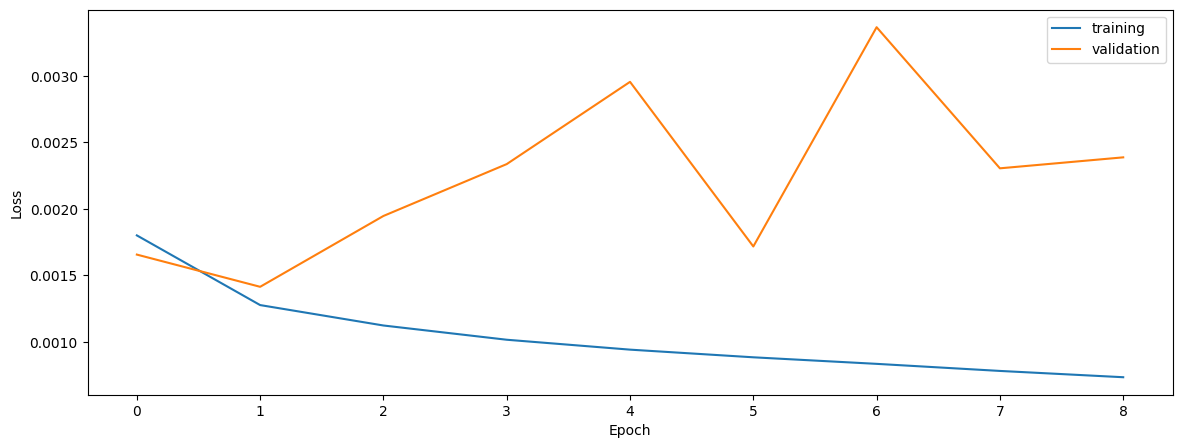

In [6]:
from util import pickleLoad
from visual import plotHistory

history = pickleLoad(path+'/{}.pkl'.format(HASHID))
plotHistory(history)

In [7]:
from util import getPearson, predictInBatches

train.append(predictInBatches(model,train[0],architecture['batch_size']))
val.append(predictInBatches(model,val[0],architecture['batch_size']))
test.append(predictInBatches(model,test[0],architecture['batch_size']))

print('train')
print(getPearson(train[1],train[4]))
print(getPearson(val[1],val[4]))
print(getPearson(test[1],test[4]))

train
0.9569273938118491
0.9575170472887503
0.9449205426372707


In [8]:
print(props['space'])
print(getPearson(train[1],train[4],train[3][0]))
print(getPearson(val[1],val[4],val[3][0]))
print(getPearson(test[1],test[4],test[3][0]))

native
0.9548047918151301
0.953351917974187
0.9485043494238944


In [9]:
print('normalized' if props['space'] == 'native' else 'native')
print(getPearson(train[1][train[2]],train[4][train[2]],train[3][1]))
print(getPearson(val[1][val[2]],val[4][val[2]],val[3][1]))
print(getPearson(test[1][test[2]],test[4][test[2]],test[3][1]))

normalized
0.9598204469513271
0.954177305842991
0.9582865480235873


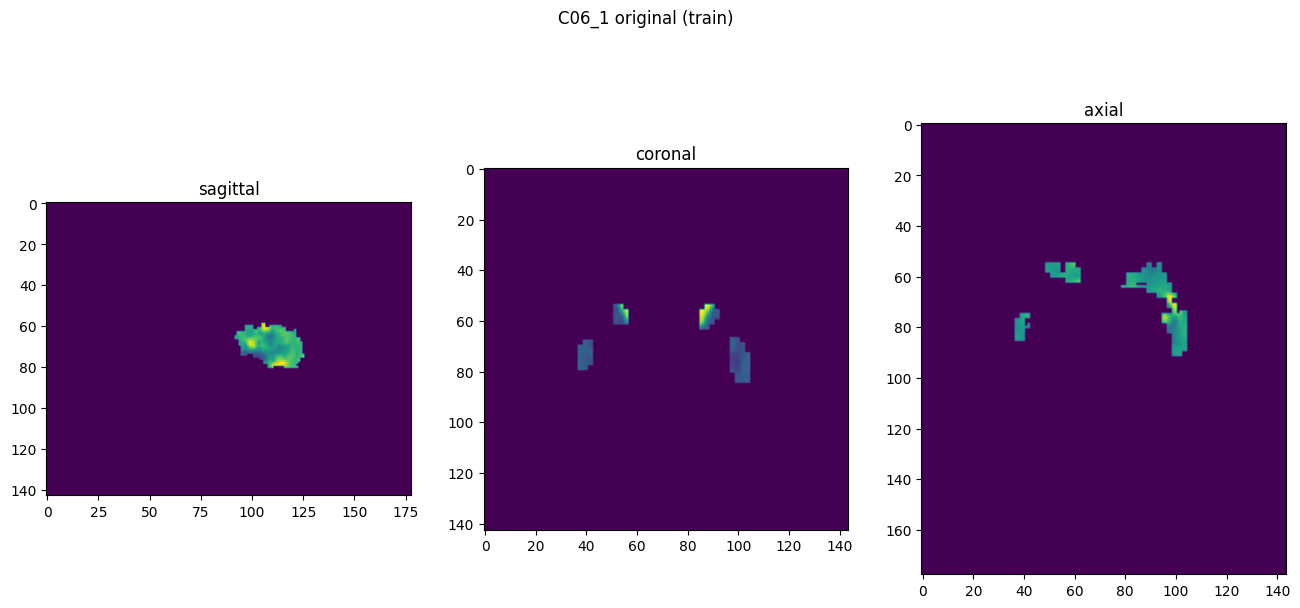

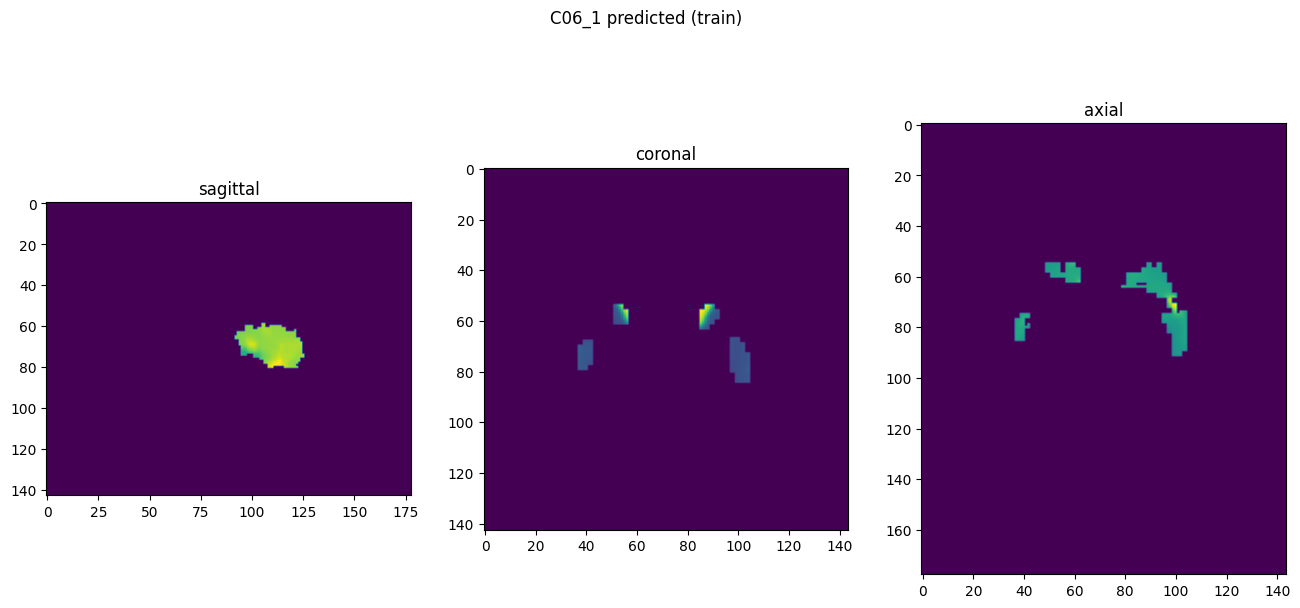

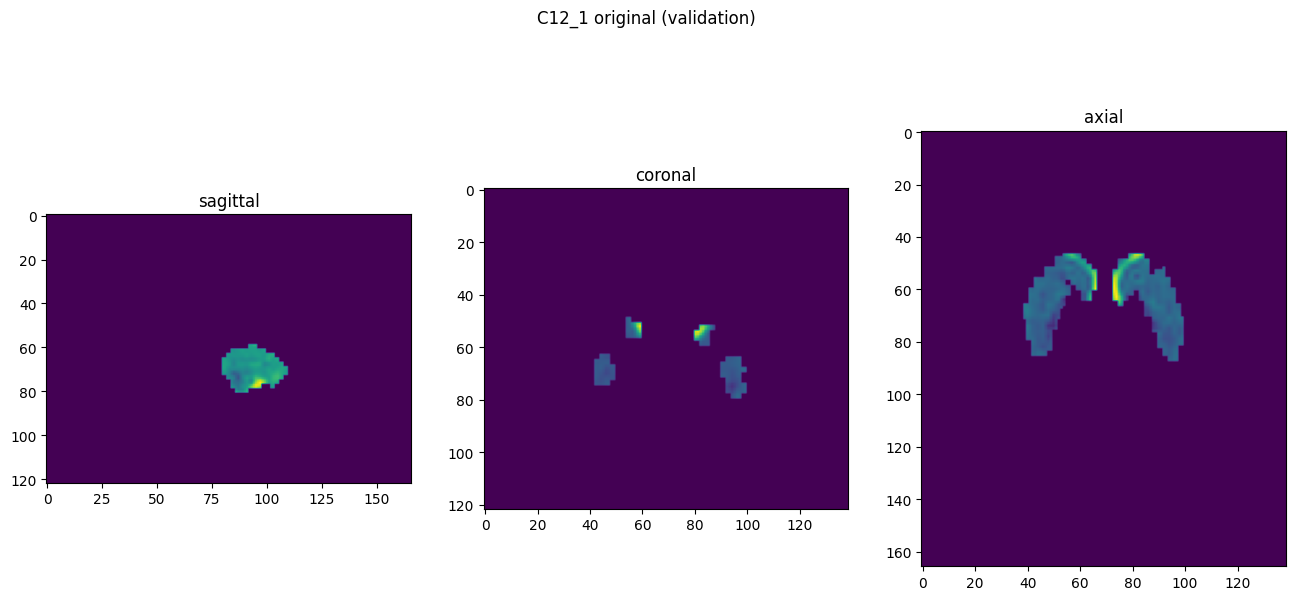

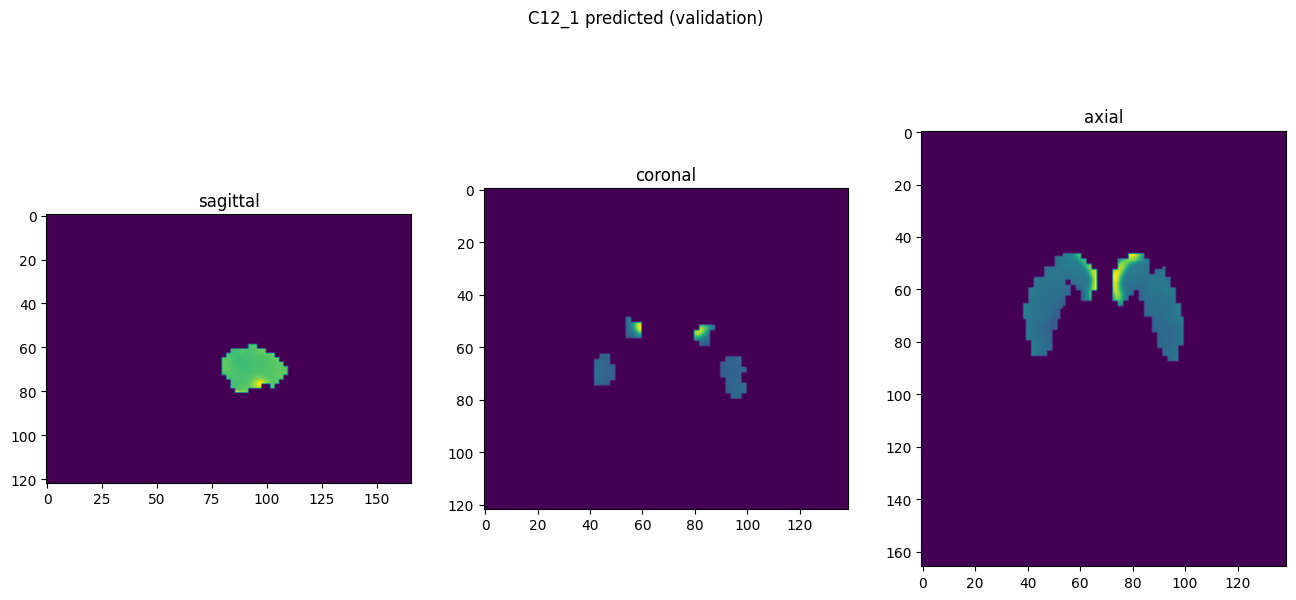

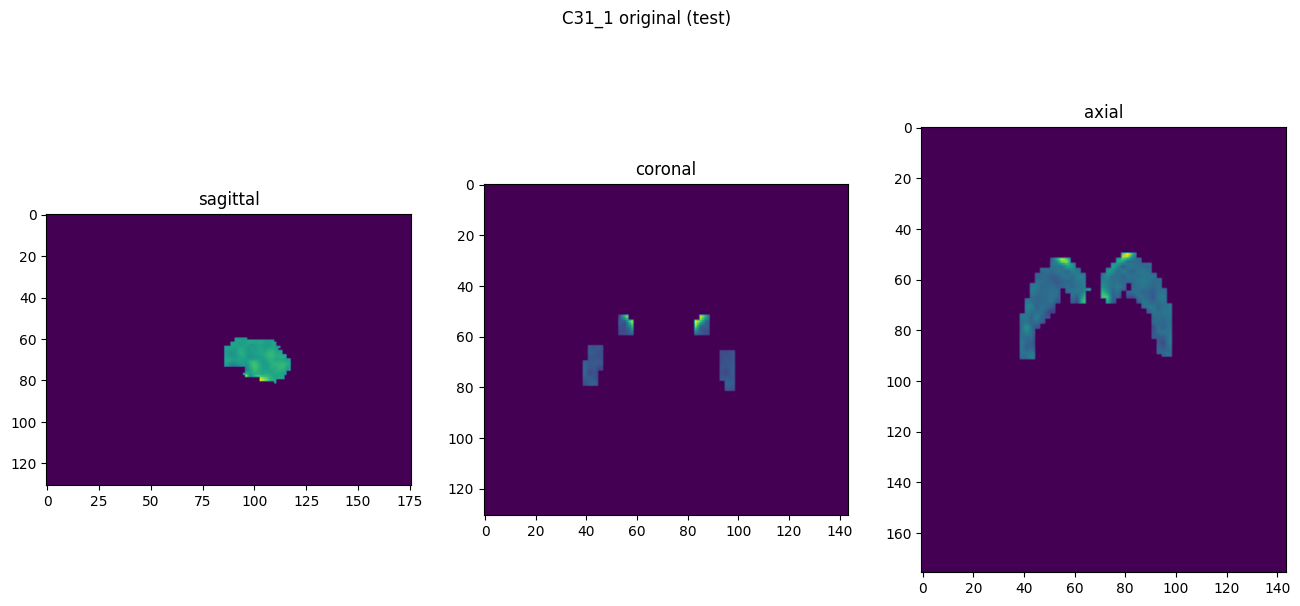

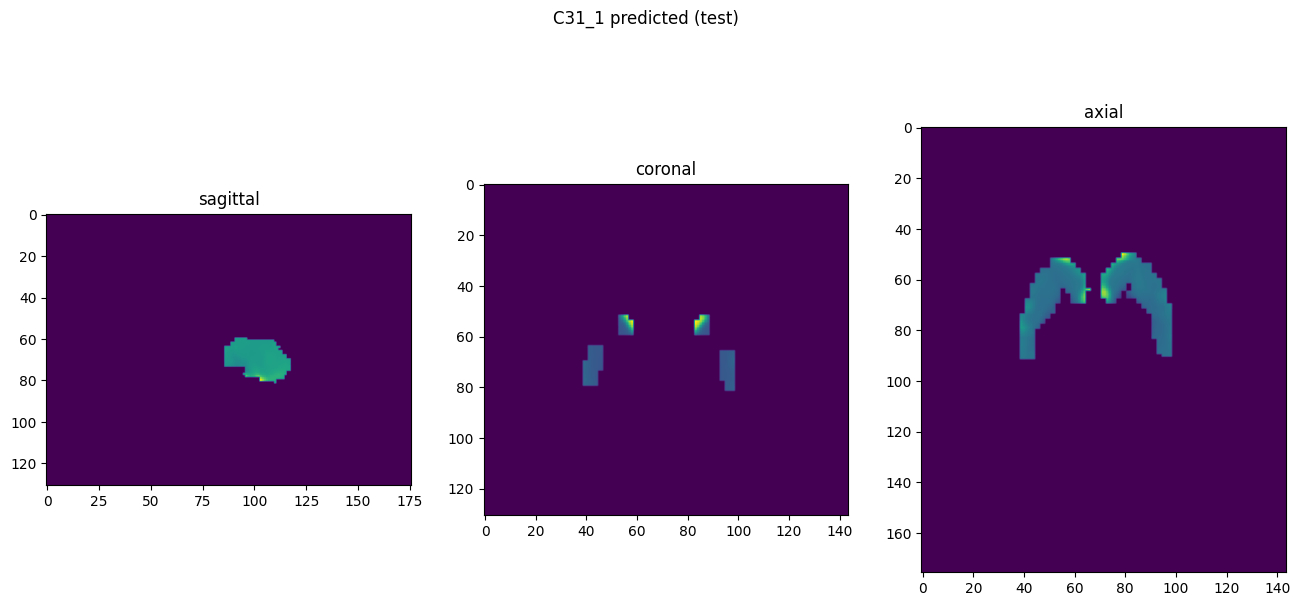

In [10]:
showResults(model, gen, threshold=None, background=False)